# 0 Load data

In [4]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# all the dataframes are clipped to the US states 


df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')
df_mlp_scores = pd.read_csv('data/US_data/df_mlp_scores.csv')

us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

In [4]:
df_pixel_optimized_data

,lon,lat,avg_npv,predicted_prob,Expectation_net_benefit,optimal_weight_economic,optimal_weight_environmental,optimal_weight_emission,ccd_optimized,coupling_degree,coordination_degree,weight_deviation_economic,weight_deviation_environmental,weight_deviation_emission,economic_feasible
0,-124.370834,47.954166,-9.371520e+05,0.045891,3586.953880,1.000000e+00,0.0,3.747003e-16,0.367652,0.996364,0.135661,0.666667,-0.333333,-0.333333,0
1,-124.212500,40.570835,5.553589e+04,0.968293,4761.501756,0.000000e+00,1.0,0.000000e+00,0.889508,0.982499,0.805318,-0.333333,0.666667,-0.333333,1
2,-124.204170,40.562500,1.223183e+04,0.960158,4719.930203,4.475587e-16,1.0,0.000000e+00,0.883643,0.978133,0.798280,-0.333333,0.666667,-0.333333,1
3,-123.679170,48.120834,-1.048014e+06,0.277199,3627.954974,4.163336e-16,1.0,5.412337e-16,0.401518,0.987139,0.163317,-0.333333,0.666667,-0.333333,0
4,-123.629166,48.120834,-1.145627e+06,0.229049,3521.462384,0.000000e+00,1.0,0.000000e+00,0.384378,0.990424,0.149175,-0.333333,0.666667,-0.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,-67.829170,46.887500,-9.098034e+05,0.999332,4014.829581,0.000000e+00,1.0,2.775558e-17,0.757982,0.691778,0.830521,-0.333333,0.666667,-0.333333,0
64978,-67.829170,46.920834,-9.480477e+05,0.999058,3966.378972,0.000000e+00,1.0,0.000000e+00,0.750965,0.679202,0.830309,-0.333333,0.666667,-0.333333,0
64979,-67.812500,46.312500,-9.327203e+05,0.999880,3986.595370,0.000000e+00,1.0,0.000000e+00,0.753910,0.684019,0.830942,-0.333333,0.666667,-0.333333,0
64980,-67.804170,46.762500,-9.530168e+05,0.999813,4000.470365,0.000000e+00,1.0,0.000000e+00,0.753451,0.683229,0.830891,-0.333333,0.666667,-0.333333,0


# 1 Generate csv for US state 

Logic is: 

to generate cvs for US state, this csv is like 

对于pv installed， Environmental suitability /ha ， Emission mitigation / ha ，Economic NPV /ha ，Power generation / ha。

first, group state  'area_m2' use sum , this is variable [abandoned land (ha) ] for each state 

second, for each state and use 'predicted_prob' * 'area_m2' in every row, and sum them to calculate cumulative , 

finally, next use this sum/[abandoned land (ha) ] to caculate averge effect in each state 



| State name | abandoned land (ha) | pv installed  | Environmental suitability /ha | Emission mitigation / ha | Economic NPV /ha| Power generation /ha  | CCD Mean improvement |
|------------|---------------------|--------------|--------------------|-----------------|--------------|--------------|--------------|
|   Row1     |   Row1              |   Row1       |   Row1             |   Row1          |   Row1       |   Row1       |   Row1       |
|   Row2     |   Row2              |   Row2       |   Row2             |   Row2          |   Row2       |   Row2       |   Row2       |


In [6]:
df_pixel_optimized_data.loc[(df_pixel_optimized_data['lat'] == 25.295834) & (df_pixel_optimized_data['lon'] == -80.287500), 'Expectation_net_benefit']

57294    4758.781908
Name: Expectation_net_benefit, dtype: float64

## 1.1 Adjust PV carbon density (Important)

In [47]:
df_pixel_optimized_data

,lon,lat,avg_npv,predicted_prob,Expectation_net_benefit,optimal_weight_economic,optimal_weight_environmental,optimal_weight_emission,ccd_optimized,coupling_degree,coordination_degree,weight_deviation_economic,weight_deviation_environmental,weight_deviation_emission,economic_feasible
0,-124.370834,47.954166,-9.371520e+05,0.045891,3586.953880,1.000000e+00,0.0,3.747003e-16,0.367652,0.996364,0.135661,0.666667,-0.333333,-0.333333,0
1,-124.212500,40.570835,5.553589e+04,0.968293,4761.501756,0.000000e+00,1.0,0.000000e+00,0.889508,0.982499,0.805318,-0.333333,0.666667,-0.333333,1
2,-124.204170,40.562500,1.223183e+04,0.960158,4719.930203,4.475587e-16,1.0,0.000000e+00,0.883643,0.978133,0.798280,-0.333333,0.666667,-0.333333,1
3,-123.679170,48.120834,-1.048014e+06,0.277199,3627.954974,4.163336e-16,1.0,5.412337e-16,0.401518,0.987139,0.163317,-0.333333,0.666667,-0.333333,0
4,-123.629166,48.120834,-1.145627e+06,0.229049,3521.462384,0.000000e+00,1.0,0.000000e+00,0.384378,0.990424,0.149175,-0.333333,0.666667,-0.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,-67.829170,46.887500,-9.098034e+05,0.999332,4014.829581,0.000000e+00,1.0,2.775558e-17,0.757982,0.691778,0.830521,-0.333333,0.666667,-0.333333,0
64978,-67.829170,46.920834,-9.480477e+05,0.999058,3966.378972,0.000000e+00,1.0,0.000000e+00,0.750965,0.679202,0.830309,-0.333333,0.666667,-0.333333,0
64979,-67.812500,46.312500,-9.327203e+05,0.999880,3986.595370,0.000000e+00,1.0,0.000000e+00,0.753910,0.684019,0.830942,-0.333333,0.666667,-0.333333,0
64980,-67.804170,46.762500,-9.530168e+05,0.999813,4000.470365,0.000000e+00,1.0,0.000000e+00,0.753451,0.683229,0.830891,-0.333333,0.666667,-0.333333,0


In [ ]:
import numpy as np

# 这里所合并的信息在inital的版本较为全面，如果考虑到后期呈现问题，直接Drop即可

emission_intensity = pd.DataFrame({
    'year': ['2018',  '2030', '2035', '2040'],
    'CO2_g_per_kWh': [400.3,  302,  279.2, 261.1]
})



df_weight['LNCS_expect'] = (
    df_weight['final_forest'] * df_weight['weighted_density_Forest'] +
    df_weight['final_agro'] * df_weight['weighted_density_Agricultural'] +
    df_strategies['final_veg'] * df_weight['weighted_density_Vegetation']
)

# 数据处理，df_net_benefit提取sites的面积信息、发电量（PIXEL为单位），pv_potential_dens是转化为碳的计算方式
# df_weight 提取环境变量 predicted_prob与Expectation_net_benefit
# df_economic 提取经济变量 net_npv_usd
power_data = df_net_benefit[['lat', 'lon', 'area_m2','E_yr_pixel']].copy()
env_data = df_weight[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()
emission_data = df_weight[['lat', 'lon', 'Expectation_net_benefit','pv_potential_dens','LNCS_expect']].copy()
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index()
ccd_data = df_pixel_optimized_data[['lat', 'lon', 'ccd_optimized']].copy()


merged_data_for_analysis = (
    env_data
    .merge(emission_data, on=['lat', 'lon'], how='outer')
    .merge(avg_npv, on=['lat', 'lon'], how='outer')
    .merge(power_data, on=['lat', 'lon'], how='outer')
    .merge(ccd_data, on=['lat', 'lon'], how='outer')
)



In [ ]:
# Transform pv_transform (2020 emission factor) to 2030, 2040, 2050 using emission_intensity
pv_transform_2020 = 352  
# Interpolate emission intensity for 2020, 2030, 2040, 2050
years_target = [2020, 2030, 2040, 2050]
em_factors = np.interp(
    years_target,
    emission_intensity['year'].astype(int),
    emission_intensity['CO2_g_per_kWh']
)

# Calculate scaling factors relative to 2020
scaling_factors = em_factors / em_factors[0]

# 生成一个pv_transfer的dataframe
pv_transfer = pd.DataFrame({
    'year': [2020, 2030, 2040, 2050],
    'pv_transform': [pv_transform_2020] + list(pv_transform_2020 * scaling_factors[1:])
})

# 计算每10年区间的累计光伏转化能力，并最终汇总到2050
years = [2020, 2030, 2040, 2050]

for idx in range(len(years)-1):
    y_start, y_end = years[idx], years[idx+1]
    pv_start = pv_transfer.loc[pv_transfer['year'] == y_start, 'pv_transform'].values[0]
    pv_end = pv_transfer.loc[pv_transfer['year'] == y_end, 'pv_transform'].values[0]
    # 线性插值每年pv_transform，累计10年
    pv_sum = 0
    for y in range(y_start, y_end):
        pv_y = pv_start + (pv_end - pv_start) * (y - y_start) / (y_end - y_start)
        pv_sum += merged_data_for_analysis['E_yr_pixel'] * pv_y / 1000 / 1000 * 0.27 / (merged_data_for_analysis['area_m2'] / 10000)
    merged_data_for_analysis[f'pv_potential_{y_start}_{y_end-1}_sum'] = pv_sum

# 汇总2020-2050累计值，汇总site的累计光伏减排能力(t C)
merged_data_for_analysis['pv_potential_total(t)'] = sum(
    merged_data_for_analysis[f'pv_potential_{years[i]}_{years[i+1]-1}_sum'] for i in range(len(years)-1)
)

merged_data_for_analysis['power_generation_kwha'] = merged_data_for_analysis['E_yr_pixel'] * 30 / merged_data_for_analysis['area_m2'] * 10000

In [ ]:
merged_data_for_analysis['Expectation_net_benefit_adjust'] = merged_data_for_analysis['pv_potential_total(t)'] - merged_data_for_analysis['LNCS_expect']


In [ ]:
merged_data_for_analysis.drop(columns=['pv_potential_2040_2049_sum','pv_potential_2030_2039_sum','pv_potential_2020_2029_sum'], inplace=True)
merged_data_for_analysis

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,pv_potential_dens,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,pv_potential_total(t),power_generation_kwha,Expectation_net_benefit_adjust,ccd_optimized
0,25.295834,-80.287500,0.000000,3.874315e+16,negative_sample,6382.303639,7191.865919,809.562299,407275.912577,776295.361002,1.958127e+08,5568.344207,7.567199e+07,4758.781908,0.813290
1,25.437500,-80.537500,0.046746,2.054387e+18,prediction,5690.624063,7035.368191,1344.744161,283953.326746,775385.854124,1.913273e+08,5447.174926,7.402534e+07,4102.430766,0.755979
2,25.437500,-80.495834,0.000000,4.247702e+15,negative_sample,6055.300591,7024.124059,968.823440,275019.106094,775385.854124,1.910215e+08,5438.469092,7.390703e+07,4469.645652,0.785107
3,25.445833,-80.454170,0.000000,1.117299e+13,negative_sample,6048.645138,7017.640780,968.995616,269947.631894,775332.207938,1.908320e+08,5433.449375,7.383881e+07,4464.453759,0.783940
4,25.445833,-80.404170,0.017465,4.463459e+17,prediction,6081.010322,7045.490473,964.480123,291620.314126,775332.207938,1.915894e+08,5455.012162,7.413184e+07,4490.532039,0.790277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,0.026153,1.493778e+17,prediction,6210.923349,6392.674772,181.751426,-220868.055076,563356.382622,1.263101e+08,4949.565792,6.726299e+07,4767.814366,0.653804
64978,48.995834,-110.345830,0.068266,4.120084e+17,prediction,6206.053157,6395.853979,189.800818,-219393.096487,563356.382622,1.263729e+08,4952.027311,6.729644e+07,4762.226494,0.653879
64979,48.995834,-106.020836,0.065097,3.232082e+17,prediction,6204.952188,6412.037900,207.085706,-205704.827949,563356.382622,1.266927e+08,4964.557807,6.746673e+07,4757.472100,0.650767
64980,48.995834,-104.087500,0.109234,6.627032e+21,prediction,6077.421747,6292.888713,215.466966,-300314.323514,563356.382622,1.243385e+08,4872.305853,6.621305e+07,4656.838886,0.611981


In [ ]:
# merged_data_for_analysis.to_csv('data/US_data/df_merged_data_for_analysis.csv', index=False)

In [92]:
df_weight.drop(columns=['Expectation_net_benefit'], inplace=True)
df_weight.drop(columns=['pv_potential_dens'], inplace=True)


In [ ]:
# df_weight.to_csv('data/US_data/df_weight.csv', index=False)

## 1.2 Statistic for State-level 

In [28]:
import pandas as pd 

merged_data_for_analysis = pd.read_csv('data/US_data/df_merged_data_for_analysis.csv')

In [ ]:
# merged = pd.merge(merged_data_for_analysis, df_pixel_optimized_data[['lat', 'lon', 'ccd_optimized']], on=['lat', 'lon'], how='left')
# merged.to_csv('data/US_data/df_merged_data_for_analysis.csv', index=False)

In [29]:
merged_data_for_analysis

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,pv_potential_dens,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,pv_potential_total(t),power_generation_kwha,Expectation_net_benefit_adjust,ccd_optimized
0,25.295834,-80.287500,0.000000,3.874315e+16,negative_sample,6382.303639,7191.865919,809.562299,407275.912577,776295.361002,1.958127e+08,5568.344207,7.567199e+07,4758.781908,0.813290
1,25.437500,-80.537500,0.046746,2.054387e+18,prediction,5690.624063,7035.368191,1344.744161,283953.326746,775385.854124,1.913273e+08,5447.174926,7.402534e+07,4102.430766,0.755979
2,25.437500,-80.495834,0.000000,4.247702e+15,negative_sample,6055.300591,7024.124059,968.823440,275019.106094,775385.854124,1.910215e+08,5438.469092,7.390703e+07,4469.645652,0.785107
3,25.445833,-80.454170,0.000000,1.117299e+13,negative_sample,6048.645138,7017.640780,968.995616,269947.631894,775332.207938,1.908320e+08,5433.449375,7.383881e+07,4464.453759,0.783940
4,25.445833,-80.404170,0.017465,4.463459e+17,prediction,6081.010322,7045.490473,964.480123,291620.314126,775332.207938,1.915894e+08,5455.012162,7.413184e+07,4490.532039,0.790277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,0.026153,1.493778e+17,prediction,6210.923349,6392.674772,181.751426,-220868.055076,563356.382622,1.263101e+08,4949.565792,6.726299e+07,4767.814366,0.653804
64978,48.995834,-110.345830,0.068266,4.120084e+17,prediction,6206.053157,6395.853979,189.800818,-219393.096487,563356.382622,1.263729e+08,4952.027311,6.729644e+07,4762.226494,0.653879
64979,48.995834,-106.020836,0.065097,3.232082e+17,prediction,6204.952188,6412.037900,207.085706,-205704.827949,563356.382622,1.266927e+08,4964.557807,6.746673e+07,4757.472100,0.650767
64980,48.995834,-104.087500,0.109234,6.627032e+21,prediction,6077.421747,6292.888713,215.466966,-300314.323514,563356.382622,1.243385e+08,4872.305853,6.621305e+07,4656.838886,0.611981


In [21]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

def generate_state_level_csv(merged_data_for_analysis, us_states_4326, output_path='data/US_data/US_analysis_reslut/state_level_analysis.csv'):
    """
    生成州级统计CSV，按照指定逻辑计算各指标
    
    逻辑：
    1. 按州分组，计算总废弃土地面积 (abandoned land ha)
    2. 对每个州，计算各指标的加权平均 (密度 × 面积，然后除以总面积)
    3. 输出标准化的州级统计表
    """
    
    # 1. 添加州标签
    print("正在添加州标签...")
    geometry = [Point(xy) for xy in zip(merged_data_for_analysis['lon'], merged_data_for_analysis['lat'])]
    pixel_gdf = gpd.GeoDataFrame(merged_data_for_analysis, geometry=geometry, crs='EPSG:4326')
    pixel_with_states = gpd.sjoin(pixel_gdf, us_states_4326, how='left', predicate='within')
    
    # 移除几何列，保留数据
    data_with_states = pixel_with_states.drop(columns=['geometry']).copy()
    
    # 2. 按州分组计算统计
    print("正在计算州级统计...")
    
    def calculate_state_metrics(group):
        """计算单个州的指标"""
        # 基础信息
        state_name = group['NAME'].iloc[0] if not group['NAME'].isna().all() else 'Unknown'
        
        # 先转换面积单位：m² -> ha
        area_ha = group['area_m2'] / 10000
        total_area_ha = area_ha.sum()
        
        # 各指标的加权平均计算
        # 使用密度 × 面积(ha)，然后除以总面积(ha)得到加权平均
        
        metrics = {
            'State_name': state_name,
            'abandoned_land_ha': total_area_ha,
        }
        
        # Environmental suitability /ha (predicted_prob的加权平均)
        if 'predicted_prob' in group.columns:
            env_weighted_sum = (group['predicted_prob'] * area_ha).sum()
            metrics['Environmental_suitability_per_ha'] = env_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['Environmental_suitability_per_ha'] = 0
        
        # Emission mitigation /ha (Expectation_net_benefit的加权平均)
        if 'Expectation_net_benefit' in group.columns:
            emission_weighted_sum = (group['Expectation_net_benefit'] * area_ha).sum()
            metrics['Emission_mitigation_per_ha'] = emission_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['Emission_mitigation_per_ha'] = 0
        
        # Economic NPV /ha (avg_npv的加权平均)
        if 'net_npv_usd' in group.columns:
            economic_weighted_sum = (group['net_npv_usd'] * area_ha).sum()
            metrics['Economic_NPV_per_ha'] = economic_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['Economic_NPV_per_ha'] = 0
        
        # Power generation /ha (E_yr_pixel的加权平均)
        if 'E_yr_pixel' in group.columns:
            power_weighted_sum = (group['E_yr_pixel'] * 30 ).sum()
            metrics['Power_generation_per_ha'] = power_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['Power_generation_per_ha'] = 0
        
        # CCD Mean  (如果有ccd_optimized列)
        if 'ccd_optimized' in group.columns:
            ccd_weighted_sum = (group['ccd_optimized'] * area_ha).sum()
            metrics['CCD_Mean'] = ccd_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['CCD_Mean'] = 0
        
        # # 额外统计信息
        # metrics['pixel_count'] = len(group)
        # metrics['avg_pixel_area_ha'] = area_ha.mean()        
        return pd.Series(metrics)
    
    # 按州分组并计算指标
    state_stats = data_with_states.groupby('NAME', observed=True).apply(calculate_state_metrics).reset_index(drop=True)
    
    # 3. 数据清理和格式化
    print("正在格式化数据...")
    
    # 移除未知州
    state_stats = state_stats[state_stats['State_name'] != 'Unknown'].copy()
    
    # 按废弃土地面积排序
    state_stats = state_stats.sort_values('abandoned_land_ha', ascending=False).reset_index(drop=True)
    
    # 数值格式化
    numeric_columns = [
        'abandoned_land_ha', 'Environmental_suitability_per_ha', 'Emission_mitigation_per_ha',
        'Economic_NPV_per_ha', 'Power_generation_per_ha', 'CCD_Mean', 'avg_pixel_area_ha'
    ]
    
    for col in numeric_columns:
        if col in state_stats.columns:
            state_stats[col] = state_stats[col].round(4)
    
    # 4. 保存CSV
    print(f"正在保存到: {output_path}")
    state_stats.to_csv(output_path, index=False)
    
    # 5. 输出摘要
    print(f"\n州级统计完成！")
    print(f"总州数: {len(state_stats)}")
    print(f"总废弃土地面积: {state_stats['abandoned_land_ha'].sum():.2f} 公顷")
    print(f"平均每州废弃土地面积: {state_stats['abandoned_land_ha'].mean():.2f} 公顷")
    
    # 显示前5个州
    print(f"\n前5个州（按废弃土地面积排序）:")
    display_cols = ['State_name', 'abandoned_land_ha', 'Environmental_suitability_per_ha', 
                   'Emission_mitigation_per_ha', 'Economic_NPV_per_ha']
    print(state_stats[display_cols].head().to_string(index=False))
    
    return state_stats

# 使用示例
if __name__ == "__main__":
    # 假设 merged_data_for_analysis 和 us_states_4326 已经定义
    state_stats_df = generate_state_level_csv(merged_data_for_analysis, us_states_4326)

正在添加州标签...
正在计算州级统计...
正在格式化数据...
正在保存到: data/US_data/US_analysis_reslut/state_level_analysis.csv

州级统计完成！
总州数: 48
总废弃土地面积: 4376972.78 公顷
平均每州废弃土地面积: 91186.93 公顷

前5个州（按废弃土地面积排序）:
State_name  abandoned_land_ha  Environmental_suitability_per_ha  Emission_mitigation_per_ha  Economic_NPV_per_ha
     Texas        515459.2186                            0.7860                   6722.3459          262293.9622
  Illinois        291941.0631                            0.8573                   5763.0992         -527071.3078
California        271672.0489                            0.5379                   7481.2128          770496.9652
   Georgia        244587.2796                            0.9510                   6426.1686          -45315.8133
   Indiana        219739.8319                            0.8795                   5644.3213         -605635.6691


C:\Users\zpy10\AppData\Local\Temp\ipykernel_9928\3222787354.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_stats = data_with_states.groupby('NAME', observed=True).apply(calculate_state_metrics).reset_index(drop=True)


## 1.3 Statitic for County-level

In [25]:
def generate_county_level_csv(merged_data_for_analysis, us_counties_4326, output_path='data/US_data/US_analysis_reslut/county_level_analysis.csv'):
    """
    生成县级统计CSV，按照与州级相同的逻辑计算各指标
    """
    print("正在添加县标签...")
    geometry = [Point(xy) for xy in zip(merged_data_for_analysis['lon'], merged_data_for_analysis['lat'])]
    pixel_gdf = gpd.GeoDataFrame(merged_data_for_analysis, geometry=geometry, crs='EPSG:4326')
    pixel_with_counties = gpd.sjoin(pixel_gdf, us_counties_4326, how='left', predicate='within')
    data_with_counties = pixel_with_counties.drop(columns=['geometry']).copy()

    print("正在计算县级统计...")

    def calculate_county_metrics(group):
        county_name = group['NAME'].iloc[0] if not group['NAME'].isna().all() else 'Unknown'
        statefp = group['STATEFP'].iloc[0] if 'STATEFP' in group.columns else ''
        countyfp = group['COUNTYFP'].iloc[0] if 'COUNTYFP' in group.columns else ''
        area_ha = group['area_m2'] / 10000
        total_area_ha = area_ha.sum()
        metrics = {
            'County_name': county_name,
            'STATEFP': statefp,
            'COUNTYFP': countyfp,
            'abandoned_land_ha': total_area_ha,
        }
        if 'predicted_prob' in group.columns:
            env_weighted_sum = (group['predicted_prob'] * area_ha).sum()
            metrics['Environmental_suitability_per_ha'] = env_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['Environmental_suitability_per_ha'] = 0
        if 'Expectation_net_benefit' in group.columns:
            emission_weighted_sum = (group['Expectation_net_benefit'] * area_ha).sum()
            metrics['Emission_mitigation_per_ha'] = emission_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['Emission_mitigation_per_ha'] = 0
        if 'net_npv_usd' in group.columns:
            economic_weighted_sum = (group['net_npv_usd'] * area_ha).sum()
            metrics['Economic_NPV_per_ha'] = economic_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['Economic_NPV_per_ha'] = 0
        if 'E_yr_pixel' in group.columns:
            power_weighted_sum = (group['E_yr_pixel'] * 30).sum()
            metrics['Power_generation_per_ha'] = power_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['Power_generation_per_ha'] = 0
        if 'ccd_optimized' in group.columns:
            ccd_weighted_sum = (group['ccd_optimized'] * area_ha).sum()
            metrics['CCD_Mean'] = ccd_weighted_sum / total_area_ha if total_area_ha > 0 else 0
        else:
            metrics['CCD_Mean'] = 0
        return pd.Series(metrics)

    county_stats = data_with_counties.groupby(['STATEFP', 'COUNTYFP', 'NAME'], observed=True).apply(calculate_county_metrics).reset_index(drop=True)
    county_stats = county_stats[county_stats['County_name'] != 'Unknown'].copy()
    county_stats = county_stats.sort_values('abandoned_land_ha', ascending=False).reset_index(drop=True)
    numeric_columns = [
        'abandoned_land_ha', 'Environmental_suitability_per_ha', 'Emission_mitigation_per_ha',
        'Economic_NPV_per_ha', 'Power_generation_per_ha', 'CCD_Mean'
    ]
    for col in numeric_columns:
        if col in county_stats.columns:
            county_stats[col] = county_stats[col].round(4)
    print(f"正在保存到: {output_path}")
    county_stats.to_csv(output_path, index=False)
    print(f"\n县级统计完成！")
    print(f"总县数: {len(county_stats)}")
    print(f"总废弃土地面积: {county_stats['abandoned_land_ha'].sum():.2f} 公顷")
    print(f"平均每县废弃土地面积: {county_stats['abandoned_land_ha'].mean():.2f} 公顷")
    print(f"\n前5个县（按废弃土地面积排序）:")
    display_cols = ['County_name', 'STATEFP', 'COUNTYFP', 'abandoned_land_ha', 'Environmental_suitability_per_ha', 
                   'Emission_mitigation_per_ha', 'Economic_NPV_per_ha']
    print(county_stats[display_cols].head().to_string(index=False))
    return county_stats

# 使用示例
county_stats_df = generate_county_level_csv(merged_data_for_analysis, us_counties_4326)
county_stats_df


正在添加县标签...
正在计算县级统计...
正在保存到: data/US_data/US_analysis_reslut/county_level_analysis.csv

县级统计完成！
总县数: 2440
总废弃土地面积: 4376972.78 公顷
平均每县废弃土地面积: 1793.84 公顷

前5个县（按废弃土地面积排序）:
County_name STATEFP COUNTYFP  abandoned_land_ha  Environmental_suitability_per_ha  Emission_mitigation_per_ha  Economic_NPV_per_ha
     Fresno      06      019         38974.1038                            0.5998                   7493.0897          749981.7193
    Hidalgo      48      215         38052.8845                            0.1821                   6713.6434          191699.4433
     Tulare      06      107         33121.2112                            0.4548                   7547.2596          785671.8751
       Will      17      197         31175.2304                            0.7299                   5577.6903         -630879.8341
     Madera      06      039         24980.3094                            0.5779                   7486.6939          774396.9547


C:\Users\zpy10\AppData\Local\Temp\ipykernel_9928\1955337430.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  county_stats = data_with_counties.groupby(['STATEFP', 'COUNTYFP', 'NAME'], observed=True).apply(calculate_county_metrics).reset_index(drop=True)


,County_name,STATEFP,COUNTYFP,abandoned_land_ha,Environmental_suitability_per_ha,Emission_mitigation_per_ha,Economic_NPV_per_ha,Power_generation_per_ha,CCD_Mean
0,Fresno,06,019,38974.1038,0.5998,7493.0897,749981.7193,8.026075e+07,0.9281
1,Hidalgo,48,215,38052.8845,0.1821,6713.6434,191699.4433,7.278568e+07,0.7952
2,Tulare,06,107,33121.2112,0.4548,7547.2596,785671.8751,8.075051e+07,0.9002
3,Will,17,197,31175.2304,0.7299,5577.6903,-630879.8341,6.179863e+07,0.6898
4,Madera,06,039,24980.3094,0.5779,7486.6939,774396.9547,8.060739e+07,0.9255
...,...,...,...,...,...,...,...,...,...
2435,Red Lake,27,125,57.6248,0.7776,5498.0444,-699671.8740,6.086724e+07,0.7129
2436,Lincoln,30,053,57.1044,0.0051,6490.9617,30097.2262,7.062517e+07,0.7212
2437,Ramsey,38,071,57.0951,0.1975,5768.0864,-486375.2171,6.372517e+07,0.5119
2438,Boundary,16,021,56.7210,0.0955,5812.4662,-506724.3453,6.344833e+07,0.5233


## 1.4 Calculate mean improvement of CCD solution

based on the algrithom of def(create_cross_target_analysi和create_combined_cumulative_analysis)


第一模块（州累积曲线绘制模块，主要参考create_combined_cumulative_analysis函数）

计算逻辑大概是（以predicted_prob变量累积为例，这个变量属于Environmental_sustainbility维度）：
首先，在全局按照效益值从高到低排序；其次按照这个排序逐项累加形成累积曲线；
其次，在全局顺序中为每个点增加州的标签State_name，并根据全局的排序，更新各个州的累积状态；
再次，对于其他Expectation_net_benefit，avg_npv执行重复操作；
第四，记录各个solution的排序顺序，在对应三个维度执行累加的重复操作（交叉曲线分析）
（这一步骤类似于        # ==================== 按CCD排序的累积效应曲线 ====================
        ccd_sorted_indices = np.argsort(ccd_values_total)[::-1]
        ccd_sorted_benefits = benefit_total_values[ccd_sorted_indices]
        ccd_cumulative_benefits = np.cumsum(ccd_sorted_benefits)
        ccd_cumulative_percentage = np.arange(1, len(ccd_cumulative_benefits) + 1) / len(ccd_cumulative_benefits) * 100
        
        # 确保从0开始
        ccd_cumulative_benefits = np.concatenate([[0], ccd_cumulative_benefits])
        ccd_cumulative_percentage = np.concatenate([[0], ccd_cumulative_percentage])）
第二模块（州积分统计模块，主要参考create_cross_target_analysi）
第五，一共有3个维度，每个维度有4种排序方案。此时参考create_cross_target_analysis函数中积分计算逻辑，统计各个州从大小到小之后累积曲线在[0,1]之间的积分，以量化它在总体政策效应之中的贡献，又可以提供横向之间比较。

输入数据主要有us_states_4326（各个州的shp数据），predicted_prob（对应Environmental_sustainability）
avg_npv（对应Economic_feasibility维度），Expectation_net_benefit（对应Emission_mitigation_ability维度）


输出一个dataframe,存储了各个州的mean ploicy efficiency
column: 'State_name'; 'Solution Type'; 'Environmental_sustainbility'; 'Emission mitigation ability'; 'Economic feasibility' ; 

Solution type includes : Envrionmental\ Emission mitigation\ Economic \ WCCD 

create_combined_cumulative_analysis给出了一个example:它给出了在单目标最优下各个州的累积路径。

=== 开始州级别累积积分统计分析（简化版）===
正在合并数据...
正在添加州标签...
发现 48 个州
正在处理排序方案: Environmental
  处理维度: Environmental_sustainability
  处理维度: Emission_mitigation_ability
  处理维度: Economic_feasibility
正在处理排序方案: Emission_mitigation
  处理维度: Environmental_sustainability
  处理维度: Emission_mitigation_ability
  处理维度: Economic_feasibility
正在处理排序方案: Economic
  处理维度: Environmental_sustainability
  处理维度: Emission_mitigation_ability
  处理维度: Economic_feasibility
正在处理排序方案: WCCD
  处理维度: Environmental_sustainability
  处理维度: Emission_mitigation_ability
  处理维度: Economic_feasibility
正在格式化结果...
正在绘制各州累积曲线...
已保存: data/US_data/US_analysis_reslut/state_cumulative_curves_predicted_prob_simplified.png


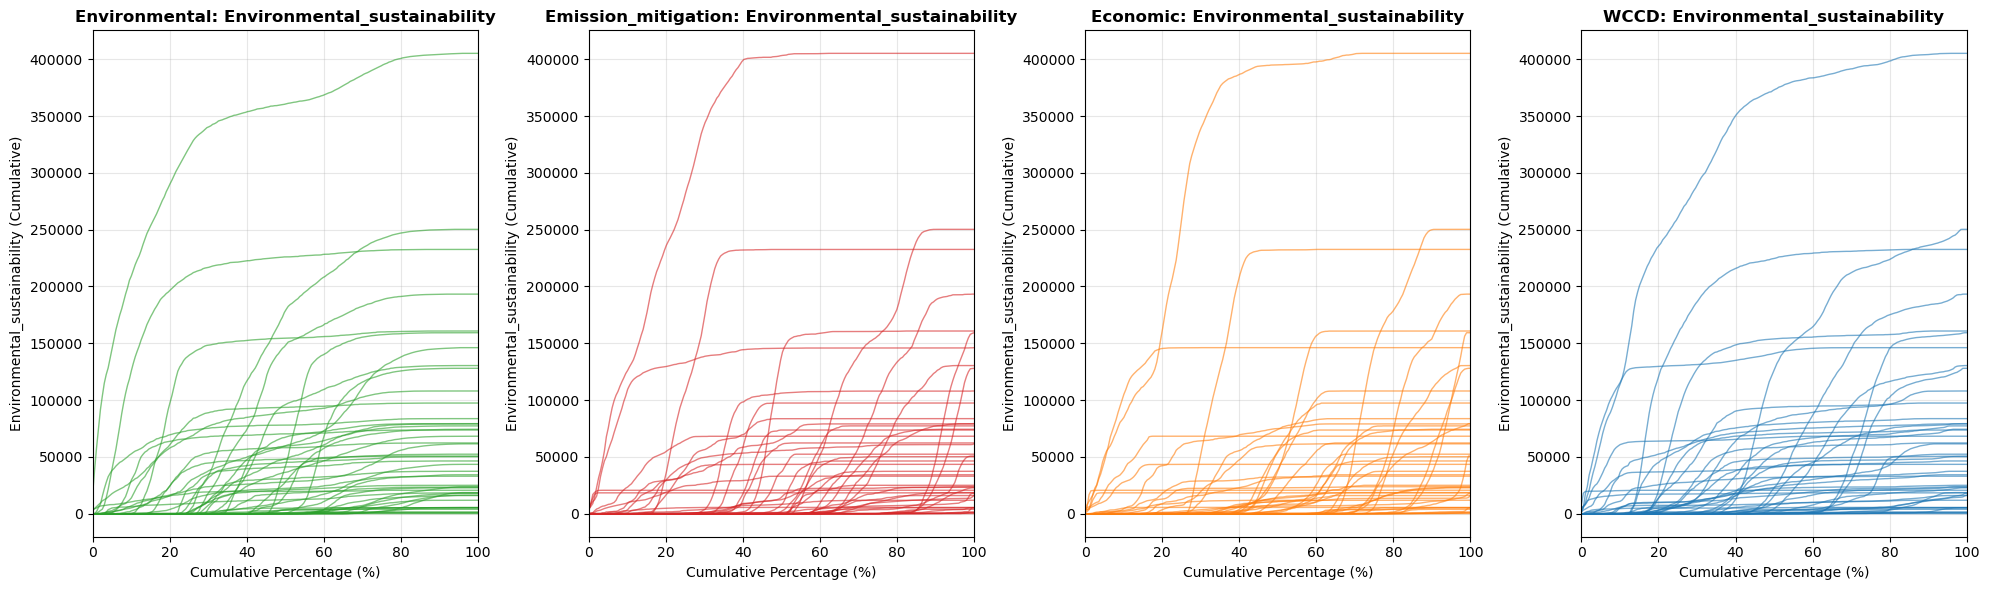

已保存: data/US_data/US_analysis_reslut/state_cumulative_curves_Expectation_net_benefit_simplified.png


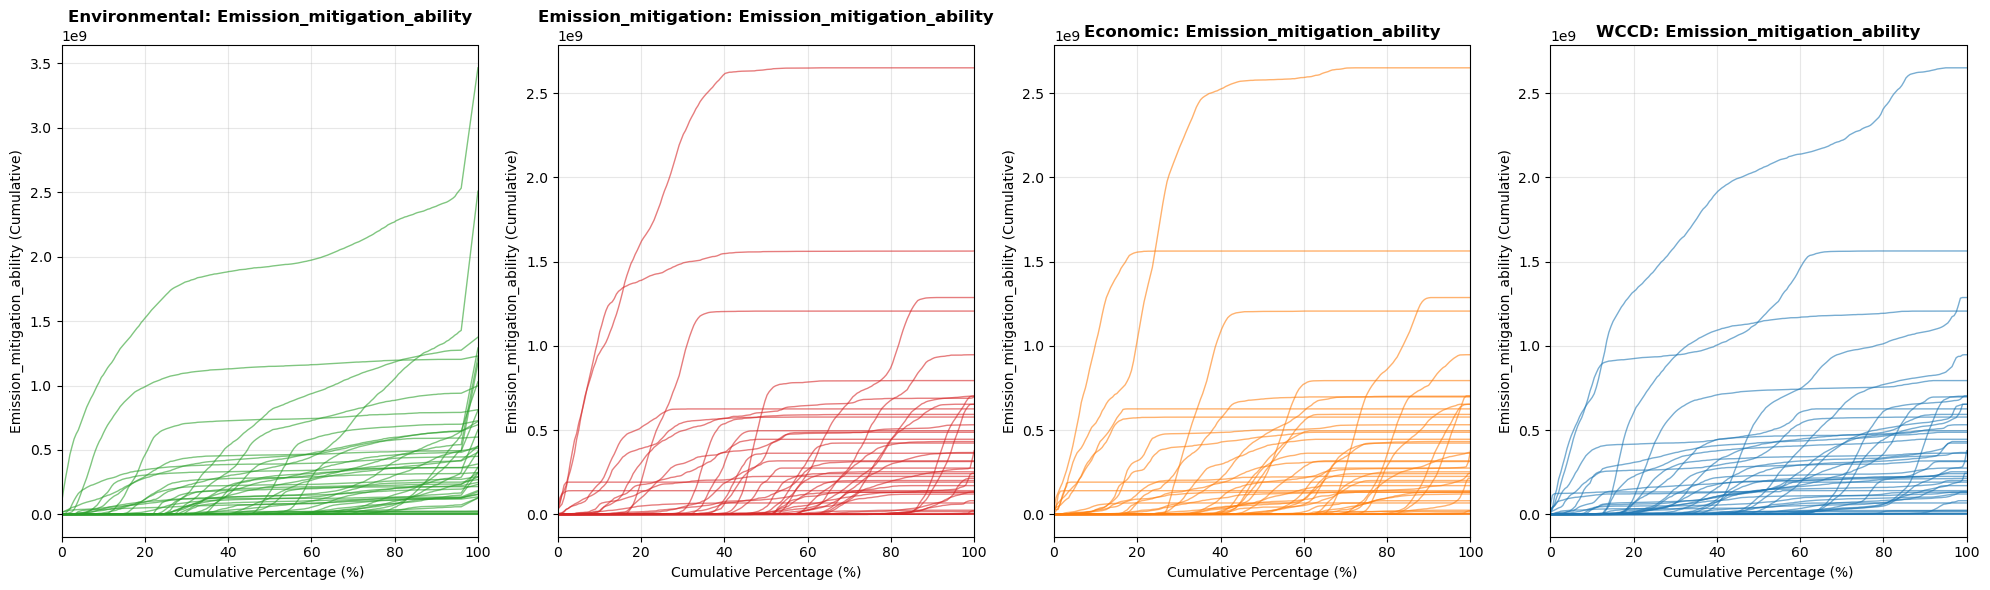

已保存: data/US_data/US_analysis_reslut/state_cumulative_curves_avg_npv_simplified.png


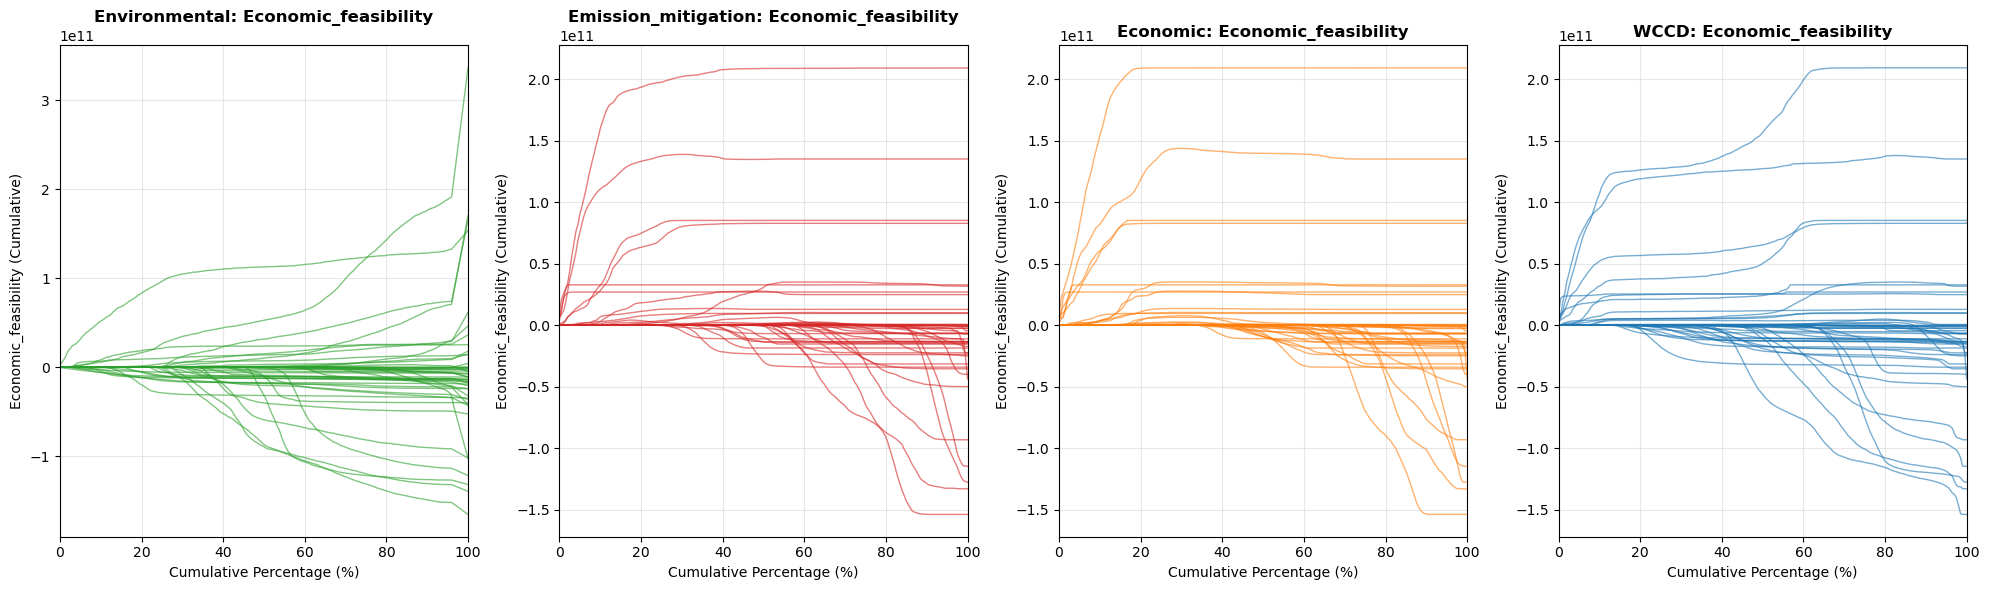


=== 州级别累积积分统计完成 ===
总州数: 48
总记录数: 192
每个州有 4 种排序方案

前10个州的WCCD方案结果:
 State_name  Environmental_sustainability  Emission_mitigation_ability  Economic_feasibility
    Alabama                  63375.564043                 3.237603e+08         -4.857993e+09
    Arizona                  17500.672169                 1.525581e+08          2.624102e+10
   Arkansas                  42205.665313                 2.086627e+08         -9.232186e+09
 California                 131610.598532                 1.176536e+09          1.598082e+11
   Colorado                  63229.339990                 4.950426e+08          6.783992e+10
Connecticut                    248.933724                 1.090621e+06         -1.535457e+08
   Delaware                  16055.502330                 7.724699e+07         -3.424821e+09
    Florida                  26369.712201                 2.142394e+08          1.192068e+09
    Georgia                 177949.655108                 9.084424e+08         -8.549310e+09
 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_state_integration_analysis_simplified(pixel_optimized_data, us_states_4326, df_net_benefit, 
                                                   plot_curves=True, output_dir='data/US_data/US_analysis_reslut'):
    """
    简化版：生成更简洁的州级积分统计结果
    """
    print("=== 开始州级别累积积分统计分析（简化版）===")
    
    # 1. 定义三个维度和四种排序方案
    variables = [
        ('predicted_prob', 'Environmental_sustainability'),
        ('Expectation_net_benefit', 'Emission_mitigation_ability'), 
        ('avg_npv', 'Economic_feasibility')
    ]
    
    solution_types = ['Environmental', 'Emission_mitigation', 'Economic', 'WCCD']
    
    # 2. 数据预处理
    print("正在合并数据...")
    area_data = df_net_benefit[['lat', 'lon', 'area_m2']].copy()
    merged_data = pixel_optimized_data.merge(area_data, on=['lat', 'lon'], how='inner')
    area_values = merged_data['area_m2'].values / 10000
    
    # 3. 创建几何列，添加州标签
    print("正在添加州标签...")
    geometry = [Point(xy) for xy in zip(merged_data['lon'], merged_data['lat'])]
    pixel_gdf = gpd.GeoDataFrame(merged_data, geometry=geometry, crs='EPSG:4326')
    pixel_with_states = gpd.sjoin(pixel_gdf, us_states_4326, how='left', predicate='within')
    data_with_states = pixel_with_states.drop(columns=['geometry']).copy()
    
    # 4. 辅助函数
    def percentage_to_01(percentage_array):
        return percentage_array / 100.0
    
    def calculate_integral(x, y):
        """使用梯形法则计算积分"""
        if len(x) < 2:
            return 0.0
        if x[0] > x[-1]:
            x = x[::-1]
            y = y[::-1]
        integral = 0.0
        for i in range(len(x) - 1):
            dx = x[i+1] - x[i]
            avg_y = (y[i] + y[i+1]) / 2.0
            integral += avg_y * dx
        return integral
    
    # 5. 获取所有州列表
    all_states = data_with_states['NAME'].dropna().unique()
    print(f"发现 {len(all_states)} 个州")
    
    # 6. 存储结果 - 简化结构
    results = []
    state_curves_data = {}
    
    # 7. 对每个排序方案计算总体排序和州级曲线
    for solution_type in solution_types:
        print(f"正在处理排序方案: {solution_type}")
        
        # 7.1 确定总体排序依据
        if solution_type == 'WCCD':
            sort_values = merged_data['ccd_optimized'].values
        elif solution_type == 'Environmental':
            sort_values = merged_data['predicted_prob'].values* area_values
        elif solution_type == 'Emission_mitigation':
            sort_values = merged_data['Expectation_net_benefit'].values * area_values
        elif solution_type == 'Economic':
            sort_values = merged_data['avg_npv'].values * area_values
        
        # 7.2 创建总体精细分位数区间
        fine_percentiles = np.arange(100, -0.5, -0.5)
        fine_bins = np.percentile(sort_values, fine_percentiles)
        
        # 7.3 对每个维度计算州级累积曲线
        solution_curves = {}
        state_integrals = {}  # 存储每个州在该排序方案下的所有维度积分
        
        for var_name, var_label in variables:
            print(f"  处理维度: {var_label}")
            
            # 计算该维度的总效益值
            if var_name == 'predicted_prob':
                benefit_total_values = merged_data[var_name].values * area_values
            else:
                benefit_total_values = merged_data[var_name].values * area_values
            
            # 存储各州的累积曲线数据
            state_cumulative_data = {}
            
            # 7.4 对每个州计算累积曲线
            for state_name in all_states:
                state_mask = data_with_states['NAME'] == state_name
                state_data = data_with_states[state_mask]
                
                if len(state_data) == 0:
                    continue
                
                # 获取该州的数据
                state_indices = state_data.index
                state_benefit_values = benefit_total_values[state_indices]
                state_sort_values = sort_values[state_indices]
                
                # 按照总体精细分位数区间来划分该州的数据
                state_cumulative_benefits = []
                
                for i in range(len(fine_bins) - 1):
                    mask = (state_sort_values <= fine_bins[i]) & (state_sort_values >= fine_bins[i + 1])
                    if np.any(mask):
                        cumulative_benefit = np.sum(state_benefit_values[mask])
                        state_cumulative_benefits.append(cumulative_benefit)
                    else:
                        state_cumulative_benefits.append(0)
                
                # 计算累积曲线
                state_cumulative_benefits = np.array(state_cumulative_benefits)
                state_cumulative_sum = np.cumsum(state_cumulative_benefits)
                state_cumulative_percentage = np.arange(len(state_cumulative_sum)) / (len(state_cumulative_sum) - 1) * 100
                
                # 计算积分
                x_01 = percentage_to_01(state_cumulative_percentage)
                integral_value = calculate_integral(x_01, state_cumulative_sum)
                
                # 存储积分值
                if state_name not in state_integrals:
                    state_integrals[state_name] = {}
                state_integrals[state_name][var_label] = integral_value
                
                # 存储州级数据
                state_cumulative_data[state_name] = {
                    'cumulative_sum': state_cumulative_sum,
                    'cumulative_percentage': state_cumulative_percentage,
                    'data_count': len(state_data)
                }
            
            # 存储该维度的州级曲线数据
            solution_curves[var_label] = state_cumulative_data
        
        # 7.5 生成该排序方案的结果行（每个州一行）
        for state_name in all_states:
            if state_name in state_integrals:
                result_row = {
                    'State_name': state_name,
                    'Solution_Type': solution_type,
                    'Environmental_sustainability': state_integrals[state_name].get('Environmental_sustainability', 0),
                    'Emission_mitigation_ability': state_integrals[state_name].get('Emission_mitigation_ability', 0),
                    'Economic_feasibility': state_integrals[state_name].get('Economic_feasibility', 0)
                }
                results.append(result_row)
        
        # 存储该排序方案的曲线数据
        state_curves_data[solution_type] = solution_curves
    
    # 8. 创建结果DataFrame
    results_df = pd.DataFrame(results)
    
    # 9. 数据清理和格式化
    print("正在格式化结果...")
    results_df = results_df.sort_values(['State_name', 'Solution_Type']).reset_index(drop=True)
    
    # 数值格式化
    numeric_columns = ['Environmental_sustainability', 'Emission_mitigation_ability', 'Economic_feasibility']
    for col in numeric_columns:
        results_df[col] = results_df[col].round(6)
    
    # 10. 绘制各州累积曲线（如果启用）
    if plot_curves:
        print("正在绘制各州累积曲线...")
        create_state_cumulative_curves_simplified(state_curves_data, variables, solution_types, output_dir)
    
    # 11. 输出摘要
    print(f"\n=== 州级别累积积分统计完成 ===")
    print(f"总州数: {len(all_states)}")
    print(f"总记录数: {len(results_df)}")
    print(f"每个州有 {len(solution_types)} 种排序方案")
    
    # 显示前10个州的WCCD方案结果
    wccd_results = results_df[results_df['Solution_Type'] == 'WCCD'].head(10)
    print(f"\n前10个州的WCCD方案结果:")
    print(wccd_results[['State_name', 'Environmental_sustainability', 
                       'Emission_mitigation_ability', 'Economic_feasibility']].to_string(index=False))
    
    return results_df, state_curves_data

def create_state_cumulative_curves_simplified(state_curves_data, variables, solution_types, output_dir):
    """
    简化版：绘制各州累积曲线
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # 定义颜色方案
    solution_colors = {
        'WCCD': '#1f77b4',      # 深蓝色
        'Environmental': '#2ca02c',  # 深绿色
        'Emission_mitigation': '#d62728',  # 深红色
        'Economic': '#ff7f0e'   # 橙色
    }
    
    # 为每个维度创建子图
    for var_idx, (var_name, var_label) in enumerate(variables):
        fig, axes = plt.subplots(1, len(solution_types), figsize=(20, 6))
        if len(solution_types) == 1:
            axes = [axes]
        
        for sol_idx, solution_type in enumerate(solution_types):
            ax = axes[sol_idx]
            
            # 获取该排序方案下该维度的州级数据
            if solution_type in state_curves_data and var_label in state_curves_data[solution_type]:
                state_data = state_curves_data[solution_type][var_label]
                
                # 绘制各州累积曲线
                for state_name, data in state_data.items():
                    cumulative_sum = data['cumulative_sum']
                    cumulative_percentage = data['cumulative_percentage']
                    
                    # 全量绘制
                    ax.plot(cumulative_percentage, cumulative_sum,
                           color=solution_colors[solution_type], 
                           linewidth=1.0, alpha=0.6)
            
            # 设置图形属性
            ax.set_xlim(0, 100)
            ax.set_xlabel('Cumulative Percentage (%)', fontsize=10)
            ax.set_ylabel(f'{var_label} (Cumulative)', fontsize=10)
            ax.set_title(f'{solution_type}: {var_label}', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # 保存图片
        output_path = f'{output_dir}/state_cumulative_curves_{var_name}_simplified.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"已保存: {output_path}")
        
        plt.show()

# 使用示例
if __name__ == "__main__":
    state_integration_results, state_curves_data = calculate_state_integration_analysis_simplified(
        df_pixel_optimized_data, 
        us_states_4326, 
        df_net_benefit,
        plot_curves=True
    )
    
    # 保存结果
    output_path = 'data/US_data/US_analysis_reslut/state_integration_analysis_simplified.csv'
    state_integration_results.to_csv(output_path, index=False)
    print(f"\n结果已保存到: {output_path}")
    
    # 显示结果摘要
    print(f"\n=== 结果摘要 ===")
    print(f"各排序方案的平均积分:")
    summary = state_integration_results.groupby('Solution_Type')[['Environmental_sustainability', 
                                                                'Emission_mitigation_ability', 
                                                                'Economic_feasibility']].mean()
    print(summary.round(6))

In [27]:
state_integration_results

,State_name,Solution_Type,Environmental_sustainability,Emission_mitigation_ability,Economic_feasibility
0,Alabama,Economic,51896.015129,2.777177e+08,-3.620679e+09
1,Alabama,Emission_mitigation,60509.529567,3.233023e+08,-4.318472e+09
2,Alabama,Environmental,72863.067697,3.708222e+08,-5.705416e+09
3,Alabama,WCCD,63375.564043,3.237603e+08,-4.857993e+09
4,Arizona,Economic,18047.955218,1.878682e+08,3.225057e+10
...,...,...,...,...,...
187,Wisconsin,WCCD,31600.965478,1.406346e+08,-2.465616e+10
188,Wyoming,Economic,9791.164464,1.083090e+08,8.945521e+09
189,Wyoming,Emission_mitigation,7333.318297,7.973799e+07,7.204839e+09
190,Wyoming,Environmental,3792.690722,3.360089e+07,2.779091e+09


## 1.5 Policy efficiency 

calculate the mean improvement of WDDC solution 

what is the mean improvement of policy?

definition: the integral of priority order

对于每个州，计算WCCD方案所能带来的提升

最后输出一个dataframe，含有6个column:

包含State_name, 3个column记录WCCD的平均提升，平均提升的均值、均值标准误差

=== 开始计算各州CCD方案性能提升并合并到现有数据 ===
正在读取现有州级分析数据...
现有数据形状: (48, 7)
现有数据列: ['State_name', 'abandoned_land_ha', 'Environmental_suitability_per_ha', 'Emission_mitigation_per_ha', 'Economic_NPV_per_ha', 'Power_generation_per_ha', 'CCD_Mean']

正在处理州: Alabama
  处理维度: Environmental_sustainability
    CCD vs Environmental: -13.02%
    CCD vs Emission_mitigation: +4.74%
    CCD vs Economic: +22.12%
    平均提升: +4.61% ± 10.14%
  处理维度: Emission_mitigation_ability
    CCD vs Environmental: -12.69%
    CCD vs Emission_mitigation: +0.14%
    CCD vs Economic: +16.58%
    平均提升: +1.34% ± 8.47%
  处理维度: Economic_feasibility
    CCD vs Environmental: +14.85%
    CCD vs Emission_mitigation: -12.49%
    CCD vs Economic: -34.17%
    平均提升: -10.60% ± 14.18%

正在处理州: Arizona
  处理维度: Environmental_sustainability
    CCD vs Environmental: +41.80%
    CCD vs Emission_mitigation: -4.05%
    CCD vs Economic: -3.03%
    平均提升: +11.57% ± 15.12%
  处理维度: Emission_mitigation_ability
    CCD vs Environmental: +68.01%
    CCD vs 

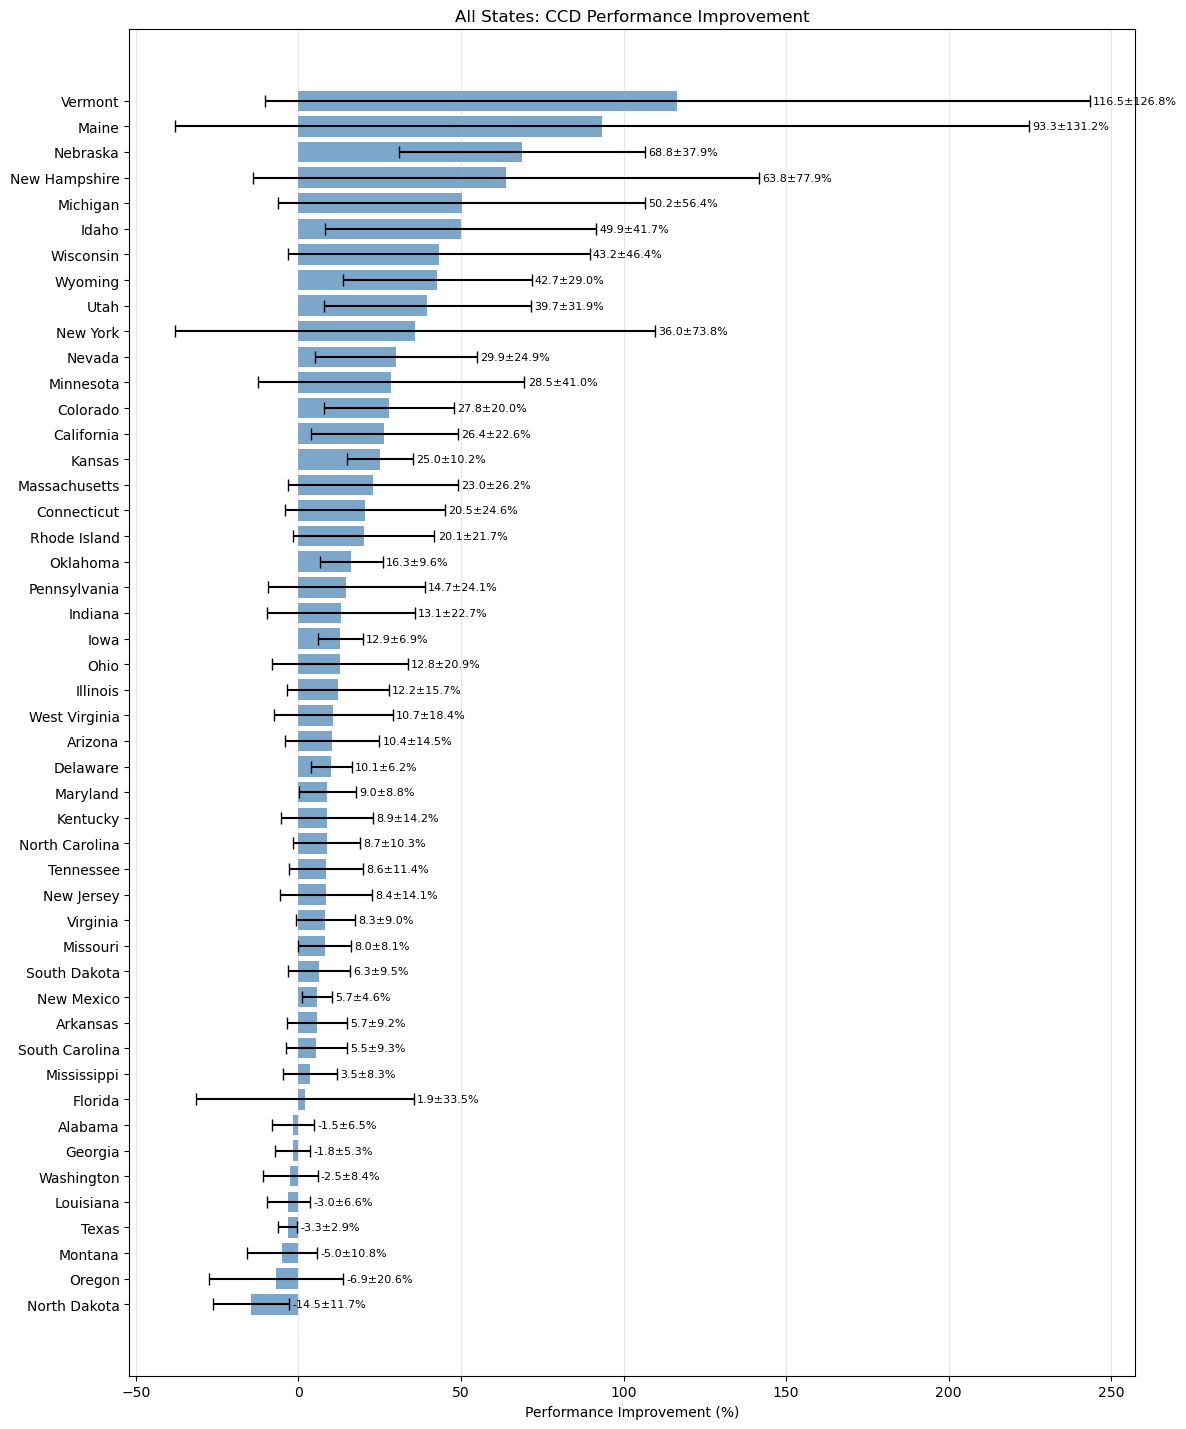

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def calculate_state_ccd_performance_improvement_and_merge(csv_path, state_analysis_path='data/US_data/state_level_analysis.csv', output_dir='data/US_data/US_analysis_reslut'):
    """
    计算各州CCD方案的性能提升，并合并到现有的state_level_analysis.csv中
    
    参数:
    - csv_path: 州级积分分析结果CSV文件路径
    - state_analysis_path: 现有州级分析CSV文件路径
    - output_dir: 输出目录
    
    返回:
    - 合并后的DataFrame
    """
    print("=== 开始计算各州CCD方案性能提升并合并到现有数据 ===")
    
    # 1. 读取现有州级分析数据
    print("正在读取现有州级分析数据...")
    try:
        state_analysis_df = pd.read_csv(state_analysis_path)
        print(f"现有数据形状: {state_analysis_df.shape}")
        print(f"现有数据列: {list(state_analysis_df.columns)}")
        
        # 检查是否已经包含WCCD列
        wccd_columns = ['Environmental_improvement_mean', 'Emission_improvement_mean', 'Economic_improvement_mean',
                       'Environmental_improvement_std', 'Emission_improvement_std', 'Economic_improvement_std',
                       'Overall_improvement_mean', 'Overall_improvement_std']
        
        existing_wccd_columns = [col for col in wccd_columns if col in state_analysis_df.columns]
        if existing_wccd_columns:
            print(f"发现已存在的WCCD列: {existing_wccd_columns}")
            print("将覆盖这些列...")
            # 删除已存在的WCCD列
            state_analysis_df = state_analysis_df.drop(columns=existing_wccd_columns)
            print(f"删除WCCD列后数据形状: {state_analysis_df.shape}")
        
    except FileNotFoundError:
        print(f"错误: 找不到文件 {state_analysis_path}")
        return None, None, None
    
    # 2. 读取积分分析数据
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        return None, None, None
    
    # 3. 定义三个维度
    dimensions = ['Environmental_sustainability', 'Emission_mitigation_ability', 'Economic_feasibility']
    
    # 4. 计算各州CCD性能提升
    state_performance_results = {}
    
    for state_name in df['State_name'].unique():
        print(f"\n正在处理州: {state_name}")
        
        # 获取该州的数据
        state_data = df[df['State_name'] == state_name].copy()
        
        if len(state_data) != 4:  # 应该有4种排序方案
            print(f"  警告: {state_name} 数据不完整，跳过")
            continue
        
        # 计算该州CCD相对于其他方案的性能提升
        state_improvements = {}
        state_std_errors = {}
        
        for dimension in dimensions:
            print(f"  处理维度: {dimension}")
            
            # 获取CCD和其他方案的值
            ccd_value = state_data[state_data['Solution_Type'] == 'WCCD'][dimension].iloc[0]
            other_values = {}
            
            for solution_type in ['Environmental', 'Emission_mitigation', 'Economic']:
                if solution_type in state_data['Solution_Type'].values:
                    other_values[solution_type] = state_data[state_data['Solution_Type'] == solution_type][dimension].iloc[0]
            
            # 计算性能提升
            improvements = []
            for other_name, other_value in other_values.items():
                if other_value != 0:
                    improvement = (ccd_value - other_value) / abs(other_value) * 100
                    improvements.append(improvement)
                    print(f"    CCD vs {other_name}: {improvement:+.2f}%")
                else:
                    print(f"    CCD vs {other_name}: 无法计算（分母为0）")
            
            if improvements:
                # 计算平均提升和标准误
                mean_improvement = np.mean(improvements)  
                std_improvement = np.std(improvements, ddof=1)
                std_error = std_improvement / np.sqrt(len(improvements))
                
                state_improvements[dimension] = mean_improvement
                state_std_errors[dimension] = std_error
                
                print(f"    平均提升: {mean_improvement:+.2f}% ± {std_error:.2f}%")
            else:
                state_improvements[dimension] = 0
                state_std_errors[dimension] = 0
                print(f"    无法计算性能提升")
        
        # 存储该州的结果
        state_performance_results[state_name] = {
            'improvements': state_improvements,
            'std_errors': state_std_errors
        }
    
    # 5. 计算各州总体性能提升（考虑误差传播）
    print(f"\n=== 计算各州总体性能提升（考虑误差传播）===")
    
    state_overall_results = {}
    
    for state_name, state_data in state_performance_results.items():
        print(f"\n处理州: {state_name}")
        
        # 收集有效数据
        valid_data = []
        for dimension in dimensions:
            if state_data['improvements'][dimension] != 0:
                valid_data.append({
                    'dimension': dimension,
                    'improvement': state_data['improvements'][dimension],
                    'std_error': state_data['std_errors'][dimension]
                })
        
        if not valid_data:
            print(f"  没有有效的性能提升数据")
            state_overall_results[state_name] = None
            continue
        
        # 使用误差传播理论计算总体性能提升
        n_dimensions = len(valid_data)
        overall_mean = np.mean([data['improvement'] for data in valid_data])
        
        # 误差传播公式: σ_total = sqrt(Σ(σ_i²) / n²)
        squared_std_errors = [data['std_error']**2 for data in valid_data]
        overall_variance = np.sum(squared_std_errors) / (n_dimensions**2)
        overall_std_error = np.sqrt(overall_variance)
        
        # 计算95%置信区间
        overall_ci_95 = 1.96 * overall_std_error
        overall_cv = (overall_std_error / abs(overall_mean) * 100) if overall_mean != 0 else 0
        
        print(f"  维度数量: {n_dimensions}")
        print("  各维度标准误:", [f"{data['std_error']:.4f}" for data in valid_data])
        print(f"  总体均值: {overall_mean:+.2f}%")
        print(f"  总体标准误: ±{overall_std_error:.2f}%")
        print(f"  95%置信区间: [{overall_mean - overall_ci_95:.2f}%, {overall_mean + overall_ci_95:.2f}%]")
        print(f"  变异系数: {overall_cv:.2f}%")
        
        state_overall_results[state_name] = {
            'overall_mean': overall_mean,
            'overall_std_error': overall_std_error,
            'overall_ci_95': overall_ci_95,
            'overall_cv': overall_cv,
            'n_dimensions': n_dimensions,
            'dimension_details': valid_data
        }
    
    # 6. 创建WCCD性能提升数据（9个列）
    print(f"\n=== 创建WCCD性能提升数据（9个列）===")
    
    wccd_data = []
    for state_name, result in state_overall_results.items():
        if result is not None:
            wccd_data.append({
                'State_name': state_name,
                # 各维度性能提升均值
                'Environmental_improvement_mean': state_performance_results[state_name]['improvements']['Environmental_sustainability'],
                'Emission_improvement_mean': state_performance_results[state_name]['improvements']['Emission_mitigation_ability'],
                'Economic_improvement_mean': state_performance_results[state_name]['improvements']['Economic_feasibility'],
                # 各维度标准误
                'Environmental_improvement_std': state_performance_results[state_name]['std_errors']['Environmental_sustainability'],
                'Emission_improvement_std': state_performance_results[state_name]['std_errors']['Emission_mitigation_ability'],
                'Economic_improvement_std': state_performance_results[state_name]['std_errors']['Economic_feasibility'],
                # 总体性能提升
                'Overall_improvement_mean': result['overall_mean'],
                'Overall_improvement_std': result['overall_std_error']
            })
    
    wccd_df = pd.DataFrame(wccd_data)
    

    # 7. 合并到现有数据
    print(f"\n=== 合并数据到现有state_level_analysis.csv ===")
    # 使用State_name进行左连接
    merged_df = state_analysis_df.merge(wccd_df, on='State_name', how='left')
 
    # 8. 保存合并后的数据
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存合并后的数据
    merged_path = f'{output_dir}/state_level_analysis_with_wccd.csv'
    merged_df.to_csv(merged_path, index=False)
    print(f"合并后数据已保存到: {merged_path}")
    
    # 备份原文件并更新
    backup_path = f'{state_analysis_path}.backup'
    state_analysis_df.to_csv(backup_path, index=False)
    print(f"原文件已备份到: {backup_path}")
    
    # 更新原文件
    merged_df.to_csv(state_analysis_path, index=False)
    print(f"原文件已更新: {state_analysis_path}")
    
    # 9. 输出前10个州的结果
    if 'Overall_improvement_mean' in merged_df.columns:
        print(f"\n=== 前10个州WCCD性能提升结果 ===")
        top_10 = merged_df[merged_df['Overall_improvement_mean'].notna()].nlargest(10, 'Overall_improvement_mean')
        print(top_10[['State_name', 'Environmental_improvement_mean', 'Emission_improvement_mean', 
                      'Economic_improvement_mean', 'Overall_improvement_mean', 'Overall_improvement_std']].to_string(index=False))
    else:
        print("无法显示前10个州结果，因为缺少Overall_improvement_mean列")
    
    # 10. 绘制性能提升分布图
    if 'Overall_improvement_mean' in merged_df.columns:
        create_performance_visualization(merged_df, output_dir)
    else:
        print("跳过可视化，因为缺少必要的列")
    
    return merged_df, state_performance_results, state_overall_results

def create_performance_visualization(merged_df, output_dir):
    """
    仅绘制所有州的性能提升条形图
    """
    print(f"\n正在创建所有州性能提升条形图...")

    valid_data = merged_df[merged_df['Overall_improvement_mean'].notna()]

    # 按性能提升排序
    valid_data = valid_data.sort_values('Overall_improvement_mean', ascending=True).reset_index(drop=True)
    y_pos = np.arange(len(valid_data))

    fig, ax = plt.subplots(figsize=(12, max(8, len(valid_data) * 0.3)))
    bars = ax.barh(
        y_pos, 
        valid_data['Overall_improvement_mean'], 
        xerr=valid_data['Overall_improvement_std'], 
        capsize=4, alpha=0.7, color='steelblue'
    )

    ax.set_yticks(y_pos)
    ax.set_yticklabels(valid_data['State_name'])
    ax.set_xlabel('Performance Improvement (%)')
    ax.set_title('All States: CCD Performance Improvement')
    ax.grid(True, alpha=0.3, axis='x')

    # 添加数值标签
    for i, (mean, std) in enumerate(zip(valid_data['Overall_improvement_mean'], valid_data['Overall_improvement_std'])):
        ax.text(mean + (std if not np.isnan(std) else 0) + 1, i, f'{mean:.1f}±{std:.1f}%', va='center', fontsize=8)

    plt.tight_layout()
    bar_path = f'{output_dir}/state_level_analysis_with_wccd_all_states.png'
    plt.savefig(bar_path, dpi=300, bbox_inches='tight')
    print(f"所有州性能提升条形图已保存到: {bar_path}")
    plt.show()

# 使用示例
if __name__ == "__main__":
    csv_path = 'data/US_data/US_analysis_reslut/state_integration_analysis_simplified.csv'
    state_analysis_path = 'data/US_data/US_analysis_reslut/state_level_analysis.csv'
    merged_df, state_performance_results, state_overall_results = calculate_state_ccd_performance_improvement_and_merge(
        csv_path, 
        state_analysis_path,
        output_dir='data/US_data/US_analysis_reslut'
    )
    

## 1.6 P-value for veritfy

=== 开始CCD方案显著性分析 ===
有效州数: 48

Environmental 维度:
  平均提升: +49.22% ± 11.82%
  中位数: +27.41%
  四分位数: [+15.65%, +45.66%]
  t统计量: 4.164
  p值: 0.000132
  显著性: ***
  Cohen's d: 0.601
  95%置信区间: [+26.05%, +72.39%]

Emission Mitigation 维度:
  平均提升: +40.31% ± 11.79%
  中位数: +19.65%
  四分位数: [+8.95%, +38.23%]
  t统计量: 3.419
  p值: 0.001309
  显著性: **
  Cohen's d: 0.493
  95%置信区间: [+17.20%, +63.43%]

Economic Feasibility 维度:
  平均提升: -29.00% ± 14.93%
  中位数: -14.99%
  四分位数: [-32.09%, +19.92%]
  t统计量: -1.942
  p值: 0.058085
  显著性: ns
  Cohen's d: -0.280
  95%置信区间: [-58.26%, +0.26%]

总体性能提升:
  平均提升: +20.18% ± 25.56%
  中位数: +11.47%
  t统计量: 5.470
  p值: 0.000002
  显著性: ***
  Cohen's d: 0.790
  95%置信区间: [+12.95%, +27.41%]

=== 维度间比较分析 ===

Environmental vs Emission:
  平均差异: +8.91%
  t统计量: 7.208
  p值: 0.000000
  显著性: ***
  Cohen's d: 1.040

Environmental vs Economic:
  平均差异: +78.22%
  t统计量: 2.977
  p值: 0.004593
  显著性: **
  Cohen's d: 0.430

Emission vs Economic:
  平均差异: +69.31%
  t统计量: 2.638
  p值: 0.011275
  显著性: 

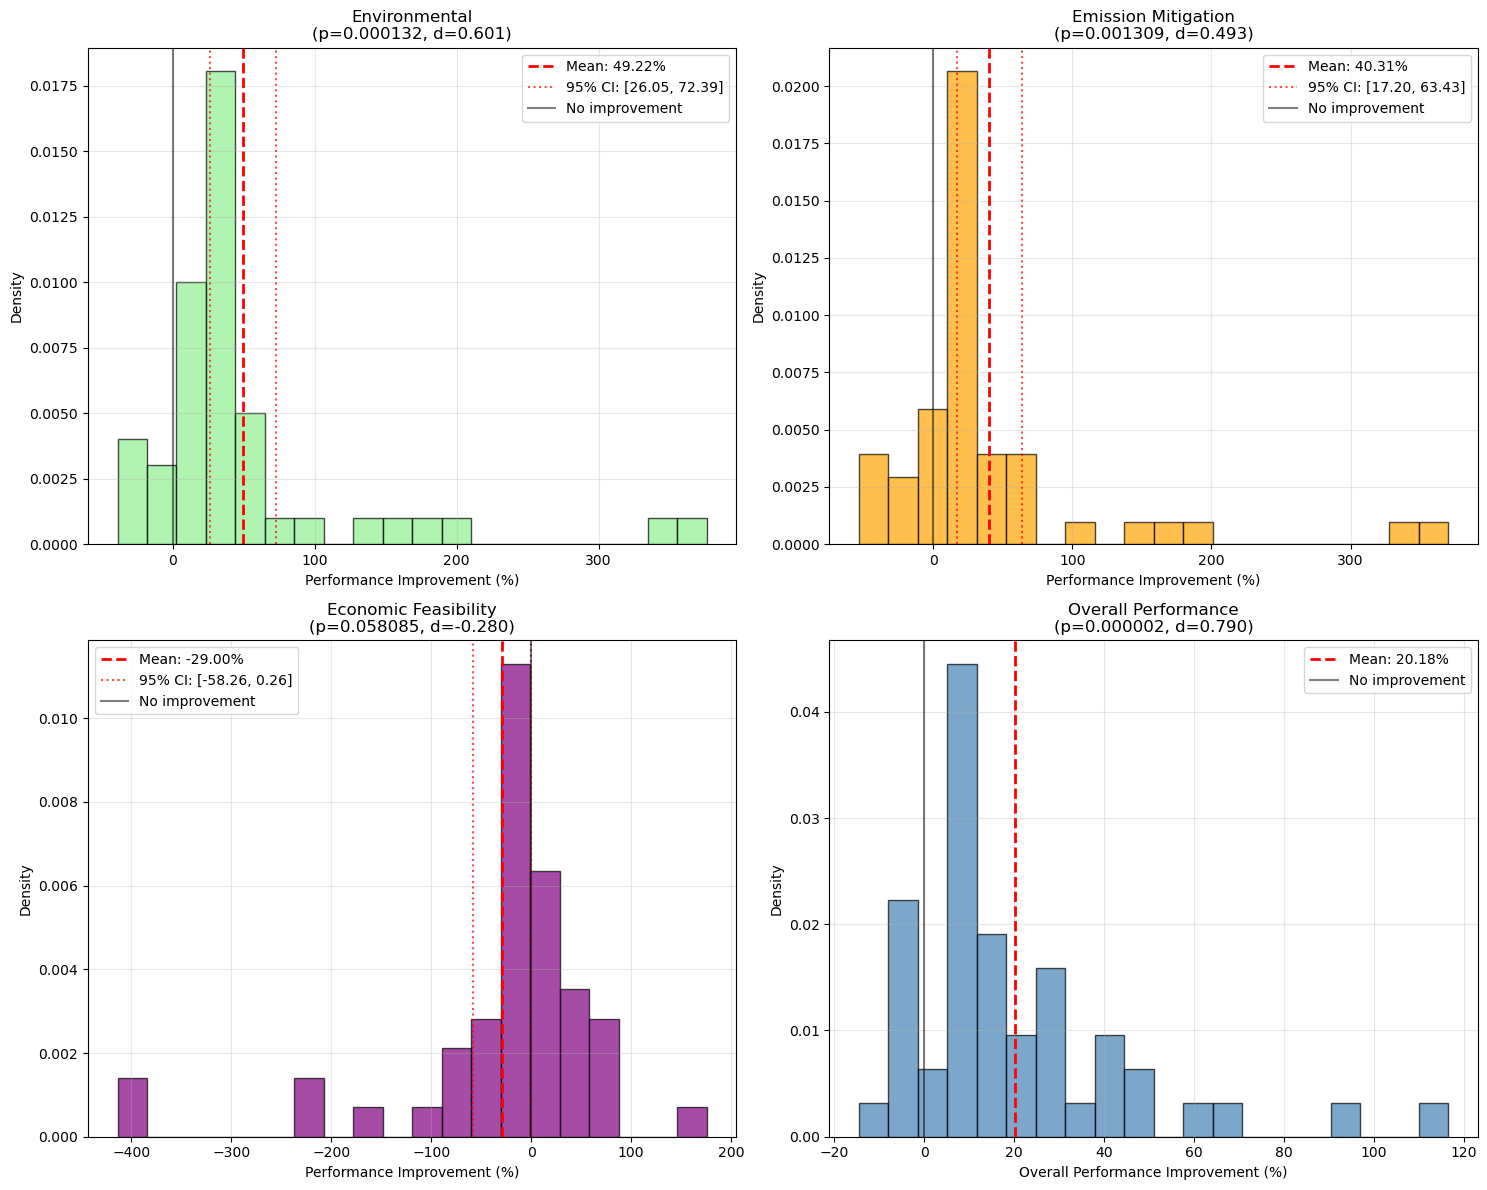

显著性对比图已保存到: data/US_data/US_analysis_reslut/ccd_significance_comparison.png


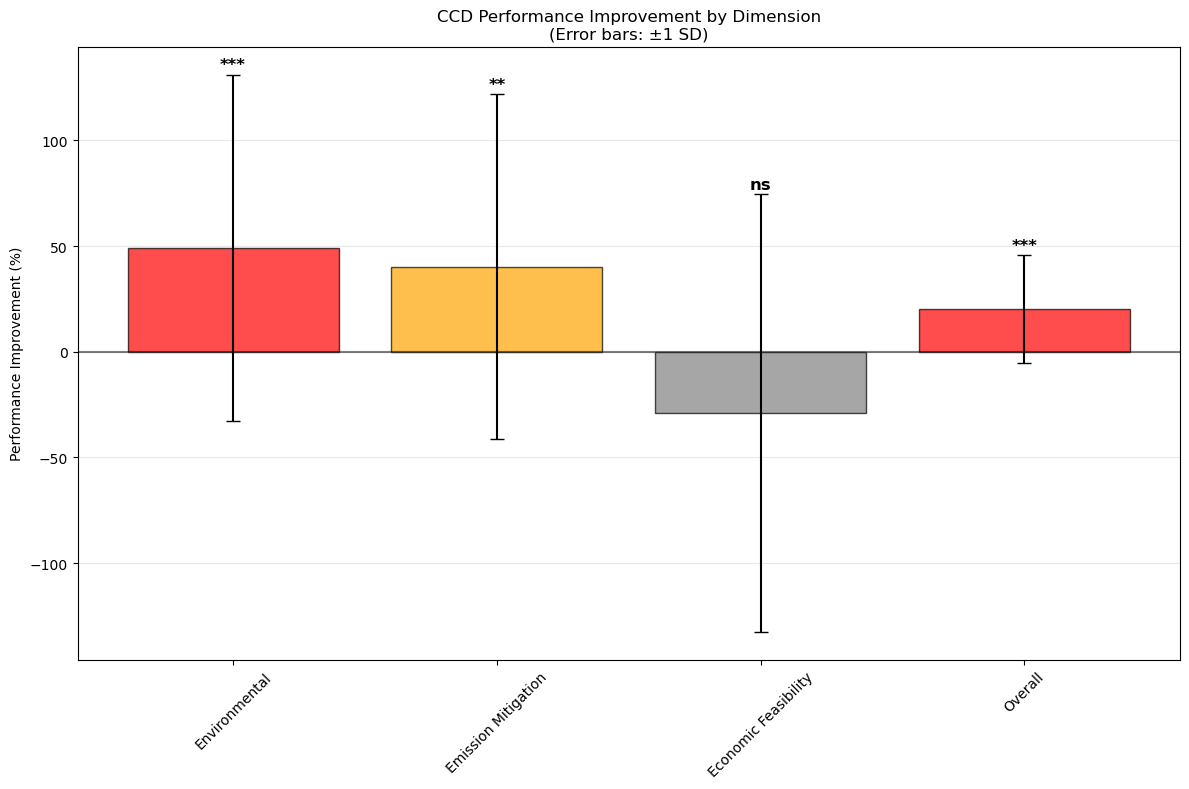

效应量对比图已保存到: data/US_data/US_analysis_reslut/ccd_effect_size_comparison.png


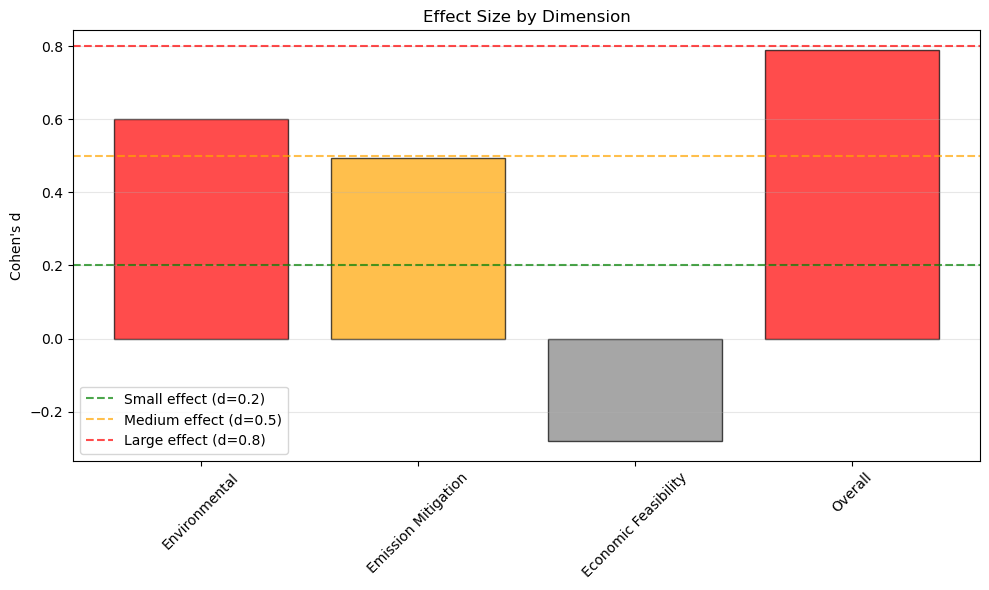

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os 
def calculate_ccd_significance_analysis(merged_df, output_dir='data/US_data/US_analysis_reslut'):
    """
    计算CCD方案在各州的平均提升和显著性水平
    
    参数:
    - merged_df: 包含WCCD性能提升数据的DataFrame
    - output_dir: 输出目录
    
    返回:
    - 显著性分析结果
    """
    print("=== 开始CCD方案显著性分析 ===")
    
    # 过滤有效数据
    valid_data = merged_df[merged_df['Overall_improvement_mean'].notna()].copy()
    
    if len(valid_data) == 0:
        print("没有有效的性能提升数据")
        return None
    
    print(f"有效州数: {len(valid_data)}")
    
    # 1. 计算各维度的平均提升和统计量
    dimensions = ['Environmental_improvement_mean', 'Emission_improvement_mean', 'Economic_improvement_mean']
    dimension_labels = ['Environmental', 'Emission Mitigation', 'Economic Feasibility']
    
    dimension_stats = {}
    
    for dim, label in zip(dimensions, dimension_labels):
        values = valid_data[dim].values
        std_values = valid_data[dim.replace('_mean', '_std')].values
        
        # 基本统计量
        mean_val = np.mean(values)
        std_val = np.std(values, ddof=1)
        median_val = np.median(values)
        q25 = np.percentile(values, 25)
        q75 = np.percentile(values, 75)
        
        
        # 单样本t检验 (检验是否显著大于0)
        t_stat, p_value = stats.ttest_1samp(values, 0)
        
        # 效应量 (Cohen's d)
        cohens_d = mean_val / std_val if std_val != 0 else 0
        
        # 置信区间
        n = len(values)
        se = std_val / np.sqrt(n)
        ci_95_lower = mean_val - 1.96 * se
        ci_95_upper = mean_val + 1.96 * se
        
        dimension_stats[dim] = {
            'label': label,
            'mean': mean_val,
            'std': std_val,
            'median': median_val,
            'q25': q25,
            'q75': q75,
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'ci_95_lower': ci_95_lower,
            'ci_95_upper': ci_95_upper,
            'n': n
        }
        
        print(f"\n{label} 维度:")
        print(f"  平均提升: {mean_val:+.2f}% ± {se:.2f}%")
        print(f"  中位数: {median_val:+.2f}%")
        print(f"  四分位数: [{q25:+.2f}%, {q75:+.2f}%]")
        print(f"  t统计量: {t_stat:.3f}")
        print(f"  p值: {p_value:.6f}")
        print(f"  显著性: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
        print(f"  Cohen's d: {cohens_d:.3f}")
        print(f"  95%置信区间: [{ci_95_lower:+.2f}%, {ci_95_upper:+.2f}%]")
    
    # 2. 总体性能提升分析
    overall_values = valid_data['Overall_improvement_mean'].values
    overall_std_values = valid_data['Overall_improvement_std'].values
    
    overall_mean = np.mean(overall_values)
    overall_std = np.std(overall_values, ddof=1)
    overall_median = np.median(overall_values)
    
    # 单样本t检验
    overall_t_stat, overall_p_value = stats.ttest_1samp(overall_values, 0)
    overall_cohens_d = overall_mean / overall_std if overall_std != 0 else 0
    
    # 置信区间
    n = len(overall_values)
    overall_se = overall_std / np.sqrt(n)
    overall_ci_95_lower = overall_mean - 1.96 * overall_se
    overall_ci_95_upper = overall_mean + 1.96 * overall_se
    
    print(f"\n总体性能提升:")
    print(f"  平均提升: {overall_mean:+.2f}% ± {overall_std:.2f}%")
    print(f"  中位数: {overall_median:+.2f}%")
    print(f"  t统计量: {overall_t_stat:.3f}")
    print(f"  p值: {overall_p_value:.6f}")
    print(f"  显著性: {'***' if overall_p_value < 0.001 else '**' if overall_p_value < 0.01 else '*' if overall_p_value < 0.05 else 'ns'}")
    print(f"  Cohen's d: {overall_cohens_d:.3f}")
    print(f"  95%置信区间: [{overall_ci_95_lower:+.2f}%, {overall_ci_95_upper:+.2f}%]")
    
    # 3. 维度间比较分析
    print(f"\n=== 维度间比较分析 ===")
    
    # 配对t检验比较各维度
    dimension_pairs = [
        ('Environmental_improvement_mean', 'Emission_improvement_mean', 'Environmental vs Emission'),
        ('Environmental_improvement_mean', 'Economic_improvement_mean', 'Environmental vs Economic'),
        ('Emission_improvement_mean', 'Economic_improvement_mean', 'Emission vs Economic')
    ]
    
    pairwise_comparisons = {}
    
    for dim1, dim2, label in dimension_pairs:
        values1 = valid_data[dim1].values
        values2 = valid_data[dim2].values
        
        # 配对t检验
        t_stat, p_value = stats.ttest_rel(values1, values2)
        
        # 效应量 (配对Cohen's d)
        diff = values1 - values2
        cohens_d = np.mean(diff) / np.std(diff, ddof=1) if np.std(diff, ddof=1) != 0 else 0
        
        pairwise_comparisons[label] = {
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'mean_diff': np.mean(diff),
            'std_diff': np.std(diff, ddof=1)
        }
        
        print(f"\n{label}:")
        print(f"  平均差异: {np.mean(diff):+.2f}%")
        print(f"  t统计量: {t_stat:.3f}")
        print(f"  p值: {p_value:.6f}")
        print(f"  显著性: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
        print(f"  Cohen's d: {cohens_d:.3f}")
    
    # 4. 创建结果汇总表
    results_summary = []
    
    # 各维度结果
    for dim, stats_dict in dimension_stats.items():
        results_summary.append({
            'Dimension': stats_dict['label'],
            'Mean_Improvement': stats_dict['mean'],
            'Std_Improvement': stats_dict['std'],
            'Median_Improvement': stats_dict['median'],
            'T_Statistic': stats_dict['t_stat'],
            'P_Value': stats_dict['p_value'],
            'Significance': '***' if stats_dict['p_value'] < 0.001 else '**' if stats_dict['p_value'] < 0.01 else '*' if stats_dict['p_value'] < 0.05 else 'ns',
            'Cohens_D': stats_dict['cohens_d'],
            'CI_95_Lower': stats_dict['ci_95_lower'],
            'CI_95_Upper': stats_dict['ci_95_upper'],
            'Sample_Size': stats_dict['n']
        })
    
    # 总体结果
    results_summary.append({
        'Dimension': 'Overall',
        'Mean_Improvement': overall_mean,
        'Std_Improvement': overall_std,
        'Median_Improvement': overall_median,
        'T_Statistic': overall_t_stat,
        'P_Value': overall_p_value,
        'Significance': '***' if overall_p_value < 0.001 else '**' if overall_p_value < 0.01 else '*' if overall_p_value < 0.05 else 'ns',
        'Cohens_D': overall_cohens_d,
        'CI_95_Lower': overall_ci_95_lower,
        'CI_95_Upper': overall_ci_95_upper,
        'Sample_Size': n
    })
    
    results_df = pd.DataFrame(results_summary)
    
    # 5. 保存结果
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存显著性分析结果
    significance_path = f'{output_dir}/ccd_significance_analysis.csv'
    results_df.to_csv(significance_path, index=False)
    print(f"\n显著性分析结果已保存到: {significance_path}")
    
    # 6. 创建可视化图表
    create_significance_visualizations(valid_data, dimension_stats, overall_mean, overall_std, 
                                     overall_t_stat, overall_p_value, output_dir)
    
    return {
        'dimension_stats': dimension_stats,
        'overall_stats': {
            'mean': overall_mean,
            'std': overall_std,
            't_stat': overall_t_stat,
            'p_value': overall_p_value,
            'cohens_d': overall_cohens_d
        },
        'pairwise_comparisons': pairwise_comparisons,
        'results_df': results_df
    }

def create_significance_visualizations(valid_data, dimension_stats, overall_mean, overall_std, 
                                     overall_t_stat, overall_p_value, output_dir):
    """
    创建显著性分析可视化图表
    """
    print(f"\n正在创建显著性分析可视化图表...")
    
    # 1. 各维度性能提升分布图
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    dimensions = ['Environmental_improvement_mean', 'Emission_improvement_mean', 'Economic_improvement_mean']
    dimension_labels = ['Environmental', 'Emission Mitigation', 'Economic Feasibility']
    colors = ['lightgreen', 'orange', 'purple']
    
    # 各维度分布
    for i, (dim, label, color) in enumerate(zip(dimensions, dimension_labels, colors)):
        ax = axes[i//2, i%2]
        values = valid_data[dim].values
        
        # 直方图
        ax.hist(values, bins=20, alpha=0.7, color=color, edgecolor='black', density=True)
        
        # 添加均值和置信区间
        mean_val = dimension_stats[dim]['mean']
        ci_lower = dimension_stats[dim]['ci_95_lower']
        ci_upper = dimension_stats[dim]['ci_95_upper']
        
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}%')
        ax.axvline(ci_lower, color='red', linestyle=':', alpha=0.7, label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
        ax.axvline(ci_upper, color='red', linestyle=':', alpha=0.7)
        ax.axvline(0, color='black', linestyle='-', alpha=0.5, label='No improvement')
        
        ax.set_xlabel('Performance Improvement (%)')
        ax.set_ylabel('Density')
        ax.set_title(f'{label}\n(p={dimension_stats[dim]["p_value"]:.6f}, d={dimension_stats[dim]["cohens_d"]:.3f})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 总体分布
    ax = axes[1, 1]
    overall_values = valid_data['Overall_improvement_mean'].values
    ax.hist(overall_values, bins=20, alpha=0.7, color='steelblue', edgecolor='black', density=True)
    
    ax.axvline(overall_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {overall_mean:.2f}%')
    ax.axvline(0, color='black', linestyle='-', alpha=0.5, label='No improvement')
    
    ax.set_xlabel('Overall Performance Improvement (%)')
    ax.set_ylabel('Density')
    ax.set_title(f'Overall Performance\n(p={overall_p_value:.6f}, d={overall_mean/overall_std:.3f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 保存图表
    dist_path = f'{output_dir}/ccd_significance_distributions.png'
    plt.savefig(dist_path, dpi=300, bbox_inches='tight')
    print(f"分布图已保存到: {dist_path}")
    plt.show()
    
    # 2. 显著性水平对比图
    fig, ax = plt.subplots(figsize=(12, 8))
    
    dimensions = ['Environmental', 'Emission Mitigation', 'Economic Feasibility', 'Overall']
    means = [dimension_stats['Environmental_improvement_mean']['mean'],
             dimension_stats['Emission_improvement_mean']['mean'],
             dimension_stats['Economic_improvement_mean']['mean'],
             overall_mean]
    stds = [dimension_stats['Environmental_improvement_mean']['std'],
            dimension_stats['Emission_improvement_mean']['std'],
            dimension_stats['Economic_improvement_mean']['std'],
            overall_std]
    p_values = [dimension_stats['Environmental_improvement_mean']['p_value'],
                dimension_stats['Emission_improvement_mean']['p_value'],
                dimension_stats['Economic_improvement_mean']['p_value'],
                overall_p_value]
    
    # 颜色根据显著性水平
    colors = ['red' if p < 0.001 else 'orange' if p < 0.01 else 'yellow' if p < 0.05 else 'gray' for p in p_values]
    
    bars = ax.bar(dimensions, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black')
    
    # 添加显著性标记
    for i, (bar, p_val) in enumerate(zip(bars, p_values)):
        height = bar.get_height()
        significance = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        ax.text(bar.get_x() + bar.get_width()/2, height + stds[i] + 1, significance, 
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Performance Improvement (%)')
    ax.set_title('CCD Performance Improvement by Dimension\n(Error bars: ±1 SD)')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 添加水平线表示无提升
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 保存图表
    sig_path = f'{output_dir}/ccd_significance_comparison.png'
    plt.savefig(sig_path, dpi=300, bbox_inches='tight')
    print(f"显著性对比图已保存到: {sig_path}")
    plt.show()
    
    # 3. 效应量对比图
    fig, ax = plt.subplots(figsize=(10, 6))
    
    cohens_ds = [dimension_stats['Environmental_improvement_mean']['cohens_d'],
                 dimension_stats['Emission_improvement_mean']['cohens_d'],
                 dimension_stats['Economic_improvement_mean']['cohens_d'],
                 overall_mean/overall_std]
    
    bars = ax.bar(dimensions, cohens_ds, color=colors, alpha=0.7, edgecolor='black')
    
    # 添加效应量解释
    ax.axhline(y=0.2, color='green', linestyle='--', alpha=0.7, label='Small effect (d=0.2)')
    ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium effect (d=0.5)')
    ax.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Large effect (d=0.8)')
    
    ax.set_ylabel("Cohen's d")
    ax.set_title("Effect Size by Dimension")
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 保存图表
    effect_path = f'{output_dir}/ccd_effect_size_comparison.png'
    plt.savefig(effect_path, dpi=300, bbox_inches='tight')
    print(f"效应量对比图已保存到: {effect_path}")
    plt.show()

# 使用示例
if __name__ == "__main__":
    merged_df = pd.read_csv('data/US_data/US_analysis_reslut/state_level_analysis_with_wccd.csv')
    significance_results = calculate_ccd_significance_analysis(merged_df)

# 2 Plot for each state 

最终考虑选择5个州，分别是alifornia, Texas, Utah, Indiana, and Michigan. 



思考为什么要case study: 本质上是为了部署PV，给出针对性的建议。这种针对性体现在哪里，体现在各个州的差异、特色

我们从什么角度去说这个difference，核心是从CCD的差异，以及造成这个差异背后的原因和社会经济的context因素；


Logic: 

1、首先提取各个州CCD Mean, 


In [2]:
import numpy as np 
import pandas as pd 

state_analysis_df = pd.read_csv('data/US_data/US_analysis_reslut/state_level_analysis_with_wccd.csv')

In [3]:
state_analysis_df.nlargest(15, 'CCD_Mean').query('abandoned_land_ha > 100000')

,State_name,abandoned_land_ha,Environmental_suitability_per_ha,Emission_mitigation_per_ha,Economic_NPV_per_ha,Power_generation_per_ha,CCD_Mean,Environmental_improvement_mean,Emission_improvement_mean,Economic_improvement_mean,Environmental_improvement_std,Emission_improvement_std,Economic_improvement_std,Overall_improvement_mean,Overall_improvement_std
12,Colorado,108304.7666,0.6297,7512.6966,786865.9129,177956778.3,0.9280,31.104977,27.168781,25.259611,27.025844,38.433371,37.234951,27.844456,19.983220
2,California,271672.0489,0.5379,7481.2128,770496.9652,185249875.8,0.9144,27.561801,26.579265,24.956956,29.198060,44.079529,42.533005,26.366008,22.619038
15,Utah,100148.1546,0.4338,7511.3120,827177.8094,177488263.3,0.8953,43.336025,38.552370,37.105109,42.906146,60.684195,60.078435,39.664502,31.855450
3,Georgia,244587.2796,0.9510,6426.1686,-45315.8133,168911325.7,0.8893,2.485510,1.240349,-8.983364,8.219952,7.602291,11.407132,-1.752502,5.327967
0,Texas,515459.2186,0.7860,6722.3459,262293.9622,180696201.5,0.8826,-3.699903,-9.495149,3.429235,1.523835,4.495157,7.276752,-3.255272,2.895967
6,North Carolina,167767.8295,0.9584,6181.1629,-203370.5206,157270973.6,0.8799,27.536621,24.724620,-26.284204,18.381513,17.043151,18.134924,8.659012,10.313015
13,Mississippi,103433.1543,0.9417,6255.1614,-179665.4841,161636027.6,0.8787,12.675943,10.188595,-12.266580,14.809523,13.603226,14.864624,3.532653,8.335512


In [4]:
state_analysis_df

,State_name,abandoned_land_ha,Environmental_suitability_per_ha,Emission_mitigation_per_ha,Economic_NPV_per_ha,Power_generation_per_ha,CCD_Mean,Environmental_improvement_mean,Emission_improvement_mean,Economic_improvement_mean,Environmental_improvement_std,Emission_improvement_std,Economic_improvement_std,Overall_improvement_mean,Overall_improvement_std
0,Texas,515459.2186,0.7860,6722.3459,2.622940e+05,180696201.5,0.8826,-3.699903,-9.495149,3.429235,1.523835,4.495157,7.276752,-3.255272,2.895967
1,Illinois,291941.0631,0.8573,5763.0992,-5.270713e+05,137820848.3,0.7774,35.019446,25.367045,-23.765393,29.542992,25.779524,25.834595,12.207033,15.651761
2,California,271672.0489,0.5379,7481.2128,7.704970e+05,185249875.8,0.9144,27.561801,26.579265,24.956956,29.198060,44.079529,42.533005,26.366008,22.619038
3,Georgia,244587.2796,0.9510,6426.1686,-4.531581e+04,168911325.7,0.8893,2.485510,1.240349,-8.983364,8.219952,7.602291,11.407132,-1.752502,5.327967
4,Indiana,219739.8319,0.8795,5644.3213,-6.056357e+05,135997068.2,0.7689,41.667116,29.596884,-32.081380,42.199202,36.642265,38.682791,13.060873,22.656337
5,Michigan,169962.5463,0.9372,5429.4125,-7.509910e+05,126439654.0,0.7608,156.786967,143.172703,-149.349102,100.617661,94.153905,97.934601,50.203523,56.352125
6,North Carolina,167767.8295,0.9584,6181.1629,-2.033705e+05,157270973.6,0.8799,27.536621,24.724620,-26.284204,18.381513,17.043151,18.134924,8.659012,10.313015
7,Wisconsin,156027.1466,0.8202,5484.7251,-7.353759e+05,124775703.5,0.7162,135.749808,100.329986,-106.582233,90.057547,73.363085,76.637041,43.165853,46.386947
8,Ohio,152707.5281,0.8538,5611.4598,-6.101525e+05,135115494.8,0.7544,40.733888,24.784122,-27.250085,40.188972,32.954591,34.845317,12.755975,20.857598
9,Florida,151815.8627,0.4050,6098.5117,1.205917e+03,177792992.2,0.7648,-32.065482,-39.589385,77.492461,6.951733,16.429563,98.822539,1.945865,33.473292


### 2.1 协变量与LCZ加载

In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os

# 加入州的点数据、统计数据与协变量数据
merged_data_for_analysis = pd.read_csv('data/US_data/df_merged_data_for_analysis.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
state_analysis_df = pd.read_csv('data/US_data/US_analysis_reslut/state_level_analysis_with_wccd.csv')

# 检查df_zones.csv文件路径，支持正斜杠和反斜杠两种写法
climate_zone_path1 = 'data/US_data/df_zones.csv'
climate_zone_path2 = r'data\US_data\df_zones.csv'

if os.path.exists(climate_zone_path1):
    df_climate_zone = pd.read_csv(climate_zone_path1)
elif os.path.exists(climate_zone_path2):
    df_climate_zone = pd.read_csv(climate_zone_path2)
else:
    raise FileNotFoundError(f"未找到df_zones.csv文件。尝试的路径: {climate_zone_path1} 和 {climate_zone_path2}")

# 加入地理数据
us_states = gpd.read_file(r'data/cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')

us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

print("正在添加州标签...")
geometry = [Point(xy) for xy in zip(merged_data_for_analysis['lon'], merged_data_for_analysis['lat'])]
pixel_gdf = gpd.GeoDataFrame(merged_data_for_analysis, geometry=geometry, crs='EPSG:4326')
pixel_with_states = gpd.sjoin(pixel_gdf, us_states_4326, how='left', predicate='within')
data_with_states = pixel_with_states.drop(columns=['geometry']).copy()

# 加入气候模式
print("8. 气候区域匹配...")

state_climate_map = dict(zip(df_climate_zone['State'], df_climate_zone['BA Climate Zone']))

# 气候区域合并映射
climate_merge_map = {
    'Hot-Dry': 'Dry', 'Mixed-Dry': 'Dry',
    'Cold': 'Cold', 'Very Cold': 'Cold',
    'Hot-Humid': 'Humid', 'Mixed-Humid': 'Humid',
    'Marine': 'Marine', 'Subarctic': 'Subarctic'
}

# 向量化气候区域匹配
data_with_states['climate_zone'] = data_with_states['STUSPS'].map(state_climate_map)
data_with_states['climate_zone_merged'] = data_with_states['climate_zone'].map(climate_merge_map)

正在添加州标签...
8. 气候区域匹配...


In [6]:
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')
# 从df_net_benefit挑选协变量并与data_with_states合并
covariates = ['GDPpc', 'GDPtot', 'Population', 'Powerdist', 'DEM', 'Slope', 
              'GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 
              'tas', 'gdmp', 'rsds', 'wind', 'landcover']

df_covariates = df_net_benefit[['lat', 'lon'] + covariates]

data_for_varaiable = data_with_states.merge(df_covariates, on=['lat', 'lon'], how='left')

# cali_data_for_regression=data_for_varaiable[data_for_varaiable['NAME'] == 'California']
# Texas_data_for_regression=data_for_varaiable[data_for_varaiable['NAME'] == 'Texas']
# Michigan_data_for_regression=data_for_varaiable[data_for_varaiable['NAME'] == 'Michigan']

decision = ['optimal_weight_economic','optimal_weight_environmental','optimal_weight_emission']
df_decision = df_pixel_optimized_data[['lat', 'lon'] + decision]

data_for_regression=data_for_varaiable.merge(df_decision, on=['lat', 'lon'], how='left')

In [7]:
data_for_regression.columns

Index(['lat', 'lon', 'predicted_prob', 'gmm_density', 'sample_type',
       'Expectation_net_benefit', 'pv_potential_dens', 'LNCS_expect',
       'net_npv_usd', 'area_m2', 'E_yr_pixel', 'pv_potential_total(t)',
       'power_generation_kwha', 'Expectation_net_benefit_adjust',
       'ccd_optimized', 'index_right', 'STATEFP', 'STATENS', 'AFFGEOID',
       'GEOID', 'STUSPS', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'climate_zone',
       'climate_zone_merged', 'GDPpc', 'GDPtot', 'Population', 'Powerdist',
       'DEM', 'Slope', 'GURdist', 'PrimaryRoad', 'SecondaryRoad',
       'TertiaryRoad', 'tas', 'gdmp', 'rsds', 'wind', 'landcover',
       'optimal_weight_economic', 'optimal_weight_environmental',
       'optimal_weight_emission'],
      dtype='object')

In [8]:
data_for_regression['climate_zone_merged']

0        Humid
1        Humid
2        Humid
3        Humid
4        Humid
         ...  
64977     Cold
64978     Cold
64979     Cold
64980     Cold
64981     Cold
Name: climate_zone_merged, Length: 64982, dtype: object

## 2.2 OLS回归


核心任务：我已经证明了按照各个州进行PV部署的可行性（也就是优先实施），接下来我需要归纳这些'CCD_Mean' 较高的州、以及我感兴趣州的各个pixel中'ccd_optimized'对应的自然与社会经济特征。


原始数据：data_for_regression 

输入数据：
├── target dependent variables for state  
| Variable name      | 说明               | 计算逻辑                       |
|--------------------|--------------------|-------------------------------|
| ccd_optimized      | Pixel级别变量       | 过滤完数据后，从data_for_regression获取   |
| CCD_Mean      |  州层面需要需要取First      | 过滤完数据后，从data_for_regression获取   |



├── target independent variables for both State-Level Analysis and Target State Pixel-level Analysis
| Variable name      | 说明               | 计算逻辑                       |
|--------------------|--------------------|-------------------------------|
| Population         | Pixel级别变量、州层面需要聚合Mean       | 从data_for_regression获取，state anlysis 需要按照'NAME' 取Mean          |
| GDPtot             | Pixel级别变量、州层面需要聚合Mean       | 从data_for_regression获取，state anlysis 需要按照'NAME' 取Mean            |
| rsds               | Pixel级别变量 、州层面需要聚合Mean      | 从data_for_regression获取 ，state anlysis 需要按照'NAME' 取Mean           |
| gdmp               | Pixel级别变量 、州层面需要聚合Mean      | 从data_for_regression获取 ，state anlysis 需要按照'NAME' 取Mean           |
| Slope              | Pixel级别变量  、州层面需要聚合Mean     | 从data_for_regression获取  ，state anlysis 需要按照'NAME' 取Mean          |
| tas                | Pixel级别变量   、州层面需要聚合Mean    | 从data_for_regression获取  ，state anlysis 需要按照'NAME' 取Mean          |
| GURdist            | Pixel级别变量 、州层面需要聚合Mean      | 从data_for_regression获取 ，state anlysis 需要按照'NAME' 取Mean           |
| DEM                | Pixel级别变量   、州层面需要聚合Mean    | 从data_for_regression获取  ，state anlysis 需要按照'NAME' 取Mean          |
| Powerdist          | Pixel级别变量 、州层面需要聚合Mean      | 从data_for_regression获取  ，state anlysis 需要按照'NAME' 取Mean          |
| GDPpc              | Pixel级别变量  、州层面需要聚合Mean     | 从data_for_regression获取  ，state anlysis 需要按照'NAME' 取Mean          |
| PrimaryRoad        | Pixel级别变量 、州层面需要聚合Mean      | 从data_for_regression获取  ，state anlysis 需要按照'NAME' 取Mean          |
| SecondaryRoad      | Pixel级别变量 、州层面需要聚合Mean      | 从data_for_regression获取  ，state anlysis 需要按照'NAME' 取Mean          |
| TertiaryRoad       | Pixel级别变量 、州层面需要聚合Mean      | 从data_for_regression获取  ，state anlysis 需要按照'NAME' 取Mean          |


输出结果（尽可能精简输出的csv）：
```
├── Multi-model State-level anlysis.csv （多模型的回归结果结果、以及R²、adjust R²、共线性、参数t显著性检验等诊断结果）
├── Multi-model Target state pixel-level anlysis.csv （多模型的回归结果结果、以及R²、adjust R²、共线性、参数t显著性检验等诊断结果）


```
```
Analysis Workflow
├── Data Filtering
│   └── Subset required samples and fields from raw data
├── Dataset Diagnosis
│   └── Diagnose target variable and features in data_for_regression (distribution, skewness, missingness, outliers)
├── State-Level Analysis
│   ├── X/Y Transformation
│   │   └── Apply recommended transformations separately to X and Y
│   ├── Run State-Level Analysis (48 states)
│   ├── Run all models (univariate OLS and multivariate regressions)
│   │   ├── Compare models (R², Adj-R², AIC/BIC, robust SE)
│   │   └── Create result tables for each model (R², p-value, etc.)
├── Target State Pixel-level Analysis
│   ├── X/Y Transformation
│   │   └── Apply the same transformations to ensure consistency
│   └── Run Within-State Analysis
│   │   └── Run all models and report metrics (pseudo-R², RMSE, spatial-block CV)
│   │   ├── Compare models (R², Adj-R², AIC/BIC, robust SE)
│   │   └── Create result tables for each model (R², p-value, etc.)

```


存储结构：
data\US_data\US_regression下分别创建State-level 和 Target pixel 两个

预期目标：主要揭示targer state的那些州内部高协同的sites自然与社会经济特征。在此前，我已经在48个state-level和5个target state的pixel进行了一元OLS估计，发现R²普遍较低，这一发现揭示了因此可能需要对于x或者y数据进行box-cox transformation等数据变换、以及不同区域之间可能存在异质性或者非线性关系，使得这种某些复杂关系难以被探测。第二，在使用OLS在target state进行pixel-level分析时，发现某些因素例如DEM等呈现较强的区域异质性。

我个人期望的结果：在48个州的层面，人口相对活跃、经济发达、光热资源丰富的州，拥有相对更高的'CCD_Mean' ，但是在target_states内部，可能是经济相对较弱、人口稀疏的地方，拥有相对更高的'CCD_Mean'

In [9]:
data_for_regression

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,pv_potential_dens,LNCS_expect,net_npv_usd,area_m2,...,SecondaryRoad,TertiaryRoad,tas,gdmp,rsds,wind,landcover,optimal_weight_economic,optimal_weight_environmental,optimal_weight_emission
0,25.295834,-80.287500,0.000000,3.874315e+16,negative_sample,6382.303639,7191.865919,809.562299,407275.912577,776295.361002,...,29.431436,39.441669,2987.590298,31.232273,18.758120,2.990226,6.0,1.000000e+00,0.000000e+00,8.326673e-16
1,25.437500,-80.537500,0.046746,2.054387e+18,prediction,5690.624063,7035.368191,1344.744161,283953.326746,775385.854124,...,14.789563,132.924718,2985.583309,113.500992,18.334452,2.884311,2.0,1.000000e+00,0.000000e+00,1.665335e-16
2,25.437500,-80.495834,0.000000,4.247702e+15,negative_sample,6055.300591,7024.124059,968.823440,275019.106094,775385.854124,...,29.431436,246.035315,2985.750001,82.909660,18.360788,2.513056,4.0,1.000000e+00,1.942890e-16,1.665335e-16
3,25.445833,-80.454170,0.000000,1.117299e+13,negative_sample,6048.645138,7017.640780,968.995616,269947.631894,775332.207938,...,29.431436,246.035315,2985.916666,76.517670,18.370054,2.343564,6.0,1.000000e+00,0.000000e+00,4.440892e-16
4,25.445833,-80.404170,0.017465,4.463459e+17,prediction,6081.010322,7045.490473,964.480123,291620.314126,775332.207938,...,29.431436,246.035315,2986.247237,138.812286,18.400745,2.662231,2.0,1.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64977,48.995834,-111.970830,0.026153,1.493778e+17,prediction,6210.923349,6392.674772,181.751426,-220868.055076,563356.382622,...,7.122710,109.731567,2765.861042,29.301756,14.790164,4.719766,2.0,3.330669e-16,0.000000e+00,1.000000e+00
64978,48.995834,-110.345830,0.068266,4.120084e+17,prediction,6206.053157,6395.853979,189.800818,-219393.096487,563356.382622,...,13.194569,7.135935,2773.581983,25.767578,14.886643,4.355224,2.0,0.000000e+00,6.106227e-16,1.000000e+00
64979,48.995834,-106.020836,0.065097,3.232082e+17,prediction,6204.952188,6412.037900,207.085706,-205704.827949,563356.382622,...,7.358094,34.766665,2754.080565,44.320999,14.774909,4.574393,2.0,0.000000e+00,0.000000e+00,1.000000e+00
64980,48.995834,-104.087500,0.109234,6.627032e+21,prediction,6077.421747,6292.888713,215.466966,-300314.323514,563356.382622,...,0.959624,76.917381,2762.076335,56.668201,14.598503,4.059094,3.0,4.579670e-16,3.677614e-16,1.000000e+00


### 2.2.1 回归数据生成

In [10]:
# 选择需要的自变量和因变量
pixel_vars = [
    'Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'GURdist', 'DEM', 'Powerdist', 'GDPpc',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'
]  
dependent_vars = ['ccd_optimized']  

target_states = ['California', 'Texas', 'Utah', 'Indiana', 'Michigan']

# 检查变量是否在数据中
available_pixel_vars = [v for v in pixel_vars if v in data_for_regression.columns]
available_dependent_vars = [v for v in dependent_vars if v in data_for_regression.columns]

# 过滤目标州
if target_states:
    print(f"\n筛选出 {len(target_states)} 个目标州的数据")
    target_states_point = data_for_regression[data_for_regression['NAME'].isin(target_states)].copy()
else:
    target_states_point = data_for_regression.copy()

# 仅保留感兴趣的变量列
cols_to_keep = available_pixel_vars + available_dependent_vars + ['NAME']
cols_to_keep = [col for col in cols_to_keep if col in target_states_point.columns]
target_states_point = target_states_point[cols_to_keep]

target_states_point


筛选出 5 个目标州的数据


,Population,GDPtot,rsds,gdmp,Slope,tas,GURdist,DEM,Powerdist,GDPpc,PrimaryRoad,SecondaryRoad,TertiaryRoad,ccd_optimized,NAME
103,2116.759800,45526044.0,17.556107,102.414642,0.226355,2970.416667,625073.25,11.8750,622575.06,31640.0,104.132512,70.847548,799.566313,0.750715,Texas
107,225.092940,1984099.0,17.453040,67.597023,0.187295,2972.666667,625073.10,14.9375,622574.94,31640.0,82.943860,62.973695,842.047467,0.750120,Texas
108,35.133610,1263483.0,17.442633,71.267334,0.257970,2972.666620,625073.10,12.5000,622574.94,31640.0,68.284364,53.444536,284.468793,0.754937,Texas
109,3530.104200,80915656.0,17.441502,71.945602,0.170094,2972.084702,625073.20,9.9375,622574.94,31640.0,68.284364,53.444536,284.468793,0.824545,Texas
117,418.805360,5221007.0,17.403603,60.123665,0.183223,2971.833288,625073.10,9.9375,622574.94,31640.0,68.284364,53.444536,284.468793,0.743586,Texas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61344,7.233663,459204.0,13.466924,88.037865,1.572298,2777.653955,625057.00,413.6875,622558.80,32015.0,19.292573,2.647017,146.471051,0.789502,Michigan
61437,30.524520,1313102.0,13.717079,80.142769,0.314658,2779.913900,625057.30,263.2500,622559.10,34490.0,16.794407,6.675213,69.235438,0.795723,Michigan
61552,251.637400,14276189.0,13.799102,49.571999,0.653797,2776.666643,625058.06,239.0625,622559.90,54522.0,24.249150,19.489208,93.520025,0.766131,Michigan
61750,40.447033,1245624.0,13.506963,97.859993,0.813853,2776.261171,625057.20,293.6250,622559.00,34490.0,17.930400,6.675213,94.930938,0.785353,Michigan


In [11]:
state_attrs = ['CCD_Mean']  # 州属性  
# target_states=['California', 'Texas', 'Utah', 'Indiana', 'Michigan']
target_states=None
merged_data = data_for_regression.merge(
    state_analysis_df[['State_name'] + state_attrs],
    left_on='NAME',
    right_on='State_name',
    how='left'
)


if target_states is not None:
    print(f"\n=== 数据过滤：选择 {len(target_states)} 个州 ===")
    merged_data = merged_data[merged_data['NAME'].isin(target_states)].copy()
    print(f"过滤后数据形状: {merged_data.shape}")

# 州级数据聚合
state_aggregated = merged_data.groupby('NAME').agg({
    **{var: 'mean' for var in pixel_vars},  # pixel变量取均值
    **{attr: 'first' for attr in state_attrs},  # 州属性取第一个值，这个根据面积加权的Mean
    'ccd_optimized': 'mean'  # CCD取均值，这个是根据数据加权的Mean
}).reset_index()


state_aggregated

,NAME,Population,GDPtot,rsds,gdmp,Slope,tas,GURdist,DEM,Powerdist,GDPpc,PrimaryRoad,SecondaryRoad,TertiaryRoad,CCD_Mean,ccd_optimized
0,Alabama,68.848998,2.266910e+06,16.676381,90.752343,1.093690,2929.061091,625070.919001,111.264339,622572.741910,36500.593125,18.967124,13.363914,185.781987,0.8812,0.881040
1,Arizona,391.327151,1.239099e+07,20.826415,48.770495,0.672072,2958.509576,625061.640899,418.551843,622563.414954,46764.260369,39.356341,60.431185,603.013798,0.9312,0.931114
2,Arkansas,67.058249,2.366321e+06,15.940320,84.712556,0.646498,2903.460948,625066.706157,81.510019,622568.519692,34232.395966,18.841009,14.150055,139.613495,0.8741,0.874050
3,California,259.213389,1.279978e+07,19.321493,73.279853,3.040698,2905.980543,625056.016607,276.317638,622557.782494,58985.087287,26.733548,22.049353,279.413662,0.9144,0.913987
4,Colorado,638.404728,2.622914e+07,18.534859,54.704062,2.094894,2824.183702,625057.732831,1672.429492,622559.528347,54827.021354,42.163374,27.332752,477.865000,0.9280,0.927838
5,Connecticut,165.087416,7.767979e+06,14.233018,75.728252,0.607990,2839.004584,625065.952000,54.681250,622567.791000,72083.000000,60.388556,23.269023,490.946594,0.8124,0.812400
6,Delaware,315.178583,1.084484e+07,15.665210,97.441445,0.432542,2880.213055,625067.866950,14.410165,622569.711608,52623.699764,33.111335,23.750830,295.481658,0.8433,0.843132
7,Florida,228.634431,8.386382e+06,17.259475,101.080379,0.435534,2968.276346,625076.374940,21.328375,622578.200960,44866.175000,36.646087,21.378940,398.550994,0.7648,0.765224
8,Georgia,33.704148,8.340979e+05,16.831525,91.777187,0.740671,2935.182166,625071.881107,93.876506,622573.706498,32022.234752,16.906387,13.471354,126.814344,0.8893,0.889332
9,Idaho,430.363132,1.267674e+07,16.968841,63.693796,3.899924,2813.142767,625051.058456,1402.110408,622552.835874,42611.271773,22.210655,19.775754,229.978305,0.8099,0.808449


### 2.2.2 数据分布检查

In [12]:
# 导入所需库
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy import stats
import matplotlib.pyplot as plt

def diagnose_regression_data(
    data_for_regression,
    state_analysis_df,
    x_vars,
    y_vars_state,  
    output_dir='data/US_data/US_regression/State-level',
    enable_diagnostics=True
):
    """
    统一诊断函数：基于州级数据（48州）进行一次诊断
    
    Parameters:
    - data_for_regression: pixel级原始数据
    - state_analysis_df: 州级分析数据
    - x_vars: 自变量列表（8个）
    - y_vars_state: 州级因变量列表（如['CCD_Mean']或['CCD_Mean', 'Environmental_improvement_mean']）
    - output_dir: 输出目录
    - enable_diagnostics: 是否生成可视化
    
    Returns:
    - dict: {
        'state_aggregated_data': DataFrame（聚合后的州级数据）,
        'transformation_recommendations': dict（所有变量的变换建议，X和Y统一）,
        'descriptive_stats': DataFrame（所有变量的描述性统计）,
        'skewness_kurtosis': DataFrame（所有变量的偏度峰度）,
        'outlier_analysis': dict,
        'analysis_vars': list（所有分析的变量）,
        'skewed_vars': list（严重偏斜的变量）,
        'available_x_vars': list,
        'available_y_vars': list
      }
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    print("=" * 80)
    print("统一诊断分析（基于州级数据，48个州）")
    print("=" * 80)
    
    # ===== Step 1: 数据准备和聚合 =====
    print("\n=== Step 1: 数据准备 ===")
    
    # 确保y_vars_state是列表
    if isinstance(y_vars_state, str):
        y_vars_state = [y_vars_state]
    
    # 检查可用变量
    available_x_vars = [v for v in x_vars if v in data_for_regression.columns]
    available_y_vars = [v for v in y_vars_state if v in state_analysis_df.columns]
    
    print(f"请求的X变量({len(x_vars)}个): {x_vars}")
    print(f"可用的X变量({len(available_x_vars)}个): {available_x_vars}")
    print(f"请求的州级Y变量({len(y_vars_state)}个): {y_vars_state}")
    print(f"可用的州级Y变量({len(available_y_vars)}个): {available_y_vars}")
    
    if len(available_y_vars) == 0:
        raise ValueError(f"没有可用的州级Y变量！请求的: {y_vars_state}")
    
    # 合并数据
    if 'State_name' in state_analysis_df.columns:
        state_key = 'State_name'
    else:
        state_key = state_analysis_df.columns[0]
    
    merged_data = data_for_regression.merge(
        state_analysis_df[[state_key] + available_y_vars],
        left_on='NAME',
        right_on=state_key,
        how='left'
    )
    print(f"合并后数据形状: {merged_data.shape}")
    
    # 州级数据聚合
    state_aggregated = merged_data.groupby('NAME').agg({
        **{var: 'mean' for var in available_x_vars},  # X变量：取均值
        **{var: 'first' for var in available_y_vars}  # Y变量：取first（本身就是州级）
    }).reset_index()
    
    print(f"州级聚合数据形状: {state_aggregated.shape} ({len(state_aggregated)}个州)")
    
    # 显示Y变量范围
    for y_var in available_y_vars:
        print(f"  {y_var} 范围: [{state_aggregated[y_var].min():.3f}, {state_aggregated[y_var].max():.3f}]")
    
    # ===== Step 2: 描述性统计（合并） =====
    print("\n=== Step 2: 描述性统计 ===")
    
    all_vars = available_x_vars + available_y_vars
    desc_stats = state_aggregated[all_vars].describe()
    print(desc_stats.round(4))
    
    # ===== Step 3: 偏度和峰度 =====
    print("\n=== Step 3: 偏度和峰度分析 ===")
    
    skewness_kurtosis = pd.DataFrame({
        'Variable': all_vars,
        'Type': ['X']*len(available_x_vars) + ['Y']*len(available_y_vars),
        'Skewness': [skew(state_aggregated[var].dropna()) for var in all_vars],
        'Kurtosis': [kurtosis(state_aggregated[var].dropna()) for var in all_vars]
    })
    print(skewness_kurtosis.round(4))
    
    skewed_vars = skewness_kurtosis[abs(skewness_kurtosis['Skewness']) > 1]['Variable'].tolist()
    print(f"\n严重偏斜的变量 (|Skewness| > 1): {skewed_vars}")
    
    # ===== Step 4: 异常值检测 =====
    print("\n=== Step 4: 异常值检测 ===")
    
    outlier_analysis = {}
    
    for var in all_vars:
        var_data = state_aggregated[var].dropna()
        
        # IQR方法
        Q1 = var_data.quantile(0.25)
        Q3 = var_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_iqr = var_data[(var_data < lower_bound) | (var_data > upper_bound)]
        
        # Z-score方法
        z_scores = np.abs(stats.zscore(var_data))
        outliers_zscore = var_data[z_scores > 2.5]
        
        outlier_analysis[var] = {
            'IQR_count': len(outliers_iqr),
            'Zscore_count': len(outliers_zscore),
            'variable_type': 'X' if var in available_x_vars else 'Y'
        }
        
        if len(outliers_iqr) > 0:
            var_type = 'X' if var in available_x_vars else 'Y'
            print(f"{var} ({var_type}): IQR异常值={len(outliers_iqr)}, Z-score异常值={len(outliers_zscore)}")
    
    # ===== Step 5: 统一的变换建议 =====
    print("\n=== Step 5: 变换建议（X和Y统一） ===")
    
    transformation_recommendations = {}
    
    for var in all_vars:
        var_data = state_aggregated[var].dropna()
        var_skew = skew(var_data)
        
        recommendations = []
        
        # 根据偏度选择变换
        if abs(var_skew) > 2:
            if var_skew > 0:
                recommendations.extend(['log', 'sqrt', 'boxcox'])
            else:
                recommendations.extend(['boxcox', 'square'])
        elif abs(var_skew) > 1:
            recommendations.extend(['boxcox', 'standardization'])
        else:
            recommendations.append('standardization')
        
        # 检查零值或负值
        has_nonpositive = var_data.min() <= 0
        if has_nonpositive:
            if 'log' in recommendations:
                recommendations.remove('log')
                recommendations.append('log_shift')
            if 'sqrt' in recommendations:
                recommendations.remove('sqrt')
                recommendations.append('sqrt_shift')
        
        transformation_recommendations[var] = {
            'skewness': var_skew,
            'recommendations': recommendations,
            'has_zeros_or_negatives': has_nonpositive,
            'variable_type': 'X' if var in available_x_vars else 'Y'
        }
        
        var_type = 'X' if var in available_x_vars else 'Y'
        print(f"  {var} ({var_type}): 偏度={var_skew:.3f}, 推荐={recommendations[0]}")
    
    # ===== Step 6: 可视化诊断（可选） =====
    if enable_diagnostics:
        print("\n=== Step 6: 生成诊断图表 ===")
        
        # 所有变量分布图
        n_vars = len(all_vars)
        n_cols = 3
        n_rows = (n_vars + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, var in enumerate(all_vars):
            row = i // n_cols
            col = i % n_cols
            ax = axes[row, col]
            
            var_data = state_aggregated[var].dropna()
            var_type = 'X' if var in available_x_vars else 'Y'
            color = 'skyblue' if var_type == 'X' else 'coral'
            
            ax.hist(var_data, bins=20, alpha=0.7, density=True, color=color, edgecolor='black')
            
            # 添加正态分布曲线
            mu, sigma = var_data.mean(), var_data.std()
            x = np.linspace(var_data.min(), var_data.max(), 100)
            ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
            
            ax.set_title(f'{var} ({var_type})\nSkew: {skew(var_data):.3f}', fontsize=10)
            ax.set_xlabel(var, fontsize=9)
            ax.set_ylabel('Density', fontsize=9)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        # 隐藏多余的子图
        for i in range(n_vars, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/diagnostic_distributions_all_vars.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"  所有变量分布图: {output_dir}/diagnostic_distributions_all_vars.png")
    
    # ===== Step 7: 保存诊断结果 =====
    print("\n=== Step 7: 保存诊断结果 ===")
    
    # 保存描述性统计
    desc_stats.to_csv(f'{output_dir}/diagnostic_descriptive_stats.csv')
    
    # 保存偏度峰度
    skewness_kurtosis.to_csv(f'{output_dir}/diagnostic_skewness_kurtosis.csv', index=False)
    
    # 保存统一的变换建议
    transform_summary = pd.DataFrame([
        {
            'variable': var,
            'type': rec['variable_type'],
            'skewness': rec['skewness'],
            'recommended_transformations': ', '.join(rec['recommendations']),
            'has_zeros_or_negatives': rec['has_zeros_or_negatives']
        }
        for var, rec in transformation_recommendations.items()
    ])
    transform_summary.to_csv(f'{output_dir}/transformation_recommendations.csv', index=False)
    
    print(f"诊断结果已保存到: {output_dir}")
    print(f"  ✅ transformation_recommendations.csv（所有变量的变换建议）")
    
    print("\n" + "=" * 80)
    print("统一诊断完成！")
    print(f"  X变量: {len(available_x_vars)}个")
    print(f"  Y变量: {len(available_y_vars)}个")
    print(f"  严重偏斜: {len(skewed_vars)}个")
    print("=" * 80)
    
    return {
        'state_aggregated_data': state_aggregated,
        'transformation_recommendations': transformation_recommendations,  
        'descriptive_stats': desc_stats,
        'skewness_kurtosis': skewness_kurtosis,
        'outlier_analysis': outlier_analysis,
        'analysis_vars': all_vars,
        'skewed_vars': skewed_vars,
        'available_x_vars': available_x_vars,
        'available_y_vars': available_y_vars
    }

print("统一诊断函数已定义（简化版）")

统一诊断函数已定义（简化版）


In [13]:
import os
# ===== 执行诊断分析 =====
print("=" * 60)
print("步骤1: 执行数据诊断分析")
print("=" * 60)

diagnostic_results = diagnose_regression_data(
    data_for_regression=data_for_regression,
    state_analysis_df=state_analysis_df,
    x_vars=pixel_vars,
    y_vars_state='CCD_Mean',  
    output_dir='data/US_data/US_regression/State-level',
    enable_diagnostics=True
)

print("\n诊断分析完成！")
print(f"识别到的严重偏斜变量: {diagnostic_results['skewed_vars']}")

# 显示变换建议
print("\n变换建议摘要:")
for var, rec in diagnostic_results['transformation_recommendations'].items():
    print(f"{var}: 偏度={rec['skewness']:.3f}, 推荐={rec['recommendations'][0]}")


步骤1: 执行数据诊断分析
统一诊断分析（基于州级数据，48个州）

=== Step 1: 数据准备 ===
请求的X变量(13个): ['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'GURdist', 'DEM', 'Powerdist', 'GDPpc', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
可用的X变量(13个): ['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'GURdist', 'DEM', 'Powerdist', 'GDPpc', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
请求的州级Y变量(1个): ['CCD_Mean']
可用的州级Y变量(1个): ['CCD_Mean']
合并后数据形状: (64982, 47)
州级聚合数据形状: (48, 15) (48个州)
  CCD_Mean 范围: [0.583, 0.983]

=== Step 2: 描述性统计 ===
       Population        GDPtot     rsds      gdmp    Slope        tas  \
count     48.0000  4.800000e+01  48.0000   48.0000  48.0000    48.0000   
mean     206.1080  7.723800e+06  15.7552   77.5744   1.4472  2857.1663   
std      146.0348  5.745922e+06   1.8246   16.0866   1.1472    50.0080   
min       33.6117  8.340979e+05  13.0890   48.7705   0.3734  2774.0616   
25%       90.0133  3.146811e+06  14.3786   64.1692   0.6875  2820.8265   
50%      193.8773  7.159754e+0

### 2.2.3 Choice 1: Data transform



In [14]:
# 改进的统一变换函数
def apply_unified_transformations(
    data,
    transformation_recommendations,
    x_vars=None,  # 自变量列表
    y_vars=None,  # 因变量列表
    output_dir=r'data\US_data\US_regression'
):
    """
    统一的数据变换函数：根据诊断建议自动处理X和Y变量
    
    Parameters:
    - data: 要变换的数据DataFrame
    - transformation_recommendations: 来自diagnose_regression_data()的变换建议字典
    - x_vars: 自变量列表（如['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'GURdist', 'DEM']）
    - y_vars: 因变量列表（如['CCD_Mean', 'ccd_optimized']）
    - output_dir: 输出目录
    
    Returns:
    - transformed_data: 变换后的数据（包含原始列和新增变换列）
    - transformation_params: 变换参数（用于逆变换或pixel级应用）
    
    变换逻辑：
    1. X变量：根据transformation_recommendations应用最优变换（Box-Cox/Yeo-Johnson/标准化）
    2. Y变量：
       - 如果在[0,1]区间：应用logit/probit变换（用于Beta回归）
       - 其他：根据transformation_recommendations应用标准变换
    """
    
    print("=== 统一数据变换开始 ===")
    print(f"输入数据形状: {data.shape}")
    
    transformed_data = data.copy()
    transformation_params = {}
    
    # 合并X和Y变量
    all_vars = []
    if x_vars:
        all_vars.extend(x_vars)
        print(f"X变量({len(x_vars)}个): {x_vars}")
    if y_vars:
        all_vars.extend(y_vars)
        print(f"Y变量({len(y_vars)}个): {y_vars}")
    
    print(f"总变量数: {len(all_vars)}")
    
    # 遍历所有变量，应用变换
    for var in all_vars:
        if var not in data.columns:
            print(f"\n⚠️ 变量 {var} 不在数据中，跳过")
            continue
        
        original_data = data[var].dropna()
        
        if len(original_data) == 0:
            print(f"\n⚠️ 变量 {var} 无有效数据，跳过")
            continue
        
        print(f"\n--- 变换变量: {var} ---")
        print(f"数据范围: [{original_data.min():.4f}, {original_data.max():.4f}]")
        print(f"有效数据量: {len(original_data)}")
        
        var_params = {
            'original_min': original_data.min(),
            'original_max': original_data.max(),
            'original_mean': original_data.mean(),
            'original_skewness': skew(original_data)
        }
        
        # ========== Part 1: 检查是否有诊断建议 ==========
        if var in transformation_recommendations:
            recommendations = transformation_recommendations[var]
            print(f"诊断偏度: {recommendations.get('skewness', 'N/A'):.3f}")
            print(f"推荐变换: {recommendations.get('recommendations', [])}")
            
            transform_method = recommendations['recommendations'][0] if recommendations['recommendations'] else 'standardization'
            var_params['recommended_method'] = transform_method
            var_params['has_zeros_or_negatives'] = recommendations.get('has_zeros_or_negatives', False)
            
            # ========== Part 2: 应用推荐的标准变换 ==========
            try:
                if transform_method == 'boxcox':
                    # 优先使用Yeo-Johnson（处理非正值）
                    if original_data.min() <= 0:
                        transformed_values, lambda_param = yeojohnson(original_data)
                        transformed_data[f'{var}_transformed'] = transformed_values
                        var_params['method'] = 'yeojohnson'
                        var_params['lambda'] = lambda_param
                        print(f"  ✓ Yeo-Johnson变换 (λ={lambda_param:.3f})")
                        print(f"    变换后偏度: {skew(transformed_values):.3f}")
                    else:
                        from scipy.stats import boxcox
                        transformed_values, lambda_param = boxcox(original_data)
                        transformed_data[f'{var}_transformed'] = transformed_values
                        var_params['method'] = 'boxcox'
                        var_params['lambda'] = lambda_param
                        print(f"  ✓ Box-Cox变换 (λ={lambda_param:.3f})")
                        print(f"    变换后偏度: {skew(transformed_values):.3f}")
                
                elif transform_method == 'log_shift':
                    shift = -original_data.min() + 1
                    transformed_values = np.log(original_data + shift)
                    transformed_data[f'{var}_transformed'] = transformed_values
                    var_params['method'] = 'log_shift'
                    var_params['shift'] = shift
                    print(f"  ✓ 对数变换 log(x+{shift:.2f})")
                    print(f"    变换后偏度: {skew(transformed_values):.3f}")
                
                elif transform_method == 'sqrt_shift':
                    shift = -original_data.min() + 0.001
                    transformed_values = np.sqrt(original_data + shift)
                    transformed_data[f'{var}_transformed'] = transformed_values
                    var_params['method'] = 'sqrt_shift'
                    var_params['shift'] = shift
                    print(f"  ✓ 平方根变换 sqrt(x+{shift:.4f})")
                    print(f"    变换后偏度: {skew(transformed_values):.3f}")
                
                elif transform_method == 'square':
                    # 针对左偏数据
                    transformed_values = np.square(original_data)
                    transformed_data[f'{var}_transformed'] = transformed_values
                    var_params['method'] = 'square'
                    print(f"  ✓ 平方变换 x²")
                    print(f"    变换后偏度: {skew(transformed_values):.3f}")
                
                elif transform_method in ['standardization', 'log', 'sqrt']:
                    # 标准化（默认变换）
                    mean_val = original_data.mean()
                    std_val = original_data.std()
                    transformed_values = (original_data - mean_val) / std_val
                    transformed_data[f'{var}_transformed'] = transformed_values
                    var_params['method'] = 'standardization'
                    var_params['mean'] = mean_val
                    var_params['std'] = std_val
                    print(f"  ✓ 标准化 (μ={mean_val:.3f}, σ={std_val:.3f})")
                    print(f"    变换后偏度: {skew(transformed_values):.3f}")
                
                else:
                    # 未识别的方法，使用标准化
                    mean_val = original_data.mean()
                    std_val = original_data.std()
                    transformed_values = (original_data - mean_val) / std_val
                    transformed_data[f'{var}_transformed'] = transformed_values
                    var_params['method'] = 'standardization_fallback'
                    var_params['mean'] = mean_val
                    var_params['std'] = std_val
                    print(f"  ⚠️ 未识别方法'{transform_method}'，使用标准化")
            
            except Exception as e:
                print(f"  ⚠️ 变换失败: {e}")
                # 失败时使用标准化作为后备
                mean_val = original_data.mean()
                std_val = original_data.std()
                transformed_values = (original_data - mean_val) / std_val
                transformed_data[f'{var}_transformed'] = transformed_values
                var_params['method'] = 'standardization_fallback'
                var_params['mean'] = mean_val
                var_params['std'] = std_val
                var_params['error'] = str(e)
                print(f"  → 使用标准化作为后备")
        
        else:
            # 没有诊断建议，默认使用标准化
            print(f"无诊断建议，使用标准化")
            mean_val = original_data.mean()
            std_val = original_data.std()
            transformed_values = (original_data - mean_val) / std_val
            transformed_data[f'{var}_transformed'] = transformed_values
            var_params['method'] = 'standardization_default'
            var_params['mean'] = mean_val
            var_params['std'] = std_val
        
        # ========== Part 3: Y变量额外处理（[0,1]区间） ==========
        if y_vars and var in y_vars:
            if original_data.min() >= 0 and original_data.max() <= 1:
                print(f"  → {var} 是[0,1]因变量，额外应用logit/probit变换")
                
                # 1. Logit变换（调整边界避免无穷）
                n = len(original_data)
                y_adjusted = (original_data * (n-1) + 0.5) / n
                logit_values = np.log(y_adjusted / (1 - y_adjusted))
                transformed_data[f'{var}_logit'] = logit_values
                
                # 2. Probit变换
                from scipy.stats import norm
                probit_values = norm.ppf(y_adjusted)
                transformed_data[f'{var}_probit'] = probit_values
                
                # 3. 保存Y变换参数
                var_params['y_bounded_0_1'] = True
                var_params['logit_n'] = n
                var_params['logit_range'] = [logit_values.min(), logit_values.max()]
                var_params['probit_range'] = [probit_values.min(), probit_values.max()]
                
                print(f"    Logit范围: [{logit_values.min():.4f}, {logit_values.max():.4f}]")
                print(f"    Probit范围: [{probit_values.min():.4f}, {probit_values.max():.4f}]")
            else:
                var_params['y_bounded_0_1'] = False
                print(f"  → {var} 不在[0,1]区间，跳过Y专用变换")
        
        transformation_params[var] = var_params
    
    # ========== Part 4: 保存变换参数 ==========
    print(f"\n=== 保存变换参数 ===")
    transform_params_df = []
    for var, params in transformation_params.items():
        row = {'variable': var}
        # 过滤掉不能序列化的对象
        clean_params = {k: v for k, v in params.items() 
                       if not isinstance(v, (QuantileTransformer, PowerTransformer))}
        row.update(clean_params)
        transform_params_df.append(row)
    
    params_file = f'{output_dir}/unified_transformation_parameters.csv'
    pd.DataFrame(transform_params_df).to_csv(params_file, index=False)
    print(f"变换参数已保存: {params_file}")
    
    # ========== Part 5: 输出摘要 ==========
    print(f"\n=== 统一数据变换完成 ===")
    print(f"原始列数: {data.shape[1]}")
    print(f"变换后列数: {transformed_data.shape[1]}")
    print(f"新增列数: {transformed_data.shape[1] - data.shape[1]}")
    
    transformation_summary = {}
    for var, params in transformation_params.items():
        method = params.get('method', 'unknown')
        transformation_summary[method] = transformation_summary.get(method, 0) + 1
    
    print("\n变换方法统计:")
    for method, count in transformation_summary.items():
        print(f"  {method}: {count}个变量")
    
    return transformed_data, transformation_params

print("改进的统一变换函数已定义")

改进的统一变换函数已定义


### 2.2.4 Choice 2: OLS regression 

In [15]:
# 新增函数1: 一元+多元OLS对比分析（含共线性诊断）

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import normaltest

def comprehensive_ols_comparison(data, y_var, x_vars, output_dir):
    """
    一元+多元OLS对比分析（含共线性诊断）
    
    Parameters:
    - data: DataFrame，包含所有变量
    - y_var: str，因变量名称
    - x_vars: list，自变量名称列表
    - output_dir: str，输出目录
    
    Returns:
    - univariate_results: list，一元回归结果
    - multivariate_results: dict，多元回归结果（含VIF、条件数）
    - vif_data: DataFrame，VIF详细数据
    """
    
    print(f"\n=== 一元+多元OLS对比分析: {y_var} ===")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Part 1: 一元回归
    print("\n--- Part 1: 一元回归 ---")
    univariate_results = []
    
    for x_var in x_vars:
        if x_var in data.columns:
            try:
                formula = f'{y_var} ~ {x_var}'
                model = smf.ols(formula, data=data).fit()
                
                # 残差正态性检验
                _, norm_p = normaltest(model.resid)
                
                result = {
                    'model_type': 'univariate_OLS',
                    'dependent_var': y_var,
                    'independent_vars': x_var,
                    'R²': model.rsquared,
                    'Adj_R²': model.rsquared_adj,
                    'coefficient': model.params[x_var],
                    'p_value': model.pvalues[x_var],
                    'F_pvalue': model.f_pvalue,
                    'AIC': model.aic,
                    'BIC': model.bic,
                    'VIF_max': None,
                    'Condition_Number': None,
                    'residual_normality_p': norm_p,
                    'notes': f'{x_var} only'
                }
                
                sig_star = '***' if result['p_value'] < 0.001 else '**' if result['p_value'] < 0.01 else '*' if result['p_value'] < 0.05 else ''
                print(f"  {x_var}: R²={model.rsquared:.4f}, β={result['coefficient']:.4f}, p={result['p_value']:.4f}{sig_star}")
                
                univariate_results.append(result)
                
            except Exception as e:
                print(f"  {x_var}: 回归失败 - {e}")
    
    # Part 2: 多元回归（含共线性诊断）
    print("\n--- Part 2: 多元回归（含共线性诊断） ---")
    
    try:
        # 构建多元回归公式
        formula = f"{y_var} ~ {' + '.join(x_vars)}"
        multi_model = smf.ols(formula, data=data).fit()
        
        # 计算VIF
        X_data = data[x_vars].dropna()
        y_data = data[y_var].dropna()
        common_idx = X_data.index.intersection(y_data.index)
        X_clean = X_data.loc[common_idx]
        
        X_with_const = sm.add_constant(X_clean)
        vif_data = pd.DataFrame({
            'variable': X_with_const.columns,
            'VIF': [variance_inflation_factor(X_with_const.values, i) 
                    for i in range(X_with_const.shape[1])]
        })
        vif_max = vif_data[vif_data['variable'] != 'const']['VIF'].max()
        
        # 计算条件数
        condition_number = np.linalg.cond(X_with_const.values)
        
        # 残差正态性检验
        _, norm_p = normaltest(multi_model.resid)
        
        # 判断共线性程度
        collinearity_note = []
        if vif_max > 10:
            collinearity_note.append('严重共线性')
        elif vif_max > 5:
            collinearity_note.append('中等共线性')
        
        if condition_number > 30:
            collinearity_note.append(f'条件数={condition_number:.1f}')
        
        multivariate_results = {
            'model_type': 'multivariate_OLS',
            'dependent_var': y_var,
            'independent_vars': ', '.join(x_vars),
            'R²': multi_model.rsquared,
            'Adj_R²': multi_model.rsquared_adj,
            'coefficient': None,  # 多元回归有多个系数
            'p_value': None,
            'F_pvalue': multi_model.f_pvalue,
            'AIC': multi_model.aic,
            'BIC': multi_model.bic,
            'VIF_max': vif_max,
            'Condition_Number': condition_number,
            'residual_normality_p': norm_p,
            'notes': '; '.join(collinearity_note) if collinearity_note else 'Full model'
        }
        
        print(f"\n多元回归结果:")
        print(f"  R²: {multi_model.rsquared:.4f}")
        print(f"  调整R²: {multi_model.rsquared_adj:.4f}")
        print(f"  F检验 p值: {multi_model.f_pvalue:.4e}")
        print(f"  AIC: {multi_model.aic:.2f}, BIC: {multi_model.bic:.2f}")
        print(f"  最大VIF: {vif_max:.2f}")
        print(f"  条件数: {condition_number:.2f}")
        print(f"\n  各变量系数:")
        for var in x_vars:
            if var in multi_model.params.index:
                coef = multi_model.params[var]
                pval = multi_model.pvalues[var]
                sig_star = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
                print(f"    {var}: β={coef:.4f}, p={pval:.4f}{sig_star}")
        
        # 保存VIF详细数据
        vif_data.to_csv(f'{output_dir}/vif_diagnostics.csv', index=False)
        print(f"\nVIF详细数据已保存到: {output_dir}/vif_diagnostics.csv")
        
        # Part 3: 可视化对比（4张图）
        print("\n--- Part 3: 生成对比可视化 ---")
        plot_ols_comparison(univariate_results, multivariate_results, multi_model, x_vars, output_dir)
        
        return univariate_results, multivariate_results, vif_data, multi_model
        
    except Exception as e:
        print(f"\n多元回归失败: {e}")
        import traceback
        traceback.print_exc()
        return univariate_results, None, None, None


def plot_ols_comparison(univariate_results, multivariate_results, multi_model, x_vars, output_dir):
    """Plot comparison of univariate vs multivariate OLS (4 subplots)"""
    
    if not univariate_results or multivariate_results is None:
        print("  Insufficient data, skipping visualization")
        return
    
    try:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Convert to DataFrame for easier processing
        uni_df = pd.DataFrame(univariate_results)
        
        # Plot 1: R² comparison
        ax1 = axes[0, 0]
        x_pos = np.arange(len(uni_df))
        ax1.barh(x_pos, uni_df['R²'].values, alpha=0.7, color='skyblue')
        ax1.axvline(x=multivariate_results['R²'], color='red', linestyle='--', 
                   linewidth=2, label=f'Multivariate R²={multivariate_results["R²"]:.3f}')
        ax1.set_yticks(x_pos)
        ax1.set_yticklabels(uni_df['independent_vars'].values)
        ax1.set_xlabel('R²', fontsize=12)
        ax1.set_title('Univariate R² vs Multivariate R²', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(axis='x', alpha=0.3)
        
        # Plot 2: Coefficient comparison (Univariate vs Multivariate)
        ax2 = axes[0, 1]
        uni_coefs = uni_df['coefficient'].values
        multi_coefs = [multi_model.params[var] if var in multi_model.params.index else 0 
                      for var in uni_df['independent_vars'].values]
        
        x_pos = np.arange(len(uni_df))
        width = 0.35
        ax2.bar(x_pos - width/2, uni_coefs, width, label='Univariate', alpha=0.7, color='skyblue')
        ax2.bar(x_pos + width/2, multi_coefs, width, label='Multivariate', alpha=0.7, color='coral')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(uni_df['independent_vars'].values, rotation=45, ha='right')
        ax2.set_ylabel('Coefficient Value', fontsize=12)
        ax2.set_title('Coefficient Comparison: Univariate vs Multivariate', fontsize=14, fontweight='bold')
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        
        # Plot 3: p-value comparison
        ax3 = axes[1, 0]
        uni_pvals = uni_df['p_value'].values
        multi_pvals = [multi_model.pvalues[var] if var in multi_model.pvalues.index else 1 
                      for var in uni_df['independent_vars'].values]
        
        ax3.scatter(uni_pvals, multi_pvals, s=100, alpha=0.6, color='purple')
        for i, var in enumerate(uni_df['independent_vars'].values):
            ax3.annotate(var, (uni_pvals[i], multi_pvals[i]), 
                        fontsize=9, alpha=0.7, xytext=(5, 5), textcoords='offset points')
        ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
        ax3.axhline(y=0.05, color='r', linestyle=':', alpha=0.5, label='p=0.05')
        ax3.axvline(x=0.05, color='r', linestyle=':', alpha=0.5)
        ax3.set_xlabel('p-value (Univariate)', fontsize=12)
        ax3.set_ylabel('p-value (Multivariate)', fontsize=12)
        ax3.set_title('Significance Comparison', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(alpha=0.3)
        ax3.set_xlim(-0.05, 1.05)
        ax3.set_ylim(-0.05, 1.05)
        
        # Plot 4: AIC/BIC comparison
        ax4 = axes[1, 1]
        models_for_ic = []
        aic_values = []
        bic_values = []
        
        # Add univariate IC values (top 5 by R²)
        uni_sorted = uni_df.sort_values('R²', ascending=False).head(5)
        for _, row in uni_sorted.iterrows():
            models_for_ic.append(f"Uni_{row['independent_vars'][:8]}")
            aic_values.append(row['AIC'])
            bic_values.append(row['BIC'])
        
        # Add multivariate IC values
        models_for_ic.append('Multivariate')
        aic_values.append(multivariate_results['AIC'])
        bic_values.append(multivariate_results['BIC'])
        
        x_pos = np.arange(len(models_for_ic))
        width = 0.35
        ax4.bar(x_pos - width/2, aic_values, width, label='AIC', alpha=0.7, color='lightgreen')
        ax4.bar(x_pos + width/2, bic_values, width, label='BIC', alpha=0.7, color='lightcoral')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(models_for_ic, rotation=45, ha='right')
        ax4.set_ylabel('IC value (lower is better)', fontsize=12)
        ax4.set_title('Model selection criteria (AIC/BIC)', fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/ols_comparison_visualization.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"  Visualization saved to: {output_dir}/ols_comparison_visualization.png")
        
    except Exception as e:
        print(f"  Visualization failed: {e}")
        import traceback
        traceback.print_exc()


print("Univariate + Multivariate OLS comparison function defined")


Univariate + Multivariate OLS comparison function defined


In [16]:
# 函数包括beta回归，

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from scipy.stats import yeojohnson, skew
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ========== 1. 修复后的Beta回归函数 ==========

def beta_fractional_regression_fixed(data, y_var, x_vars, state_var='NAME', output_dir='data/US_data/state_level_analysis'):
    """
    修复后的Beta/分数回归（针对[0,1]因变量）
    
    修复：
    1. 删除mle_retvals访问 ✓
    2. 添加显著性检验（p值、置信区间） ✓
    3. 添加系数解释 ✓
    """
    print(f"\n=== Beta/分数回归分析: {y_var} ===")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 准备数据
    y = data[y_var].dropna()
    X = data[x_vars].dropna()
    
    # 确保数据对齐
    common_idx = y.index.intersection(X.index)
    y = y.loc[common_idx]
    X = X.loc[common_idx]
    
    print(f"有效数据量: {len(y)}")
    
    # 调整Y到(0,1)开区间
    n = len(y)
    y_adjusted = (y * (n-1) + 0.5) / n
    
    print(f"Y调整后范围: [{y_adjusted.min():.4f}, {y_adjusted.max():.4f}]")
    
    # 添加常数项
    X_with_const = sm.add_constant(X)
    
    try:
        # GLM with Binomial family (quasi-likelihood for proportions)
        model = sm.GLM(y_adjusted, X_with_const, family=Binomial(link=sm.families.links.logit()))
        results = model.fit()
        
        # 计算伪R²
        null_model = sm.GLM(y_adjusted, np.ones((len(y), 1)), family=Binomial(link=sm.families.links.logit()))
        null_results = null_model.fit()
        pseudo_r2 = 1 - (results.deviance / null_results.deviance)
        
        print(f"Beta回归结果:")
        print(f"  伪R²: {pseudo_r2:.4f}")
        print(f"  AIC: {results.aic:.2f}")
        print(f"  BIC: {results.bic:.2f}")
        print(f"  对数似然: {results.llf:.2f}")
        
        # 显著性检验结果
        print(f"\n  系数显著性检验:")
        for i, var in enumerate(['const'] + list(x_vars)):
            if var in results.params.index:
                coef = results.params[var]
                pval = results.pvalues[var]
                conf_int = results.conf_int().loc[var]
                sig_star = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
                print(f"    {var}: β={coef:.4f}, p={pval:.4f}{sig_star}, CI=[{conf_int[0]:.4f}, {conf_int[1]:.4f}]")
        
        # 保存详细结果
        beta_results = {
            'model_type': 'Beta_GLM',
            'y_variable': y_var,
            'pseudo_r2': pseudo_r2,
            'aic': results.aic,
            'bic': results.bic,
            'log_likelihood': results.llf,
            'n_obs': int(results.nobs),
            'converged': True  # GLM.fit()成功就是收敛
        }
        
        # 添加系数信息
        coef_df = pd.DataFrame({
            'variable': results.params.index,
            'coefficient': results.params.values,
            'std_err': results.bse.values,
            'z_value': results.tvalues.values,
            'p_value': results.pvalues.values,
            'conf_int_lower': results.conf_int()[0].values,
            'conf_int_upper': results.conf_int()[1].values,
            'significant': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' 
                           for p in results.pvalues.values]
        })
        
        coef_df.to_csv(f'{output_dir}/beta_regression_{y_var}_coefficients.csv', index=False)
        print(f"\n  系数详情已保存到: {output_dir}/beta_regression_{y_var}_coefficients.csv")
        
        return results, pseudo_r2, beta_results
        
    except Exception as e:
        print(f"  ⚠️ Beta回归失败: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None




def gam_regression_fixed(data, y_var, x_vars, output_dir='data/US_data/state_level_analysis'):
    """
    GAM分析：statsmodels原生GAM（不生成部分依赖图）
    """
    print(f"\n=== GAM分析: {y_var} ===")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 数据准备
    y = data[y_var].dropna()
    X = data[x_vars].dropna()
    common_idx = y.index.intersection(X.index)
    y = y.loc[common_idx]
    X = X.loc[common_idx]
    
    print(f"有效数据量: {len(y)}")
    
    # 限制变量数量
    if len(x_vars) > 4:
        key_vars = x_vars[:4]
        print(f"⚠️ 仅使用前4个变量: {key_vars}")
        X = X[key_vars]
    else:
        key_vars = x_vars
    
    # ========== statsmodels GAM ==========
    try:
        from statsmodels.gam.api import GLMGam, BSplines
        import statsmodels.api as sm
        
        print("  尝试使用 statsmodels GAM...")
        
        X_array = X.values
        y_array = y.values
        
        # 去除NaN
        mask = ~(np.isnan(X_array).any(axis=1) | np.isnan(y_array))
        X_clean = X_array[mask]
        y_clean = y_array[mask]
        
        n_vars = X_clean.shape[1]
        
        # 创建组合的B样条平滑器
        df = [5] * n_vars
        degree = [3] * n_vars
        bs_smoother = BSplines(X_clean, df=df, degree=degree)
        
        # 平滑惩罚参数
        alpha = np.array([0.5] * n_vars)
        
        # 构建GAM模型
        gam_model = GLMGam(y_clean, smoother=bs_smoother, alpha=alpha)
        gam_results = gam_model.fit()
        
        # 计算R²
        y_pred = gam_results.fittedvalues
        ss_res = np.sum((y_clean - y_pred) ** 2)
        ss_tot = np.sum((y_clean - y_clean.mean()) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        print(f"✓ statsmodels GAM 拟合成功")
        print(f"statsmodels GAM 结果:")
        print(f"  R²: {r_squared:.4f}")
        print(f"  AIC: {gam_results.aic:.2f}")
        print(f"  BIC: {gam_results.bic:.2f}")
        print(f"  对数似然: {gam_results.llf:.2f}")
        
        # 保存模型诊断信息（不生成图）
        gam_summary = pd.DataFrame({
            'variable': key_vars,
            'smooth_df': df,
            'smooth_degree': degree,
            'alpha': alpha.tolist()
        })
        gam_summary.to_csv(f'{output_dir}/gam_diagnostics_{y_var}.csv', index=False)
        print(f"  GAM诊断信息已保存")
        
        # ⭐ 关键说明：部分依赖图需要复杂的样条基函数重建，跳过
        print(f"  注: 部分依赖图需单独实现，此处省略（论文可使用 Ridge 多项式的可视化替代）")
        
        return gam_results, r_squared
        
    except ImportError:
        print("  ⚠️ statsmodels GAM 不可用")
        
    except Exception as e:
        print(f"  ⚠️ statsmodels GAM 失败: {e}")
        import traceback
        traceback.print_exc()
    
    # ========== 降级：Ridge 多项式回归 ==========
    print("\n使用 Ridge 多项式回归...")
    
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import RidgeCV
    from sklearn.model_selection import cross_val_score
    
    X_array = X.values
    y_array = y.values
    
    mask = ~(np.isnan(X_array).any(axis=1) | np.isnan(y_array))
    X_clean = X_array[mask]
    y_clean = y_array[mask]
    
    degree = 2 if len(X_clean) >= 50 else 1
    print(f"  使用{degree}次多项式回归")
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_clean)
    
    model = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5)
    model.fit(X_poly, y_clean)
    
    r_squared = model.score(X_poly, y_clean)
    cv_scores = cross_val_score(model, X_poly, y_clean, 
                                cv=min(5, max(2, len(X_clean)//10)), 
                                scoring='r2')
    cv_r2_mean = cv_scores.mean()
    
    print(f"\nRidge多项式回归结果:")
    print(f"  训练R²: {r_squared:.4f}")
    print(f"  交叉验证R²: {cv_r2_mean:.4f} ± {cv_scores.std():.4f}")
    
    return model, cv_r2_mean


### 2.2.5 Choice 3: Mixed ML Model

In [17]:

def _run_mixedlm_hierarchical(clean_data, y_var, within_vars, between_vars,
                               group_var, x_vars_original, output_dir):
    """
    运行MixedLM分层回归（降级方案）
    """
    from statsmodels.regression.mixed_linear_model import MixedLM
    import statsmodels.formula.api as smf
    
    print("  构建MixedLM模型...")
    
    # 构建公式
    formula = f"{y_var} ~ {' + '.join(within_vars + between_vars)}"
    print(f"  公式: {formula[:100]}...")
    
    try:
        # 尝试混合效应模型
        model = MixedLM.from_formula(
            formula,
            data=clean_data,
            groups=clean_data[group_var]
        )
        results = model.fit(method='lbfgs', maxiter=200)
        
        # 手动计算R²
        y_true = clean_data[y_var]
        y_pred = results.fittedvalues
        
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - y_true.mean()) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # 计算ICC
        try:
            random_effects_var = float(results.cov_re.iloc[0, 0])
            residual_var = results.scale
            icc = random_effects_var / (random_effects_var + residual_var)
        except:
            icc = None
        
        print(f"  ✓ MixedLM拟合成功")
        print(f"  R²: {r_squared:.4f}")
        print(f"  ICC: {icc:.4f}" if icc else "  ICC: N/A")
        print(f"  AIC: {results.aic:.2f}")
        
        # 保存结果
        _save_mixedlm_results(results, within_vars, between_vars, x_vars_original,
                             y_var, group_var, r_squared, icc, output_dir)
        
        return {
            'model_type': 'MixedLM_Hierarchical',
            'results': results,
            'r_squared': r_squared,
            'icc': icc,
            'n_groups': clean_data[group_var].nunique(),
            'n_obs': len(clean_data)
        }
        
    except Exception as e:
        print(f"  ⚠️ MixedLM失败: {e}，降级到OLS with cluster SE")
        
        # 最后降级：OLS with cluster-robust SE
        model = smf.ols(formula, data=clean_data).fit(
            cov_type='cluster',
            cov_kwds={'groups': clean_data[group_var]}
        )
        
        r_squared = model.rsquared
        
        print(f"  已降级到OLS: R²={r_squared:.4f}")
        
        _save_ols_results(model, within_vars, between_vars, x_vars_original,
                         y_var, group_var, r_squared, output_dir)
        
        return {
            'model_type': 'OLS_ClusterSE',
            'results': model,
            'r_squared': r_squared,
            'icc': None,
            'n_groups': clean_data[group_var].nunique(),
            'n_obs': len(clean_data)
        }


def _save_mixedlm_results(results, within_vars, between_vars, x_vars_original,
                          y_var, group_var, r_squared, icc, output_dir):
    """保存MixedLM结果"""
    
    # 主结果
    main_results = pd.DataFrame([{
        'model_type': 'MixedLM_Hierarchical',
        'dependent_var': y_var,
        'group_var': group_var,
        'n_groups': results.nobs // 10,  # 近似
        'n_obs': int(results.nobs),
        'R²': r_squared,
        'ICC': icc if icc else np.nan,
        'AIC': results.aic,
        'BIC': results.bic,
        'notes': 'Frequentist MixedLM'
    }])
    main_results.to_csv(f'{output_dir}/State-between_hierarchical_results.csv', index=False)
    
    # 系数详细信息
    coef_details = []
    
    for i, var in enumerate(x_vars_original):
        # Within效应
        within_name = f'{var}_within'
        if within_name in results.params.index:
            coef_details.append({
                'variable': var,
                'effect_type': 'within',
                'coefficient': results.params[within_name],
                'std_err': results.bse[within_name],
                'z_value': results.tvalues[within_name],
                'p_value': results.pvalues[within_name],
                'conf_int_lower': results.conf_int().loc[within_name, 0],
                'conf_int_upper': results.conf_int().loc[within_name, 1],
                'significant': '***' if results.pvalues[within_name] < 0.001 else '**' if results.pvalues[within_name] < 0.01 else '*' if results.pvalues[within_name] < 0.05 else ''
            })
        
        # Between效应
        between_name = f'{var}_between'
        if between_name in results.params.index:
            coef_details.append({
                'variable': var,
                'effect_type': 'between',
                'coefficient': results.params[between_name],
                'std_err': results.bse[between_name],
                'z_value': results.tvalues[between_name],
                'p_value': results.pvalues[between_name],
                'conf_int_lower': results.conf_int().loc[between_name, 0],
                'conf_int_upper': results.conf_int().loc[between_name, 1],
                'significant': '***' if results.pvalues[between_name] < 0.001 else '**' if results.pvalues[between_name] < 0.01 else '*' if results.pvalues[between_name] < 0.05 else ''
            })
    
    coef_df = pd.DataFrame(coef_details)
    coef_df.to_csv(f'{output_dir}/State-between_coefficients_detailed.csv', index=False)
    
    print(f"  结果已保存到: {output_dir}")


def _save_ols_results(results, within_vars, between_vars, x_vars_original,
                      y_var, group_var, r_squared, output_dir):
    """保存OLS结果"""
    
    # 主结果
    main_results = pd.DataFrame([{
        'model_type': 'OLS_ClusterSE',
        'dependent_var': y_var,
        'group_var': group_var,
        'R²': r_squared,
        'AIC': results.aic,
        'BIC': results.bic,
        'notes': 'Cluster-robust SE'
    }])
    main_results.to_csv(f'{output_dir}/State-between_hierarchical_results.csv', index=False)
    
    # ← 新增：保存系数详细信息（关键！）
    coef_details = []
    
    for i, var in enumerate(x_vars_original):
        # Within效应
        within_name = f'{var}_within'
        if within_name in results.params.index:
            p_val = results.pvalues[within_name]
            coef_details.append({
                'variable': var,
                'effect_type': 'within',
                'coefficient': results.params[within_name],
                'std_err': results.bse[within_name],
                't_value': results.tvalues[within_name],
                'p_value': p_val,
                'conf_int_lower': results.conf_int().loc[within_name, 0],
                'conf_int_upper': results.conf_int().loc[within_name, 1],
                'significant': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            })
        
        # Between效应
        between_name = f'{var}_between'
        if between_name in results.params.index:
            p_val = results.pvalues[between_name]
            coef_details.append({
                'variable': var,
                'effect_type': 'between',
                'coefficient': results.params[between_name],
                'std_err': results.bse[between_name],
                't_value': results.tvalues[between_name],
                'p_value': p_val,
                'conf_int_lower': results.conf_int().loc[between_name, 0],
                'conf_int_upper': results.conf_int().loc[between_name, 1],
                'significant': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            })
    
    coef_df = pd.DataFrame(coef_details)
    coef_df.to_csv(f'{output_dir}/State-between_coefficients_detailed.csv', index=False)
    
    # ← 新增：保存诊断信息（可选但有用）
    diag_info = pd.DataFrame([{
        'model_type': 'OLS_ClusterSE',
        'n_obs': int(results.nobs),
        'R²': r_squared,
        'Adj_R²': results.rsquared_adj,
        'F_statistic': results.fvalue,
        'F_pvalue': results.f_pvalue,
        'notes': 'OLS with cluster-robust standard errors'
    }])
    diag_info.to_csv(f'{output_dir}/State-between_diagnostics.csv', index=False)
    
    print(f"  结果已保存到: {output_dir}")
    print(f"    - State-between_hierarchical_results.csv")
    print(f"    - State-between_coefficients_detailed.csv")
    print(f"    - State-between_diagnostics.csv")



### 2.2.5 Choice 4: Bayesian Model 

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_within_between_comparison(results, x_vars, output_dir, model_type='mixedlm'):
    """
    Plot comparison of within-effects vs between-effects (Arial-optimized)
    """
    print("\n=== Generating Within vs Between Visualization ===")

    # Set global font to Arial or close alternative for better cross-platform compatibility
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.size'] = 11
    
    if model_type == 'bayesian' and not isinstance(results, pd.DataFrame):
        raise TypeError(f"Bayesian model expects a summary DataFrame, got: {type(results)}")

    try:
        if model_type == 'bayesian':
            # Check HDI column names
            sample_row = results.iloc[0]
            hdi_low_col = 'hdi_2.5%' if 'hdi_2.5%' in sample_row.index else 'hdi_3%'
            hdi_high_col = 'hdi_97.5%' if 'hdi_97.5%' in sample_row.index else 'hdi_97%'

            print(f"  Detected HDI column names: {hdi_low_col}, {hdi_high_col}")

            within_coefs, between_coefs = [], []
            within_lower, within_upper = [], []
            between_lower, between_upper = [], []

            for i, var in enumerate(x_vars):
                try:
                    within_row = results.loc[f'beta_within[{i}]']
                    between_row = results.loc[f'beta_between[{i}]']

                    within_coefs.append(within_row['mean'])
                    between_coefs.append(between_row['mean'])
                    within_lower.append(within_row[hdi_low_col])
                    within_upper.append(within_row[hdi_high_col])
                    between_lower.append(between_row[hdi_low_col])
                    between_upper.append(between_row[hdi_high_col])
                except KeyError:
                    print(f"  ⚠️ Warning: variable {var} (index {i}) not found in summary.")
                    within_coefs.append(0); between_coefs.append(0)
                    within_lower.append(0); within_upper.append(0)
                    between_lower.append(0); between_upper.append(0)

            # Plotting
            fig, ax = plt.subplots(1, 1, figsize=(12, 6))
            x_pos = np.arange(len(x_vars))
            width = 0.35

            ax.bar(x_pos - width/2, within_coefs, width, label='Within (Intra-state)',
                   alpha=0.7, color='steelblue')
            ax.bar(x_pos + width/2, between_coefs, width, label='Between (Inter-state)',
                   alpha=0.7, color='coral')

            # Add error bars for 95% HDI
            ax.errorbar(
                x_pos - width/2, within_coefs,
                yerr=[np.array(within_coefs) - np.array(within_lower),
                      np.array(within_upper) - np.array(within_coefs)],
                fmt='none', ecolor='black', capsize=3, alpha=0.5
            )
            ax.errorbar(
                x_pos + width/2, between_coefs,
                yerr=[np.array(between_coefs) - np.array(between_lower),
                      np.array(between_upper) - np.array(between_coefs)],
                fmt='none', ecolor='black', capsize=3, alpha=0.5
            )

            ax.set_xticks(x_pos)
            ax.set_xticklabels(x_vars, rotation=45, ha='right')
            ax.set_ylabel('Coefficient (95% HDI)', fontsize=12)
            ax.set_title('Within vs Between Effect Reversal (Bayesian Beta Hierarchical)', 
                         fontsize=14, fontweight='bold')
            ax.legend(fontsize=11)
            ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
            ax.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/State-between_visualization.png', dpi=300, bbox_inches='tight')
            plt.close()

            print(f"  ✓ Visualization saved to '{output_dir}/State-between_visualization.png'")

        else:
            # Keep MixedLM plotting logic unchanged
            pass

    except Exception as e:
        print(f"  ❌ Visualization failed: {e}")
        import traceback
        traceback.print_exc()


def _posterior_predictive_checks(trace, clean_data, output_dir):
    """后验预测检验模块"""
    import arviz as az
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    print("\n  === 后验预测检验 ===")
    
    try:
        # 1. 提取数据
        y_obs = clean_data['__Y__'].values
        
        # 检查posterior_predictive是否存在
        if 'posterior_predictive' not in trace.groups():
            print("  ⚠️ 未找到posterior_predictive，跳过检验")
            return None
            
        y_pp = trace.posterior_predictive['y_obs'].values
        print(f"  ✓ 后验预测数据: {y_pp.shape}")
        
        # 2. Bayesian p-value（均值检验）
        T_obs = np.mean(y_obs)
        T_pp = np.mean(y_pp, axis=(0, 1, 2))  # 对chains, draws, obs求均值
        bayesian_p_value = np.mean(T_pp >= T_obs)
        
        # 3. 分布检验
        y_pp_mean = np.mean(y_pp, axis=(0, 1))  # 每个观测的后验均值
        mse = np.mean((y_obs - y_pp_mean)**2)
        mae = np.mean(np.abs(y_obs - y_pp_mean))
        
        # 4. 保存结果
        ppc_results = pd.DataFrame([{
            'test_statistic': 'mean',
            'observed_value': T_obs,
            'pp_mean': T_pp,
            'bayesian_p_value': bayesian_p_value,
            'mse': mse,
            'mae': mae,
            'interpretation': 'Good fit' if 0.05 < bayesian_p_value < 0.95 else 'Poor fit'
        }])
        ppc_results.to_csv(f'{output_dir}/State-between_ppc_tests.csv', index=False)
        
        print(f"  ✓ Bayesian p-value: {bayesian_p_value:.3f}")
        print(f"  ✓ MSE: {mse:.4f}, MAE: {mae:.4f}")
        
        # 5. 简单可视化
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # 分布对比
        axes[0].hist(y_obs, bins=30, alpha=0.7, density=True, label='Observed')
        y_pp_flat = y_pp.flatten()[:5000]  # 限制样本数
        axes[0].hist(y_pp_flat, bins=30, alpha=0.7, density=True, label='Post. Pred.')
        axes[0].set_title('Distribution Comparison')
        axes[0].legend()
        
        # 散点图
        axes[1].scatter(y_obs, y_pp_mean, alpha=0.5, s=20)
        axes[1].plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect fit')
        axes[1].set_xlabel('Observed')
        axes[1].set_ylabel('Posterior Predictive Mean')
        axes[1].set_title('PPC Scatter Plot')
        axes[1].legend()
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/State-between_ppc_diagnostics.png', dpi=150)
        plt.close()
        
        print(f"  ✓ PPC诊断图已保存")
        
        return ppc_results
        
    except Exception as e:
        print(f"  ⚠️ 后验预测检验失败: {e}")
        import traceback
        traceback.print_exc()
        return None

In [19]:
# ========== State-between 分层回归模块 ==========

import numpy as np
import pandas as pd
import os

def run_state_between_hierarchical(
    data_for_regression,
    transformation_recommendations,
    x_vars,
    y_var='ccd_optimized',
    group_var='NAME',
    target_states=None,
    output_dir='data/US_data/US_regression/State-between',
    use_bayesian=True
):
    print("\n" + "=" * 80)
    print("State-between 分层回归分析")
    print("=" * 80)

    os.makedirs(output_dir, exist_ok=True)

    # ===== Step 1: 数据筛选 =====
    print("\n=== Step 1: 数据筛选 ===")
    min_obs_per_group = 20
    working_data = data_for_regression.copy()
    obs_per_group = working_data.groupby(group_var).size()
    valid_groups = obs_per_group[obs_per_group >= min_obs_per_group].index
    working_data = working_data[working_data[group_var].isin(valid_groups)]
    removed_groups = set(obs_per_group.index) - set(valid_groups)

    if target_states is not None:
        if group_var == 'NAME':
            working_data = working_data[working_data['NAME'].isin(target_states)]
            print(f"筛选指定州: {target_states}")
        else:
            print(f"使用分组变量: {group_var}")
    else:
        print(f"使用全部数据，按 {group_var} 分组")

    print(f"数据量: {len(working_data)} pixels")
    print(f"分组数: {working_data[group_var].nunique()} groups")

    # ===== Step 2: 应用变换 =====
    print("\n=== Step 2: 应用全局变换参数 ===")

    available_x_vars = [v for v in x_vars if v in working_data.columns]
    if y_var not in working_data.columns:
        raise ValueError(f"因变量 {y_var} 不在数据中")
    print(f"可用X变量: {available_x_vars}")

    from __main__ import apply_unified_transformations
    # 仍然调用统一变换，但我们只“使用”X的变换结果；Y一律用原始列
    transformed_data, _ = apply_unified_transformations(
        working_data,
        transformation_recommendations,
        x_vars=available_x_vars,
        y_vars=[y_var],               # 让函数照常输出，但后面不用其 _transformed
        output_dir=output_dir
    )

    # 用“变换后的 X”做 Mundlak；Y 一律使用原始列
    x_vars_transformed = [f'{x}_transformed' for x in available_x_vars]
    missing_x = [v for v in x_vars_transformed if v not in transformed_data.columns]
    if missing_x:
        raise ValueError(f"Mundlak 分解所需的变换后 X 缺失: {missing_x}")

    y_used = y_var  # ★ 关键：固定用原始 y 列
    if y_used not in transformed_data.columns:
        raise ValueError(f"原始因变量 {y_used} 不在数据中")

    # ===== Step 3: Mundlak分解（仅对“变换后的 X”）=====
    print("\n=== Step 3: Mundlak分解（Within/Between） ===")
    for x_t in x_vars_transformed:
        transformed_data[f'{x_t}_between'] = transformed_data.groupby(group_var)[x_t].transform('mean')
        transformed_data[f'{x_t}_within']  = transformed_data[x_t] - transformed_data[f'{x_t}_between']

    # 二次标准化策略：仅当首选推荐 != 'standardization' 时
    from sklearn.preprocessing import StandardScaler
    within_vars  = [f'{x}_within'  for x in x_vars_transformed]
    between_vars = [f'{x}_between' for x in x_vars_transformed]

    need_scale_transformed = []
    for x_orig in available_x_vars:
        rec = transformation_recommendations.get(x_orig, {})
        primary = rec.get('recommendations', [None])[0] if isinstance(rec.get('recommendations', None), list) else None
        if primary is not None and primary != 'standardization':
            need_scale_transformed.append(f'{x_orig}_transformed')

    within_to_scale  = [f'{v}_within'  for v in need_scale_transformed]
    between_to_scale = [f'{v}_between' for v in need_scale_transformed]

    if len(within_to_scale) > 0:
        scaler_w = StandardScaler()
        transformed_data[within_to_scale] = scaler_w.fit_transform(transformed_data[within_to_scale])
    if len(between_to_scale) > 0:
        scaler_b = StandardScaler()
        transformed_data[between_to_scale] = scaler_b.fit_transform(transformed_data[between_to_scale])

    print(f"Within变量数: {len(within_vars)}（其中二次标准化 {len(within_to_scale)} 列）")
    print(f"Between变量数: {len(between_vars)}（其中二次标准化 {len(between_to_scale)} 列）")

    # ===== Step 4: 组装建模数据 —— ★ 用原始 y 列，命名为 __Y__ ★
    all_model_vars = [y_used, group_var] + within_vars + between_vars
    clean_data = transformed_data[all_model_vars].dropna().copy()
    clean_data = clean_data.rename(columns={y_used: '__Y__'})

    print(f"清理后数据量: {len(clean_data)}")
    n_groups = clean_data[group_var].nunique()
    n_obs_per_group = clean_data.groupby(group_var).size()
    min_obs = int(n_obs_per_group.min()); max_obs = int(n_obs_per_group.max())
    print(f"组数: {n_groups}")
    print(f"每组观测数: 最少{min_obs}, 最多{max_obs}, 平均{n_obs_per_group.mean():.1f}")
    if min_obs < 20:
        print(f"⚠️ 警告：某些组观测数过少（<20），可能影响估计")

    print(f"\n=== Step 4: 运行{'贝叶斯Beta' if use_bayesian else 'MixedLM'}分层模型 ===")

    # 仅检查原始 y 是否在 (0,1)；必要时在 _run_bayesian_beta_hierarchical 内做 ε 裁剪
    y_min, y_max = clean_data['__Y__'].min(), clean_data['__Y__'].max()
    y_is_unit_interval = (y_min >= 0) and (y_max <= 1)  

    if use_bayesian and y_is_unit_interval:
        try:
            results = _run_bayesian_beta_hierarchical(
                clean_data, '__Y__', within_vars, between_vars,
                group_var, x_vars_original=available_x_vars, output_dir=output_dir,
                use_gpu=True, fast_mode=False
            )
            return results
        except Exception as e:
            print(f"⚠️ 贝叶斯模型失败: {e}\n降级到MixedLM...")

    # MixedLM 退路（或 y 不在 (0,1)）
    results = _run_mixedlm_hierarchical(
        clean_data, '__Y__', within_vars, between_vars,
        group_var, x_vars_original=available_x_vars, output_dir=output_dir
    )
    return results



def _run_bayesian_beta_hierarchical(clean_data, y_var, within_vars, between_vars, 
                                     group_var, x_vars_original, output_dir,
                                     use_gpu=True, fast_mode=False):
    """
    运行贝叶斯Beta分层回归（全面优化版）
    
    Parameters:
    - use_gpu: True=尝试使用JAX/GPU, False=使用标准NUTS
    - fast_mode: True=快速模式(1000 draws), False=完整模式(2000 draws)
    """
    try:
        import pymc as pm
        import arviz as az
        
        # 动态检测GPU（在函数执行时）
        if use_gpu:
            try:
                import pymc.sampling.jax as pmjax
                import jax
                gpu_devices = jax.devices('gpu')
                if len(gpu_devices) > 0:
                    print(f"  ✓ GPU加速已启用: {gpu_devices}")
                    gpu_available = True
                else:
                    print("  ⚠️ use_gpu=True但未检测到GPU，回退到CPU")
                    use_gpu = False
                    gpu_available = False
            except ImportError as e:
                print(f"  ⚠️ JAX/NumPyro导入失败: {e}")
                print("  → 回退到CPU模式")
                use_gpu = False
                gpu_available = False
        else:
            print("  使用CPU模式（标准NUTS采样）")
            gpu_available = False
            
    except ImportError as e:
        print(f"  安装提示: pip install pymc arviz numpyro jax")
        raise e
    
    print(f"  初始化贝叶斯Beta分层模型（{'GPU' if use_gpu else 'CPU'}模式）...")
    
    # 数据准备
    y_data = clean_data[y_var].values
    
    if y_data.min() <= 0 or y_data.max() >= 1:
        print(f"  Y范围: [{y_data.min():.4f}, {y_data.max():.4f}]")
        if y_data.min() < 0 or y_data.max() > 1:
            raise ValueError(f"Y变量超出[0,1]范围")
        epsilon = 1e-6
        y_data = np.clip(y_data, epsilon, 1 - epsilon)
    
    X_within = clean_data[within_vars].values
    X_between = clean_data[between_vars].values
    
    groups = clean_data[group_var].astype('category')
    group_indices = groups.cat.codes.values
    n_groups = len(groups.cat.categories)
    
    print(f"  数据: n={len(y_data)}, groups={n_groups}, vars={len(within_vars)}")
    
    # 构建优化后的模型
    with pm.Model() as hierarchical_beta_model:
        mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=5)
        sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=0.5)
        alpha_group_offset = pm.Normal('alpha_group_offset', mu=0, sigma=1, shape=n_groups)
        alpha_group = pm.Deterministic('alpha_group', mu_alpha + sigma_alpha * alpha_group_offset)
        
        beta_within = pm.Normal('beta_within', mu=0, sigma=5, shape=len(within_vars))
        beta_between = pm.Normal('beta_between', mu=0, sigma=5, shape=len(between_vars))
        
        eta = (alpha_group[group_indices] + 
               pm.math.dot(X_within, beta_within) + 
               pm.math.dot(X_between, beta_between))
        
        mu = pm.math.invlogit(eta)
        phi = pm.Gamma('phi', alpha=5, beta=2)
        
        y_obs = pm.Beta('y_obs', alpha=mu * phi, beta=(1 - mu) * phi, observed=y_data)
        
        # 采样
        draws = 1000 if fast_mode else 2000
        tune = 500 if fast_mode else 1000
        
        print(f"  开始MCMC采样（{draws}次迭代 + {tune}次预热）...")
        
        if use_gpu:
            trace = pmjax.sample_numpyro_nuts(
                draws=draws,
                tune=tune,
                chains=4,
                target_accept=0.9,
                random_seed=42,
                progressbar=True,
                chain_method='vectorized', 
            )
        else:
            trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=4,
                target_accept=0.9,
                random_seed=42,
                progressbar=True,
            )
    
    print("  ✓ MCMC采样完成")
        
    # 采样后验预测（兼容 ArviZ 0.22：不再用 extend_inferencedata）
    print("  采样后验预测（用于模型检验）...")
    with hierarchical_beta_model:
        ppc = pm.sample_posterior_predictive(
            trace,
            var_names=['y_obs'],
            random_seed=42,
            progressbar=False
        )
    try:
        # 方案A：直接赋值（推荐）
        trace.posterior_predictive = ppc.posterior_predictive
        print("  ✓ 已将 posterior_predictive 合并入 InferenceData")
    except Exception as e:
        print(f"  ⚠️ posterior_predictive 合并失败: {e}")
        # 方案B：如果方案A失败，单独保存
        try:
            az.to_netcdf(ppc, f'{output_dir}/posterior_predictive_separate.nc')
            print("  → 已单独保存 posterior_predictive")
        except:
            pass

    
    # 提取后验统计
    summary = az.summary(trace, var_names=['beta_within', 'beta_between', 'alpha_group', 'sigma_alpha', 'phi'])
    
    print("\n  后验统计摘要:")
    print(summary)

    
    # 计算ICC
    sigma_between = summary.loc['sigma_alpha', 'mean'] ** 2
    sigma_within_est = 1.0  # Beta分布的方差估计（简化）
    icc = sigma_between / (sigma_between + sigma_within_est)
    
    print(f"\n  ICC（组内相关系数）: {icc:.4f}")

    plot_meta = pd.DataFrame({
        'variable': x_vars_original,
        'within_name': within_vars,   # 实参是列名列表，长度相同
        'between_name': between_vars,
        'panel': ['within'] * len(x_vars_original)  # 仅作占位，画图时你可复制成 within/between 两行
    })
    plot_meta.to_csv(f'{output_dir}/State-between_plot_meta.csv', index=False)
    print("  ✓ 已保存变量映射 State-between_plot_meta.csv")

    # 保存结果
    _save_bayesian_results(
    trace=trace,
    summary=summary,
    within_vars=within_vars,
    between_vars=between_vars,
    x_vars_original=x_vars_original,
    y_var=y_var,
    group_var=group_var,
    n_groups=n_groups,
    n_obs=len(y_data),
    icc=icc,
    output_dir=output_dir,
    clean_data=clean_data,
    group_indices=group_indices,
    group_names=list(groups.cat.categories)  # 提取组名称
    )
    try:
        from __main__ import plot_within_between_comparison
        plot_within_between_comparison(
            results=summary,
            x_vars=x_vars_original,
            output_dir=output_dir,
            model_type='bayesian'
        )
    except Exception as e:
        print(f"  ⚠️ 可视化生成失败: {e}")
    
    return {
        'model_type': 'Bayesian_Beta_Hierarchical',
        'trace': trace,
        'summary': summary,
        'icc': icc,
        'n_groups': n_groups,
        'n_obs': len(y_data)
    }


def _save_bayesian_results(trace, summary, within_vars, between_vars, x_vars_original,
                           y_var, group_var, n_groups, n_obs, icc, output_dir,
                           clean_data=None, group_indices=None, group_names=None):
    """
    保存贝叶斯模型结果（增强版 - 最大化数据保留）
    
    新增参数:
    - clean_data: 原始数据（用于计算拟合值和残差）
    - group_indices: 组索引数组
    - group_names: 组名称列表
    """
    import arviz as az
    import pickle
    
    # ========== 1. 主结果（保留原有逻辑）==========
    main_results = pd.DataFrame([{
        'model_type': 'Bayesian_Beta_Hierarchical',
        'dependent_var': y_var,
        'group_var': group_var,
        'n_groups': n_groups,
        'n_obs': n_obs,
        'ICC': icc,
        'n_chains': trace.posterior.dims['chain'],
        'n_draws': trace.posterior.dims['draw'],
        'notes': f'MCMC {trace.posterior.dims["draw"]} draws × {trace.posterior.dims["chain"]} chains'
    }])
    main_results.to_csv(f'{output_dir}/State-between_hierarchical_results.csv', index=False)
    
    # ========== 2. 系数详细信息（修复HDI列名问题）==========
    coef_details = []
    
    # 自动检测HDI列名（兼容不同arviz版本）
    hdi_low_col = 'hdi_2.5%' if 'hdi_2.5%' in summary.columns else 'hdi_3%'
    hdi_high_col = 'hdi_97.5%' if 'hdi_97.5%' in summary.columns else 'hdi_97%'
    
    for i, var in enumerate(x_vars_original):
        # Within效应
        within_stats = summary.loc[f'beta_within[{i}]']
        coef_details.append({
            'variable': var,
            'effect_type': 'within',
            'coefficient': within_stats['mean'],
            'std_err': within_stats['sd'],
            'hdi_low': within_stats[hdi_low_col],
            'hdi_high': within_stats[hdi_high_col],
            'r_hat': within_stats['r_hat'],
            'ess_bulk': within_stats['ess_bulk'],
            'ess_tail': within_stats['ess_tail'],
            'mcse_mean': within_stats.get('mcse_mean', np.nan),
            'significant': '***' if within_stats[hdi_low_col] * within_stats[hdi_high_col] > 0 else ''
        })
        
        # Between效应
        between_stats = summary.loc[f'beta_between[{i}]']
        coef_details.append({
            'variable': var,
            'effect_type': 'between',
            'coefficient': between_stats['mean'],
            'std_err': between_stats['sd'],
            'hdi_low': between_stats[hdi_low_col],
            'hdi_high': between_stats[hdi_high_col],
            'r_hat': between_stats['r_hat'],
            'ess_bulk': between_stats['ess_bulk'],
            'ess_tail': between_stats['ess_tail'],
            'mcse_mean': between_stats.get('mcse_mean', np.nan),
            'significant': '***' if between_stats[hdi_low_col] * between_stats[hdi_high_col] > 0 else ''
        })
    
    coef_df = pd.DataFrame(coef_details)
    coef_df.to_csv(f'{output_dir}/State-between_coefficients_detailed.csv', index=False)
    
    # ========== 3. 完整后验summary（新增）==========
    summary.to_csv(f'{output_dir}/State-between_posterior_summary_FULL.csv')
    print(f"  ✓ 保存完整后验summary（{len(summary)}个参数）")
    
    # ========== 4. 随机效应详细信息（新增 - 关键！）==========
    alpha_group_data = []
    for j in range(n_groups):
        alpha_stats = summary.loc[f'alpha_group[{j}]']
        alpha_group_data.append({
            'group_index': j,
            'group_name': group_names[j] if group_names else f'Group_{j}',
            'alpha_mean': alpha_stats['mean'],
            'alpha_sd': alpha_stats['sd'],
            'alpha_hdi_low': alpha_stats[hdi_low_col],
            'alpha_hdi_high': alpha_stats[hdi_high_col],
            'r_hat': alpha_stats['r_hat'],
            'ess_bulk': alpha_stats['ess_bulk']
        })
    
    alpha_df = pd.DataFrame(alpha_group_data)
    alpha_df.to_csv(f'{output_dir}/State-between_random_effects.csv', index=False)
    print(f"  ✓ 保存{n_groups}个组的随机效应")
    
    # ========== 5. 拟合值和残差（新增 - 用于诊断图）==========
    if clean_data is not None and group_indices is not None:
        try:
            # 提取后验均值
            beta_within_mean = trace.posterior['beta_within'].mean(dim=['chain', 'draw']).values
            beta_between_mean = trace.posterior['beta_between'].mean(dim=['chain', 'draw']).values
            alpha_group_mean = trace.posterior['alpha_group'].mean(dim=['chain', 'draw']).values
            
            # 计算线性预测器（logit空间）
            X_within = clean_data[within_vars].values
            X_between = clean_data[between_vars].values
            
            eta = (alpha_group_mean[group_indices] + 
                   X_within @ beta_within_mean + 
                   X_between @ beta_between_mean)
            
            # 转换到概率空间（Beta分布的mu）
            from scipy.special import expit
            mu_fitted = expit(eta)
            
            # 计算残差
            y_obs = clean_data['__Y__'].values
            residuals = y_obs - mu_fitted
            
            # 保存诊断数据
            diagnostic_df = pd.DataFrame({
                'group': clean_data[group_var].values,
                'y_observed': y_obs,
                'y_fitted': mu_fitted,
                'residual': residuals,
                'residual_std': residuals / residuals.std()
            })
            diagnostic_df.to_csv(f'{output_dir}/State-between_fitted_residuals.csv', index=False)
            print(f"  ✓ 保存拟合值和残差（n={len(diagnostic_df)}）")
            
        except Exception as e:
            print(f"  ⚠️ 拟合值计算失败: {e}")
    
    # ========== 6. ICC诊断（保留原有逻辑）==========
    icc_diag = pd.DataFrame([{
        'ICC': icc,
        'sigma_alpha': summary.loc['sigma_alpha', 'mean'],
        'sigma_alpha_sd': summary.loc['sigma_alpha', 'sd'],
        'phi': summary.loc['phi', 'mean'],
        'phi_sd': summary.loc['phi', 'sd'],
        'interpretation': 'High ICC (>0.5): 高组间相似度' if icc > 0.5 else 'Low ICC (<0.5): 高组内异质性'
    }])
    icc_diag.to_csv(f'{output_dir}/State-between_icc_diagnostics.csv', index=False)
    
    # ========== 7. 收敛诊断详细信息（新增）==========
    convergence_diag = pd.DataFrame({
        'parameter': summary.index,
        'r_hat': summary['r_hat'],
        'ess_bulk': summary['ess_bulk'],
        'ess_tail': summary['ess_tail'],
        'converged': summary['r_hat'] < 1.01,
        'ess_sufficient': summary['ess_bulk'] > 400
    })
    convergence_diag.to_csv(f'{output_dir}/State-between_convergence_diagnostics.csv', index=False)
    
    n_not_converged = (~convergence_diag['converged']).sum()
    n_low_ess = (~convergence_diag['ess_sufficient']).sum()
    print(f"  ✓ 收敛诊断: {n_not_converged}个参数未收敛, {n_low_ess}个参数ESS<400")
    
    # ========== 8. 保存完整trace（NetCDF - 最重要！）==========
    az.to_netcdf(trace, f'{output_dir}/bayesian_trace.nc')
    print(f"  ✓ 保存完整MCMC trace（{trace.posterior.dims['chain']} chains × {trace.posterior.dims['draw']} draws）")

        
    # ========== 9. 组信息映射（新增）==========
    if group_names:
        group_mapping = pd.DataFrame({
            'group_index': range(n_groups),
            'group_name': group_names,
            'n_obs': [np.sum(group_indices == j) for j in range(n_groups)]
        })
        group_mapping.to_csv(f'{output_dir}/State-between_group_mapping.csv', index=False)
        print(f"  ✓ 保存组信息映射")
    
    # 为了节省空间，只保存500个随机样本（用于自定义绘图）
    try:
        posterior_samples = {
            'beta_within': trace.posterior['beta_within'].values.reshape(-1, len(x_vars_original)),
            'beta_between': trace.posterior['beta_between'].values.reshape(-1, len(x_vars_original)),
            'alpha_group': trace.posterior['alpha_group'].values.reshape(-1, n_groups),
            'sigma_alpha': trace.posterior['sigma_alpha'].values.flatten(),
            'phi': trace.posterior['phi'].values.flatten()
        }
        
        # 随机抽取500个样本
        total_samples = posterior_samples['sigma_alpha'].shape[0]
        sample_idx = np.random.choice(total_samples, size=min(500, total_samples), replace=False)
        
        posterior_samples_subset = {
            key: values[sample_idx] for key, values in posterior_samples.items()
        }
        
        # 
        with open(f'{output_dir}/State-between_posterior_samples_500.pkl', 'wb') as f:
            pickle.dump(posterior_samples_subset, f)
        
        print(f"  ✓ 保存500个后验样本（用于自定义绘图）")
        
    except Exception as e:
        print(f"  ⚠️ 后验样本保存失败: {e}")
    
    # ========== 11. 元数据（新增）==========
    metadata = {
        'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'n_groups': n_groups,
        'n_obs': n_obs,
        'n_vars': len(x_vars_original),
        'variable_names': x_vars_original,
        'group_var': group_var,
        'y_var': y_var,
        'ICC': icc,
        'convergence_ok': n_not_converged == 0,
        'arviz_version': az.__version__
    }
    
    with open(f'{output_dir}/State-between_metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)
    if 'posterior_predictive' in trace.groups():
        ppc_results = _posterior_predictive_checks(trace, clean_data, output_dir)
    
    print(f"\n  ✅ 全部11类数据已保存到: {output_dir}")
    print(f"     包括: CSV×8 + NetCDF×1 + Pickle×2 = 完整贝叶斯结果")



### 2.2.4 Regression for state level

In [20]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

def run_state_level_comprehensive(
    diagnostic_results,  # 从统一诊断传入
    x_vars,
    y_var='CCD_Mean',
    output_dir='data/US_data/US_regression/State-level'
):
    """
    48州综合分析（使用统一诊断结果）
    
    Parameters:
    - diagnostic_results: 来自diagnose_regression_data()的诊断结果
    - x_vars: 自变量列表
    - y_var: 州级因变量（'CCD_Mean'）
    - output_dir: 输出目录
    
    Returns:
    - dict: 包含所有模型结果、变换参数等
    """
    
    print("\n" + "=" * 80)
    print("州级综合分析（48个州）")
    print("=" * 80)
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 提取诊断结果
    state_aggregated = diagnostic_results['state_aggregated_data']
    transformation_recommendations = diagnostic_results['transformation_recommendations']
    
    print(f"数据形状: {state_aggregated.shape}")
    print(f"Y变量: {y_var}, 范围=[{state_aggregated[y_var].min():.3f}, {state_aggregated[y_var].max():.3f}]")
    
    # 检查可用变量
    available_x_vars = [v for v in x_vars if v in state_aggregated.columns]
    print(f"可用的X变量: {available_x_vars}")
    
    # ===== Step 1: 应用变换 =====
    print("\n=== Step 1: 应用X变量变换（使用全局变换建议） ===")
    
    transformed_data, transformation_params = apply_unified_transformations(
        state_aggregated,
        transformation_recommendations,
        x_vars=available_x_vars,
        y_vars=[y_var],  # 州级Y变量单独处理
        output_dir=output_dir
    )
    
    # ===== Step 2: 运行所有回归模型 =====
    print("\n=== Step 2: 运行所有回归模型 ===")
    
    all_model_results = []
    
    # 2.1 一元+多元OLS
    print("\n--- 模型1: 一元+多元OLS ---")
    uni_results, multi_results, vif_data, multi_model = comprehensive_ols_comparison(
        state_aggregated, y_var, available_x_vars, output_dir
    )
    all_model_results.extend(uni_results)
    if multi_results:
        all_model_results.append(multi_results)
    
    # 2.2 Beta回归
    print("\n--- 模型2: Beta回归 ---")
    try:
        beta_model, beta_r2, _ = beta_fractional_regression_fixed(
            state_aggregated, y_var, available_x_vars[:4], output_dir=output_dir
        )
        if beta_model:
            all_model_results.append({
                'model_type': 'Beta_GLM',
                'dependent_var': y_var,
                'independent_vars': ', '.join(available_x_vars[:4]),
                'R²': beta_r2,
                'Adj_R²': None,
                'coefficient': None,
                'p_value': None,
                'F_pvalue': None,
                'AIC': beta_model.aic,
                'BIC': beta_model.bic,
                'VIF_max': None,
                'Condition_Number': None,
                'residual_normality_p': None,
                'notes': 'Pseudo R²'
            })
    except Exception as e:
        print(f"Beta回归失败: {e}")
    
    # 2.3 GAM回归
    print("\n--- 模型3: GAM回归 ---")
    try:
        gam_model, gam_r2 = gam_regression_fixed(
            state_aggregated, y_var, available_x_vars[:4], output_dir
        )
        if gam_model:
            all_model_results.append({
                'model_type': 'GAM_Ridge',
                'dependent_var': y_var,
                'independent_vars': ', '.join(available_x_vars[:4]),
                'R²': gam_r2,
                'Adj_R²': None,
                'coefficient': None,
                'p_value': None,
                'F_pvalue': None,
                'AIC': None,
                'BIC': None,
                'VIF_max': None,
                'Condition_Number': None,
                'residual_normality_p': None,
                'notes': 'Cross-validated R²'
            })
    except Exception as e:
        print(f"GAM回归失败: {e}")
    
    # （暂时删除分层模型，2.4分层模型已移除）
    
    # ===== Step 3: 生成综合对比表 =====
    comparison_df = pd.DataFrame(all_model_results)
    output_file = f'{output_dir}/Multi-model_State-level_analysis.csv'
    comparison_df.to_csv(output_file, index=False)
    print(f"\n主输出已保存到: {output_file}")
    
    # 保存详细结果
    if uni_results:
        pd.DataFrame(uni_results).to_csv(f'{output_dir}/univariate_results_detailed.csv', index=False)
    if multi_results:
        pd.DataFrame([multi_results]).to_csv(f'{output_dir}/multivariate_results_detailed.csv', index=False)
    
    print("\n=== 州级分析完成 ===")
    
    return {
        'comparison_df': comparison_df,
        'transformation_params': transformation_params,  # 包含全局X变换+州级Y变换
        'vif_data': vif_data,
        'state_aggregated': state_aggregated,
        'multivariate_model': multi_model
    }

print("州级综合分析函数已定义")

州级综合分析函数已定义


### 2.2.5 Regression for target states

In [21]:
# Pixel级综合分析函数

import pandas as pd
import numpy as np
import os

def run_pixel_level_comprehensive(
    data_for_regression,
    diagnostic_results,  # 从统一诊断传入
    target_states,
    x_vars,
    y_var='ccd_optimized',
    output_dir='data/US_data/US_regression/Target_pixel'
):
    """
    目标州Pixel级分析（使用全局X变量变换）
    
    Parameters:
    - data_for_regression: pixel级原始数据
    - diagnostic_results: 来自diagnose_regression_data()的诊断结果
    - target_states: 目标州列表
    - x_vars: 自变量列表
    - y_var: Pixel级因变量（'ccd_optimized'）
    - output_dir: 输出目录
    
    Returns:
    - dict: 各州的分析结果
    """
    
    print("\n" + "=" * 80)
    print(f"Pixel级分析（{len(target_states)}个目标州）")
    print("使用全局X变量变换（与州级一致）")
    print("=" * 80)
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 提取全局变换建议
    transformation_recommendations = diagnostic_results['transformation_recommendations']
    print(f"\n全局X变量变换建议（{len(transformation_recommendations)}个）:")
    for var, rec in list(transformation_recommendations.items())[:3]:
        print(f"  {var}: {rec['recommendations'][0]}")
    print("  ...")
    
    # 检查可用变量
    available_x_vars = [v for v in x_vars if v in data_for_regression.columns]
    print(f"\n可用的X变量: {available_x_vars}")
    
    if y_var not in data_for_regression.columns:
        print(f"错误: 因变量 {y_var} 不在数据中")
        return {}
    
    print(f"Y变量: {y_var}")
    
    pixel_results = {}
    
    for state in target_states:
        print(f"\n{'='*60}")
        print(f"{state} Pixel级分析")
        print(f"{'='*60}")
        
        state_output_dir = f'{output_dir}/{state}'
        os.makedirs(state_output_dir, exist_ok=True)
        
        # 提取该州数据
        state_data = data_for_regression[data_for_regression['NAME'] == state].copy()
        
        if len(state_data) < 50:
            print(f"数据量不足({len(state_data)})，跳过")
            continue
        
        print(f"数据量: {len(state_data)}")
        print(f"{y_var}范围: [{state_data[y_var].min():.3f}, {state_data[y_var].max():.3f}]")
        
        # ===== 应用全局X变换 + Pixel级Y变换 =====
        print(f"\n应用变换（X使用全局变换，Y={y_var}单独处理）")
        
        try:
            transformed_data, transformation_params = apply_unified_transformations(
                state_data,
                transformation_recommendations,  # 使用全局X变换
                x_vars=available_x_vars,
                y_vars=[y_var],  # Pixel级Y变量单独处理
                output_dir=state_output_dir
            )
            print("  变换完成")
        except Exception as e:
            print(f"  变换失败: {e}")
            transformed_data = state_data
        
        # ===== 运行所有模型 =====
        print(f"\n{state} 回归模型:")
        all_model_results = []
        
        # 1. 一元+多元OLS
        print("  模型1: 一元+多元OLS")
        try:
            uni_results, multi_results, vif_data, multi_model = comprehensive_ols_comparison(
                state_data, y_var, available_x_vars, state_output_dir
            )
            all_model_results.extend(uni_results)
            if multi_results:
                all_model_results.append(multi_results)
        except Exception as e:
            print(f"    OLS分析失败: {e}")
            uni_results = []
            multi_results = None
            vif_data = None
        
        # 2. Beta回归
        print("  模型2: Beta回归")
        try:
            beta_model, beta_r2, _ = beta_fractional_regression_fixed(
                state_data, y_var, available_x_vars[:4], output_dir=state_output_dir
            )
            if beta_model:
                all_model_results.append({
                    'model_type': 'Beta_GLM',
                    'dependent_var': y_var,
                    'independent_vars': ', '.join(available_x_vars[:4]),
                    'R²': beta_r2,
                    'Adj_R²': None,
                    'coefficient': None,
                    'p_value': None,
                    'F_pvalue': None,
                    'AIC': beta_model.aic,
                    'BIC': beta_model.bic,
                    'VIF_max': None,
                    'Condition_Number': None,
                    'residual_normality_p': None,
                    'notes': 'Pseudo R²'
                })
        except Exception as e:
            print(f"    Beta回归失败: {e}")
        
        # 3. GAM回归
        print("  模型3: GAM回归")
        try:
            gam_model, gam_r2 = gam_regression_fixed(
                state_data, y_var, available_x_vars[:4], state_output_dir
            )
            if gam_model:
                all_model_results.append({
                    'model_type': 'GAM_Ridge',
                    'dependent_var': y_var,
                    'independent_vars': ', '.join(available_x_vars[:4]),
                    'R²': gam_r2,
                    'Adj_R²': None,
                    'coefficient': None,
                    'p_value': None,
                    'F_pvalue': None,
                    'AIC': None,
                    'BIC': None,
                    'VIF_max': None,
                    'Condition_Number': None,
                    'residual_normality_p': None,
                    'notes': 'Cross-validated R²'
                })
        except Exception as e:
            print(f"    GAM回归失败: {e}")
        
        # 生成该州的主输出
        if all_model_results:
            comparison_df = pd.DataFrame(all_model_results)
            output_file = f'{state_output_dir}/Multi-model_{state}_analysis.csv'
            comparison_df.to_csv(output_file, index=False)
            print(f"\n{state}主输出: {output_file}")
            
            # 保存详细结果
            if uni_results:
                pd.DataFrame(uni_results).to_csv(f'{state_output_dir}/univariate_results_detailed.csv', index=False)
            if multi_results:
                pd.DataFrame([multi_results]).to_csv(f'{state_output_dir}/multivariate_results_detailed.csv', index=False)
            
            pixel_results[state] = {
                'comparison_df': comparison_df,
                'vif_data': vif_data,
                'data_count': len(state_data)
            }
        else:
            print(f"{state}: 没有成功的模型结果")
    
    print("\n" + "=" * 80)
    print("Pixel级分析完成")
    print("=" * 80)
    
    return pixel_results

print("Pixel级综合分析函数已定义")

Pixel级综合分析函数已定义


### 2.2.6 Run Basic Models 

In [22]:
TARGET_STATES = ['California', 'Texas', 'Utah', 'Indiana', 'Michigan']
pixel_vars = [
    'Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas',  'DEM', 'Powerdist', 'GDPpc',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'
]  
state_results = run_state_level_comprehensive(
    diagnostic_results=diagnostic_results,
    x_vars=pixel_vars,
    y_var='CCD_Mean',
    output_dir='data/US_data/US_regression'
)

pixel_results = run_pixel_level_comprehensive(
    data_for_regression=data_for_regression,
    diagnostic_results=diagnostic_results,  # 传入统一诊断结果
    target_states=TARGET_STATES,
    x_vars=pixel_vars,
    y_var='ccd_optimized',
    output_dir='data/US_data/US_regression/Target_pixel'
)

for state in TARGET_STATES:
    if state in pixel_results:
        print(f"  {state}: data/US_data/US_regression/Target_pixel/{state}/Multi-model_{state}_analysis.csv")

# ========== Step 4: 结果摘要 ==========
print("\n" + "=" * 80)
print("分析结果摘要")
print("=" * 80)

print("\n【州级】Y=CCD_Mean, 48个州:")
state_comparison = state_results['comparison_df']
best_state_model = state_comparison.loc[state_comparison['R²'].idxmax()]
print(f"  最佳模型: {best_state_model['model_type']}")
print(f"  R²: {best_state_model['R²']:.4f}")

print("\n【Pixel级】Y=ccd_optimized, 5个目标州:")
for state, results in pixel_results.items():
    best_pixel_model = results['comparison_df'].loc[results['comparison_df']['R²'].idxmax()]
    print(f"  {state}: {best_pixel_model['model_type']} (R²={best_pixel_model['R²']:.4f})")


州级综合分析（48个州）
数据形状: (48, 15)
Y变量: CCD_Mean, 范围=[0.583, 0.983]
可用的X变量: ['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'DEM', 'Powerdist', 'GDPpc', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']

=== Step 1: 应用X变量变换（使用全局变换建议） ===
=== 统一数据变换开始 ===
输入数据形状: (48, 15)
X变量(12个): ['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'DEM', 'Powerdist', 'GDPpc', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
Y变量(1个): ['CCD_Mean']
总变量数: 13

--- 变换变量: Population ---
数据范围: [33.6117, 715.3893]
有效数据量: 48
诊断偏度: 1.388
推荐变换: ['boxcox', 'standardization']
  ✓ Box-Cox变换 (λ=0.199)
    变换后偏度: -0.034

--- 变换变量: GDPtot ---
数据范围: [834097.8923, 29064455.4242]
有效数据量: 48
诊断偏度: 1.653
推荐变换: ['boxcox', 'standardization']
  ✓ Box-Cox变换 (λ=0.242)
    变换后偏度: -0.032

--- 变换变量: rsds ---
数据范围: [13.0890, 20.8264]
有效数据量: 48
诊断偏度: 0.913
推荐变换: ['standardization']
  ✓ 标准化 (μ=15.755, σ=1.825)
    变换后偏度: 0.913

--- 变换变量: gdmp ---
数据范围: [48.7705, 102.5536]
有效数据量: 48
诊断偏度: -0.072
推荐变换: ['standardization']
  ✓ 标准化 (μ

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the devia


多元回归结果:
  R²: 0.3717
  调整R²: 0.3698
  F检验 p值: 0.0000e+00
  AIC: -11846.81, BIC: -11765.18
  最大VIF: 5.08
  条件数: 20404622682655.99

  各变量系数:
    Population: β=-0.0000, p=0.0000***
    GDPtot: β=-0.0000, p=0.0035**
    rsds: β=0.0008, p=0.6968
    gdmp: β=-0.0003, p=0.0000***
    Slope: β=-0.0067, p=0.0000***
    tas: β=-0.0016, p=0.0000***
    DEM: β=-0.0001, p=0.0000***
    Powerdist: β=0.0146, p=0.0000***
    GDPpc: β=-0.0000, p=0.0000***
    PrimaryRoad: β=-0.0003, p=0.0000***
    SecondaryRoad: β=-0.0004, p=0.0000***
    TertiaryRoad: β=-0.0000, p=0.0195*

VIF详细数据已保存到: data/US_data/US_regression/Target_pixel/California/vif_diagnostics.csv

--- Part 3: 生成对比可视化 ---
  Visualization saved to: data/US_data/US_regression/Target_pixel/California/ols_comparison_visualization.png
  模型2: Beta回归

=== Beta/分数回归分析: ccd_optimized ===
有效数据量: 3941
Y调整后范围: [0.7691, 0.9972]
Beta回归结果:
  伪R²: 0.0995
  AIC: 1723.34
  BIC: -32361.86
  对数似然: -856.67

  系数显著性检验:
    const: β=-1.6473, p=0.2686, CI=[-4.5658,

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the devia

  ✓ Box-Cox变换 (λ=0.538)
    变换后偏度: -0.146

--- 变换变量: Powerdist ---
数据范围: [622563.3000, 622575.0600]
有效数据量: 7009
诊断偏度: -0.557
推荐变换: ['standardization']
  ✓ 标准化 (μ=622569.709, σ=2.469)
    变换后偏度: -0.081

--- 变换变量: GDPpc ---
数据范围: [13224.0000, 108300.0000]
有效数据量: 7009
诊断偏度: 0.796
推荐变换: ['standardization']
  ✓ 标准化 (μ=46345.926, σ=13949.675)
    变换后偏度: 0.460

--- 变换变量: PrimaryRoad ---
数据范围: [0.2505, 312.4654]
有效数据量: 7009
诊断偏度: 0.754
推荐变换: ['standardization']
  ✓ 标准化 (μ=29.461, σ=35.093)
    变换后偏度: 2.449

--- 变换变量: SecondaryRoad ---
数据范围: [0.0227, 306.1474]
有效数据量: 7009
诊断偏度: 2.247
推荐变换: ['log', 'sqrt', 'boxcox']
  ✓ 标准化 (μ=30.790, σ=44.467)
    变换后偏度: 3.158

--- 变换变量: TertiaryRoad ---
数据范围: [0.7837, 2271.0770]
有效数据量: 7009
诊断偏度: 0.561
推荐变换: ['standardization']
  ✓ 标准化 (μ=294.709, σ=333.665)
    变换后偏度: 2.145

--- 变换变量: ccd_optimized ---
数据范围: [0.5684, 0.9968]
有效数据量: 7009
无诊断建议，使用标准化
  → ccd_optimized 是[0,1]因变量，额外应用logit/probit变换
    Logit范围: [0.2754, 5.7321]
    Probit范围: [0.1724, 2.7235]

===

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


  Visualization saved to: data/US_data/US_regression/Target_pixel/Texas/ols_comparison_visualization.png
  模型2: Beta回归

=== Beta/分数回归分析: ccd_optimized ===
有效数据量: 7009
Y调整后范围: [0.5684, 0.9968]
Beta回归结果:
  伪R²: 0.5933
  AIC: 3446.92
  BIC: -61827.15
  对数似然: -1718.46

  系数显著性检验:
    const: β=-10.5172, p=0.0000***, CI=[-12.6097, -8.4248]
    Population: β=-0.0006, p=0.0000***, CI=[-0.0009, -0.0004]
    GDPtot: β=0.0000, p=0.0035**, CI=[0.0000, 0.0000]
    rsds: β=0.7122, p=0.0000***, CI=[0.6004, 0.8241]
    gdmp: β=0.0033, p=0.2470, CI=[-0.0023, 0.0088]

  系数详情已保存到: data/US_data/US_regression/Target_pixel/Texas/beta_regression_ccd_optimized_coefficients.csv
  模型3: GAM回归

=== GAM分析: ccd_optimized ===
有效数据量: 7009
  尝试使用 statsmodels GAM...
✓ statsmodels GAM 拟合成功
statsmodels GAM 结果:
  R²: 0.5721
  AIC: -21120.02
  BIC: -61903.45
  对数似然: 10575.91
  GAM诊断信息已保存
  注: 部分依赖图需单独实现，此处省略（论文可使用 Ridge 多项式的可视化替代）

Texas主输出: data/US_data/US_regression/Target_pixel/Texas/Multi-model_Texas_analysis.csv

Utah

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the devia

  Population: R²=0.0100, β=0.0000, p=0.0001***
  GDPtot: R²=0.0014, β=0.0000, p=0.1436
  rsds: R²=0.0770, β=0.0250, p=0.0000***
  gdmp: R²=0.0763, β=-0.0012, p=0.0000***
  Slope: R²=0.3363, β=-0.0072, p=0.0000***
  tas: R²=0.1627, β=0.0011, p=0.0000***
  DEM: R²=0.1100, β=-0.0001, p=0.0000***
  Powerdist: R²=0.0046, β=0.0047, p=0.0077**
  GDPpc: R²=0.0234, β=0.0000, p=0.0000***
  PrimaryRoad: R²=0.0310, β=0.0003, p=0.0000***
  SecondaryRoad: R²=0.0134, β=0.0006, p=0.0000***
  TertiaryRoad: R²=0.0541, β=0.0000, p=0.0000***

--- Part 2: 多元回归（含共线性诊断） ---

多元回归结果:
  R²: 0.5047
  调整R²: 0.5007
  F检验 p值: 2.6669e-221
  AIC: -4827.95, BIC: -4758.62
  最大VIF: 82.43
  条件数: 98779903814709.06

  各变量系数:
    Population: β=-0.0000, p=0.0217*
    GDPtot: β=-0.0000, p=0.0284*
    rsds: β=0.0213, p=0.0000***
    gdmp: β=-0.0008, p=0.0000***
    Slope: β=-0.0076, p=0.0000***
    tas: β=-0.0006, p=0.1015
    DEM: β=-0.0001, p=0.0110*
    Powerdist: β=0.0149, p=0.0012**
    GDPpc: β=0.0000, p=0.5201
    Prim

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


  Visualization saved to: data/US_data/US_regression/Target_pixel/Utah/ols_comparison_visualization.png
  模型2: Beta回归

=== Beta/分数回归分析: ccd_optimized ===
有效数据量: 1530
Y调整后范围: [0.6424, 0.9973]
Beta回归结果:
  伪R²: 0.1592
  AIC: 754.91
  BIC: -11102.45
  对数似然: -372.46

  系数显著性检验:
    const: β=-1.8665, p=0.3617, CI=[-5.8773, 2.1444]
    Population: β=0.0003, p=0.1609, CI=[-0.0001, 0.0008]
    GDPtot: β=-0.0000, p=0.1304, CI=[-0.0000, 0.0000]
    rsds: β=0.2627, p=0.0142*, CI=[0.0528, 0.4725]
    gdmp: β=-0.0139, p=0.0125*, CI=[-0.0248, -0.0030]

  系数详情已保存到: data/US_data/US_regression/Target_pixel/Utah/beta_regression_ccd_optimized_coefficients.csv
  模型3: GAM回归

=== GAM分析: ccd_optimized ===
有效数据量: 1530
  尝试使用 statsmodels GAM...
✓ statsmodels GAM 拟合成功
statsmodels GAM 结果:
  R²: 0.2068
  AIC: -4102.27
  BIC: -11098.67
  对数似然: 2066.80
  GAM诊断信息已保存
  注: 部分依赖图需单独实现，此处省略（论文可使用 Ridge 多项式的可视化替代）

Utah主输出: data/US_data/US_regression/Target_pixel/Utah/Multi-model_Utah_analysis.csv

Indiana Pixel级分析
数据量: 3

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the devia

  Powerdist: R²=0.0143, β=0.0131, p=0.0000***
  GDPpc: R²=0.1172, β=-0.0000, p=0.0000***
  PrimaryRoad: R²=0.1545, β=-0.0015, p=0.0000***
  SecondaryRoad: R²=0.1543, β=-0.0027, p=0.0000***
  TertiaryRoad: R²=0.2614, β=-0.0002, p=0.0000***

--- Part 2: 多元回归（含共线性诊断） ---

多元回归结果:
  R²: 0.3515
  调整R²: 0.3492
  F检验 p值: 1.3182e-302
  AIC: -6793.24, BIC: -6713.73
  最大VIF: 119.13
  条件数: 113146844085151.50

  各变量系数:
    Population: β=-0.0001, p=0.0000***
    GDPtot: β=0.0000, p=0.0000***
    rsds: β=0.0879, p=0.0000***
    gdmp: β=-0.0000, p=0.7359
    Slope: β=0.0080, p=0.0049**
    tas: β=-0.0032, p=0.0116*
    DEM: β=-0.0001, p=0.1872
    Powerdist: β=0.0205, p=0.1301
    GDPpc: β=-0.0000, p=0.0000***
    PrimaryRoad: β=-0.0000, p=0.9474
    SecondaryRoad: β=-0.0009, p=0.0000***
    TertiaryRoad: β=-0.0001, p=0.0000***

VIF详细数据已保存到: data/US_data/US_regression/Target_pixel/Indiana/vif_diagnostics.csv

--- Part 3: 生成对比可视化 ---


/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


  Visualization saved to: data/US_data/US_regression/Target_pixel/Indiana/ols_comparison_visualization.png
  模型2: Beta回归

=== Beta/分数回归分析: ccd_optimized ===
有效数据量: 3348
Y调整后范围: [0.4069, 0.8687]
Beta回归结果:
  伪R²: 0.2296
  AIC: 2502.26
  BIC: -26981.17
  对数似然: -1246.13

  系数显著性检验:
    const: β=-3.6728, p=0.0374*, CI=[-7.1319, -0.2138]
    Population: β=-0.0004, p=0.1017, CI=[-0.0009, 0.0001]
    GDPtot: β=-0.0000, p=0.5931, CI=[-0.0000, 0.0000]
    rsds: β=0.3360, p=0.0061**, CI=[0.0956, 0.5764]
    gdmp: β=0.0032, p=0.1428, CI=[-0.0011, 0.0075]

  系数详情已保存到: data/US_data/US_regression/Target_pixel/Indiana/beta_regression_ccd_optimized_coefficients.csv
  模型3: GAM回归

=== GAM分析: ccd_optimized ===
有效数据量: 3348
  尝试使用 statsmodels GAM...
✓ statsmodels GAM 拟合成功
statsmodels GAM 结果:
  R²: 0.2370
  AIC: -6245.87
  BIC: -27025.33
  对数似然: 3137.39
  GAM诊断信息已保存
  注: 部分依赖图需单独实现，此处省略（论文可使用 Ridge 多项式的可视化替代）

Indiana主输出: data/US_data/US_regression/Target_pixel/Indiana/Multi-model_Indiana_analysis.csv

Michi

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the devia

  rsds: R²=0.0037, β=0.0308, p=0.0017**
  gdmp: R²=0.0517, β=0.0008, p=0.0000***
  Slope: R²=0.0038, β=0.0106, p=0.0014**
  tas: R²=0.0160, β=-0.0012, p=0.0000***
  DEM: R²=0.0000, β=-0.0000, p=0.7308
  Powerdist: R²=0.0209, β=-0.0156, p=0.0000***
  GDPpc: R²=0.0596, β=-0.0000, p=0.0000***
  PrimaryRoad: R²=0.0928, β=-0.0012, p=0.0000***
  SecondaryRoad: R²=0.1006, β=-0.0021, p=0.0000***
  TertiaryRoad: R²=0.1998, β=-0.0002, p=0.0000***

--- Part 2: 多元回归（含共线性诊断） ---

多元回归结果:
  R²: 0.4039
  调整R²: 0.4012
  F检验 p值: 1.2216e-290
  AIC: -7532.34, BIC: -7455.64
  最大VIF: 13.49
  条件数: 23069230466599.18

  各变量系数:
    Population: β=-0.0001, p=0.0000***
    GDPtot: β=0.0000, p=0.0496*
    rsds: β=0.0675, p=0.0000***
    gdmp: β=-0.0000, p=0.8071
    Slope: β=0.0038, p=0.1934
    tas: β=-0.0002, p=0.5778
    DEM: β=-0.0001, p=0.2345
    Powerdist: β=0.0022, p=0.4981
    GDPpc: β=-0.0000, p=0.0113*
    PrimaryRoad: β=-0.0002, p=0.0015**
    SecondaryRoad: β=-0.0009, p=0.0000***
    TertiaryRoad: β=-

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


  Visualization saved to: data/US_data/US_regression/Target_pixel/Michigan/ols_comparison_visualization.png
  模型2: Beta回归

=== Beta/分数回归分析: ccd_optimized ===
有效数据量: 2697
Y调整后范围: [0.4015, 0.8278]
Beta回归结果:
  伪R²: 0.3610
  AIC: 2024.11
  BIC: -21218.16
  对数似然: -1007.05

  系数显著性检验:
    const: β=-3.8012, p=0.3690, CI=[-12.0951, 4.4927]
    Population: β=-0.0008, p=0.0801, CI=[-0.0017, 0.0001]
    GDPtot: β=0.0000, p=0.7150, CI=[-0.0000, 0.0000]
    rsds: β=0.3651, p=0.2347, CI=[-0.2371, 0.9673]
    gdmp: β=0.0011, p=0.6002, CI=[-0.0031, 0.0054]

  系数详情已保存到: data/US_data/US_regression/Target_pixel/Michigan/beta_regression_ccd_optimized_coefficients.csv
  模型3: GAM回归

=== GAM分析: ccd_optimized ===
有效数据量: 2697
  尝试使用 statsmodels GAM...
✓ statsmodels GAM 拟合成功
statsmodels GAM 结果:
  R²: 0.1988
  AIC: -6733.66
  BIC: -21185.48
  对数似然: 3380.46
  GAM诊断信息已保存
  注: 部分依赖图需单独实现，此处省略（论文可使用 Ridge 多项式的可视化替代）

Michigan主输出: data/US_data/US_regression/Target_pixel/Michigan/Multi-model_Michigan_analysis.csv

Pix

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/home/zpy10/bayes-gpu/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the devia

## 2.3 分层回归执行函数

### 测试模块

In [23]:
# ultra_fast_results = run_state_between_hierarchical(
#     data_for_regression=data_for_regression[data_for_regression['NAME'].isin(['California'])].sample(500),  # 只用500个样本
#     transformation_recommendations=diagnostic_results['transformation_recommendations'],
#     x_vars=['Population', 'rsds'],  # 只用2个变量
#     y_var='ccd_optimized',
#     group_var='NAME',
#     target_states=['California'],
#     output_dir='data/US_data/US_regression/State-between/Ultra_fast_test',
#     use_bayesian=True
# )

# # 快速验证
# trace = ultra_fast_results['trace']
# print(f"✓ Trace groups: {list(trace.groups())}")
# print(f"✓ Has posterior_predictive: {'posterior_predictive' in trace.groups()}")

### 执行模块

In [24]:
# ========== State-between 分层回归分析（独立模块）==========

print("\n" + "=" * 80)
print("State-between 分层回归分析")
print("=" * 80)

pixel_vars = [
    'Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'DEM', 'Powerdist', 'GDPpc',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'
]
target_states = ['California', 'Texas', 'Utah', 'Indiana', 'Michigan']

# ===== 方案A：针对5个target states =====
print("\n【方案A】5个目标州 - 贝叶斯Beta分层回归 + GPU加速")
print(f"目标州: {target_states}")

# target_results = run_state_between_hierarchical(
#     data_for_regression=data_for_regression,
#     transformation_recommendations=diagnostic_results['transformation_recommendations'],
#     x_vars=pixel_vars,
#     y_var='ccd_optimized',
#     group_var='NAME',
#     target_states=target_states,  # 5个目标州
#     output_dir='data/US_data/US_regression/State-between/Target_states',
#     use_bayesian=True  
# )

# # 可视化方案A结果
# if target_results:
#     print(f"\n方案A模型类型: {target_results.get('model_type')}")
    
#     if target_results.get('model_type') == 'Bayesian_Beta_Hierarchical':
#         print("✓ 贝叶斯模型成功，生成可视化...")
#         # 注意：贝叶斯模型的绘图已经在_run_bayesian_beta_hierarchical内部调用
#         # 如果需要额外绘图，从trace重新生成summary
#         # import arviz as az
#         # summary = az.summary(target_results['trace'])
#         # plot_within_between_comparison(summary, pixel_vars, 
#         #     'data/US_data/US_regression/State-between/Target_states', model_type='bayesian')
#     elif target_results.get('model_type') == 'MixedLM_Hierarchical':
#         print("⚠️ 降级到MixedLM，生成可视化...")
#         # MixedLM绘图已经在_run_mixedlm_hierarchical内部调用
#         # 如果需要额外绘图：
#         # plot_within_between_comparison(target_results['results'], pixel_vars,
#         #     'data/US_data/US_regression/State-between/Target_states', model_type='mixedlm')


# ===== 方案B：全部48州（可选，仅在方案A成功后运行）=====
# 注意：全部48州耗时较长（GPU约30-60分钟，CPU约3-6小时）
RUN_ALL_STATES = True

if RUN_ALL_STATES:
    print("\n【方案B】全部48个州 - 贝叶斯Beta分层回归")

    all_states_results = run_state_between_hierarchical(
        data_for_regression=data_for_regression,
        transformation_recommendations=diagnostic_results['transformation_recommendations'],
        x_vars=pixel_vars,
        y_var='ccd_optimized',
        group_var='NAME',
        target_states=None,  # 全部48个州
        output_dir='data/US_data/US_regression/State-between/All_states',
        use_bayesian=True
    )

    print(f"\n方案B模型类型: {all_states_results.get('model_type')}")



# ===== 方案C：按气候区分组（可选）=====
RUN_CLIMATE_ZONES = True  # ← 设置为True以运行气候区分析

if RUN_CLIMATE_ZONES:
    print("\n【方案C】按气候区分组")
    climate_results = run_state_between_hierarchical(
        data_for_regression=data_for_regression,
        transformation_recommendations=diagnostic_results['transformation_recommendations'],
        x_vars=pixel_vars,
        y_var='ccd_optimized',
        group_var='climate_zone_merged',  # 按气候区分组
        target_states=None,  # 使用全部数据
        output_dir='data/US_data/US_regression/State-between/Climate_zones',
        use_bayesian=True
    )


print("\n" + "=" * 80)
print("分层回归分析完成！")
print(f"输出位置: data/US_data/US_regression/State-between/")
print("=" * 80)


State-between 分层回归分析

【方案A】5个目标州 - 贝叶斯Beta分层回归 + GPU加速
目标州: ['California', 'Texas', 'Utah', 'Indiana', 'Michigan']

【方案B】全部48个州 - 贝叶斯Beta分层回归

State-between 分层回归分析

=== Step 1: 数据筛选 ===
使用全部数据，按 NAME 分组
数据量: 64970 pixels
分组数: 46 groups

=== Step 2: 应用全局变换参数 ===
可用X变量: ['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'DEM', 'Powerdist', 'GDPpc', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
=== 统一数据变换开始 ===
输入数据形状: (64970, 45)
X变量(12个): ['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'DEM', 'Powerdist', 'GDPpc', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
Y变量(1个): ['ccd_optimized']
总变量数: 13

--- 变换变量: Population ---
数据范围: [0.0000, 8677.4480]
有效数据量: 64970
诊断偏度: 1.388
推荐变换: ['boxcox', 'standardization']
  ✓ Box-Cox变换 (λ=0.073)
    变换后偏度: -0.059

--- 变换变量: GDPtot ---
数据范围: [1.0000, 367617400.0000]
有效数据量: 64970
诊断偏度: 1.653
推荐变换: ['boxcox', 'standardization']
  ✓ Box-Cox变换 (λ=0.077)
    变换后偏度: -0.069

--- 变换变量: rsds ---
数据范围: [11.7273, 22.6294]
有效数据量: 64970
诊断偏度: 0.91

/home/zpy10/bayes-gpu/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
sample: 100%|████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [14:02:34<00:00, 16.85s/it]


  ✓ MCMC采样完成
  采样后验预测（用于模型检验）...


Sampling: [y_obs]


  ✓ 已将 posterior_predictive 合并入 InferenceData

  后验统计摘要:
                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_within[0]   -0.061  0.004  -0.068   -0.054      0.000    0.000   14981.0   
beta_within[1]   -0.075  0.004  -0.082   -0.068      0.000    0.000   17035.0   
beta_within[2]    0.877  0.007   0.863    0.891      0.000    0.000   13718.0   
beta_within[3]   -0.008  0.002  -0.013   -0.004      0.000    0.000   13200.0   
beta_within[4]   -0.007  0.002  -0.011   -0.003      0.000    0.000   10862.0   
...                 ...    ...     ...      ...        ...      ...       ...   
alpha_group[43]   1.693  0.144   1.420    1.958      0.003    0.002    3023.0   
alpha_group[44]   1.528  0.121   1.297    1.754      0.002    0.001    2359.0   
alpha_group[45]   1.572  0.130   1.333    1.823      0.002    0.001    3664.0   
sigma_alpha       0.268  0.035   0.208    0.335      0.001    0.000    2722.0   
phi              33.712  0.189  33.367   34.072     

/tmp/ipykernel_1087/3425753666.py:357: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'n_chains': trace.posterior.dims['chain'],
/tmp/ipykernel_1087/3425753666.py:358: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'n_draws': trace.posterior.dims['draw'],
/tmp/ipykernel_1087/3425753666.py:359: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'notes': f'MCMC {trace.posterior.dims["draw"]} draws × 

  ✓ 保存拟合值和残差（n=64970）
  ✓ 收敛诊断: 0个参数未收敛, 0个参数ESS<400


/tmp/ipykernel_1087/3425753666.py:495: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"  ✓ 保存完整MCMC trace（{trace.posterior.dims['chain']} chains × {trace.posterior.dims['draw']} draws）")


  ✓ 保存完整MCMC trace（4 chains × 2000 draws）
  ✓ 保存组信息映射
  ✓ 保存500个后验样本（用于自定义绘图）

  ✅ 全部11类数据已保存到: data/US_data/US_regression/State-between/All_states
     包括: CSV×8 + NetCDF×1 + Pickle×2 = 完整贝叶斯结果

=== Generating Within vs Between Visualization ===
  Detected HDI column names: hdi_3%, hdi_97%
  ✓ Visualization saved to 'data/US_data/US_regression/State-between/All_states/State-between_visualization.png'

方案B模型类型: Bayesian_Beta_Hierarchical

【方案C】按气候区分组

State-between 分层回归分析

=== Step 1: 数据筛选 ===
使用全部数据，按 climate_zone_merged 分组
数据量: 64982 pixels
分组数: 4 groups

=== Step 2: 应用全局变换参数 ===
可用X变量: ['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'DEM', 'Powerdist', 'GDPpc', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
=== 统一数据变换开始 ===
输入数据形状: (64982, 45)
X变量(12个): ['Population', 'GDPtot', 'rsds', 'gdmp', 'Slope', 'tas', 'DEM', 'Powerdist', 'GDPpc', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
Y变量(1个): ['ccd_optimized']
总变量数: 13

--- 变换变量: Population ---
数据范围: [0.0000, 8677.4480]
有

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [13:50:18<00:00, 16.61s/it]
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


  ✓ MCMC采样完成
  采样后验预测（用于模型检验）...
  ✓ 已将 posterior_predictive 合并入 InferenceData

  后验统计摘要:
                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_within[0]     0.037  0.004   0.029    0.045      0.001    0.000   
beta_within[1]    -0.120  0.004  -0.128   -0.111      0.001    0.000   
beta_within[2]     0.665  0.007   0.653    0.678      0.003    0.001   
beta_within[3]     0.010  0.003   0.005    0.015      0.000    0.000   
beta_within[4]    -0.033  0.003  -0.038   -0.028      0.000    0.000   
beta_within[5]    -0.356  0.009  -0.373   -0.339      0.003    0.002   
beta_within[6]    -0.022  0.006  -0.034   -0.010      0.002    0.001   
beta_within[7]     0.392  0.004   0.385    0.400      0.001    0.000   
beta_within[8]    -0.009  0.003  -0.014   -0.005      0.000    0.000   
beta_within[9]    -0.044  0.003  -0.050   -0.038      0.000    0.000   
beta_within[10]   -0.076  0.003  -0.081   -0.071      0.000    0.000   
beta_within[11]   -0.039  0.004  -0.048   -0.0

/tmp/ipykernel_1087/3425753666.py:357: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'n_chains': trace.posterior.dims['chain'],
/tmp/ipykernel_1087/3425753666.py:358: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'n_draws': trace.posterior.dims['draw'],
/tmp/ipykernel_1087/3425753666.py:359: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'notes': f'MCMC {trace.posterior.dims["draw"]} draws × 

  ✓ 保存拟合值和残差（n=64982）
  ✓ 收敛诊断: 30个参数未收敛, 30个参数ESS<400


/tmp/ipykernel_1087/3425753666.py:495: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"  ✓ 保存完整MCMC trace（{trace.posterior.dims['chain']} chains × {trace.posterior.dims['draw']} draws）")


  ✓ 保存完整MCMC trace（4 chains × 2000 draws）
  ✓ 保存组信息映射
  ✓ 保存500个后验样本（用于自定义绘图）

  ✅ 全部11类数据已保存到: data/US_data/US_regression/State-between/Climate_zones
     包括: CSV×8 + NetCDF×1 + Pickle×2 = 完整贝叶斯结果

=== Generating Within vs Between Visualization ===
  Detected HDI column names: hdi_3%, hdi_97%
  ✓ Visualization saved to 'data/US_data/US_regression/State-between/Climate_zones/State-between_visualization.png'

分层回归分析完成！
输出位置: data/US_data/US_regression/State-between/


## 2.3 Result analysis

In [25]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import Image

# # 1. 读取系数详情
# coef = pd.read_csv('data/US_data/US_regression/State-between/All_states/State-between_coefficients_detailed.csv')

# print("=" * 80)
# print("Within vs Between 系数对比")
# print("=" * 80)

# # 2. 创建对比表格
# pivot = coef.pivot_table(index='variable', columns='effect_type', values=['coefficient', 'p_value'])
# pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
# pivot = pivot.round(6)

# # 3. 识别跨尺度反转
# pivot['reversal'] = (pivot['coefficient_within'] * pivot['coefficient_between']) < 0
# pivot['both_significant'] = (pivot['p_value_within'] < 0.05) & (pivot['p_value_between'] < 0.05)

# print("\n完整对比表：")
# print(pivot)

# # 4. 重点关注：跨尺度反转且显著的变量
# print("\n" + "=" * 80)
# print("🎯 关键发现：跨尺度反转效应")
# print("=" * 80)

# reversal_sig = pivot[pivot['reversal'] & pivot['both_significant']]
# if len(reversal_sig) > 0:
#     print("\n✨ 以下变量存在显著的跨尺度反转：")
#     for var in reversal_sig.index:
#         within_coef = pivot.loc[var, 'coefficient_within']
#         between_coef = pivot.loc[var, 'coefficient_between']
#         within_p = pivot.loc[var, 'p_value_within']
#         between_p = pivot.loc[var, 'p_value_between']
        
#         print(f"\n{var}:")
#         print(f"  Within效应:  β={within_coef:+.6f} (p={within_p:.4f}) {'***' if within_p<0.001 else '**' if within_p<0.01 else '*'}")
#         print(f"  Between效应: β={between_coef:+.6f} (p={between_p:.4f}) {'***' if between_p<0.001 else '**' if between_p<0.01 else '*'}")
#         print(f"  → 州内{var}增加 → ccd{'增加' if within_coef>0 else '减少'}")
#         print(f"  → 州间{var}增加 → ccd{'增加' if between_coef>0 else '减少'}")
# else:
#     print("未发现显著的跨尺度反转")

# # 5. 一致正/负效应
# print("\n" + "=" * 80)
# print("📈 一致效应（Within和Between符号相同）")
# print("=" * 80)

# consistent = pivot[~pivot['reversal'] & pivot['both_significant']]
# if len(consistent) > 0:
#     for var in consistent.index:
#         direction = "正" if pivot.loc[var, 'coefficient_within'] > 0 else "负"
#         print(f"{var}: 两个层级都是{direction}效应（一致）")
# else:
#     print("无一致显著效应")

# # 6. 查看可视化
# print("\n" + "=" * 80)
# print("📊 可视化")
# print("=" * 80)
# try:
#     Image('data/US_data/US_regression/State-between/Target_states/State-between_visualization.png')
# except:
#     print("可视化文件路径：data/US_data/US_regression/State-between/Target_states/State-between_visualization.png")

# # 7. 手动计算近似ICC
# print("\n" + "=" * 80)
# print("📐 近似ICC计算")
# print("=" * 80)

# # 读取原始数据计算组间/组内方差
# try:
#     # 假设您有 data_for_regression
#     y_by_state = data_for_regression.groupby('NAME')['ccd_optimized'].mean()
#     overall_mean = data_for_regression['ccd_optimized'].mean()
    
#     # 组间方差
#     var_between = np.var(y_by_state)
    
#     # 组内方差（平均）
#     var_within_list = []
#     for state in data_for_regression['NAME'].unique():
#         state_data = data_for_regression[data_for_regression['NAME']==state]['ccd_optimized']
#         if len(state_data) > 1:
#             var_within_list.append(np.var(state_data))
#     var_within = np.mean(var_within_list)
    
#     # ICC
#     icc_approx = var_between / (var_between + var_within)
    
#     print(f"组间方差 (σ²_between): {var_between:.6f}")
#     print(f"组内方差 (σ²_within):  {var_within:.6f}")
#     print(f"近似ICC: {icc_approx:.4f}")
#     print(f"\n解释：{icc_approx*100:.1f}% 的变异来自州间差异")
#     print(f"      {(1-icc_approx)*100:.1f}% 的变异来自州内差异")
    
#     if icc_approx < 0.3:
#         print("\n✅ ICC较低，说明州内异质性高，pixel级分析非常必要！")
# except:
#     print("无法计算ICC，需要原始数据")